In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import pickle
import numpy as np
from scipy.interpolate import interp1d,RegularGridInterpolator
from scipy.optimize import least_squares,root
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import base_network as base_network
import ring_network as ring_network
import spat_ori_network as network
import sim_util as su
import ricciardi as ric
import integrate as integ
import dmft

def addcbar(fig,ax,plot,size='5%',pad=0.05):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size=size, pad=pad)
    cbar = fig.colorbar(plot, cax=cax, orientation='vertical')
    return cbar

# Solve ODE with Inverse Finite Differences vs Fourier Solution

In [3]:
T = 100
dt = 0.1
NT = int(np.round(T/dt))

ts = np.linspace(0,T,NT,endpoint=False)
ts[ts > T/2] = ts[ts > T/2] - T

os = np.fft.fftfreq(NT,dt)*2*np.pi

fts = 1/np.cosh(ts)
fos = np.real(np.fft.fft(fts)) * dt / np.sqrt(2*np.pi)

L = np.zeros((NT,NT))
L[(np.arange(NT), np.arange(NT))] = 1 + 2/dt**2
L[(np.arange(NT-1), np.arange(1,NT))] = -1/dt**2
L[(np.arange(1,NT), np.arange(NT-1))] = -1/dt**2
L[0,-1] = -1/dt**2
L[-1,0] = -1/dt**2

Lh = np.zeros((NT//2,NT//2))
Lh[(np.arange(NT//2), np.arange(NT//2))] = 1 + 2/dt**2
Lh[(np.arange(NT//2-1), np.arange(1,NT//2))] = -1/dt**2
Lh[(np.arange(1,NT//2), np.arange(NT//2-1))] = -1/dt**2
Lh[0,1] = -2/dt**2
Lh[-1,-1] = 1 + 1/dt**2

tord_idx = np.argsort(ts)
oord_idx = np.argsort(os)

Text(0, 0.5, '$\\left(1+\\omega^2\\right)^{-1}\\mathcal{F}\\left[\\mathrm{Sech}(t)\\right](\\omega)$')

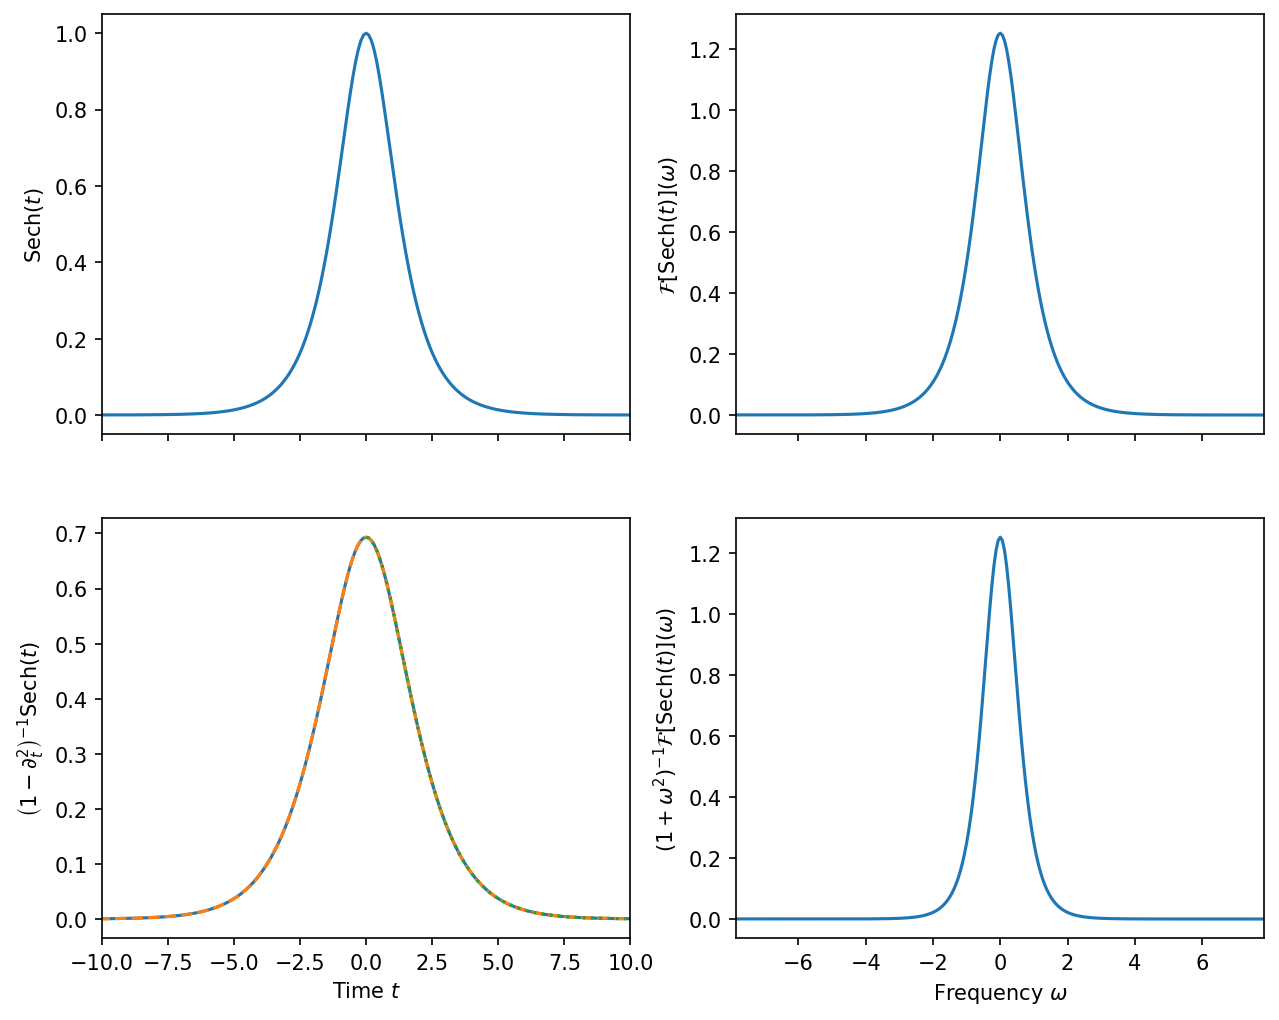

In [4]:
fig,axs = plt.subplots(2,2,figsize=(10,8),dpi=150,sharex='col')

axs[0,0].plot(ts[tord_idx],fts[tord_idx])
axs[0,1].plot(os[oord_idx],fos[oord_idx])
axs[1,1].plot(os[oord_idx],(fos/(1+os**2))[oord_idx])
axs[1,0].plot(ts[tord_idx],np.real(np.fft.ifft(fos/(1+os**2))[tord_idx] * np.sqrt(2*np.pi) / dt))
axs[1,0].plot(ts[tord_idx],np.linalg.solve(L,fts)[tord_idx],'--')
axs[1,0].plot(ts[:NT//2],np.linalg.solve(Lh,fts[:NT//2]),':')

axs[0,0].set_xlim(-10,10)
axs[0,1].set_xlim(-2.5*np.pi,2.5*np.pi)

axs[1,0].set_xlabel(r'Time $t$')
axs[1,1].set_xlabel(r'Frequency $\omega$')
axs[0,0].set_ylabel(r'$\mathrm{Sech}(t)$')
axs[0,1].set_ylabel(r'$\mathcal{F}\left[\mathrm{Sech}(t)\right](\omega)$')
axs[1,0].set_ylabel(r'$\left(1-\partial_t^2\right)^{-1}\mathrm{Sech}(t)$')
axs[1,1].set_ylabel(r'$\left(1+\omega^2\right)^{-1}\mathcal{F}\left[\mathrm{Sech}(t)\right](\omega)$')

# Solve More Complex ODE with Finite Differences

In [5]:
δ = np.zeros(NT)
δ[0] = 1/dt

L = np.zeros((NT,NT))
L[(np.arange(NT), np.arange(NT))] = 1 + 2/dt**2 - np.exp(-0.5*ts**2)# - 1.747*np.exp(-0.5*ts**2)# - 1.674/np.cosh(ts)
L[(np.arange(NT-1), np.arange(1,NT))] = -1/dt**2
L[(np.arange(1,NT), np.arange(NT-1))] = -1/dt**2
L[0,-1] = -1/dt**2
L[-1,0] = -1/dt**2

Text(0, 0.5, '$\\left(1+\\omega^2\\right)^{-1}\\mathcal{F}\\left[\\delta(t)\\right](\\omega)$')

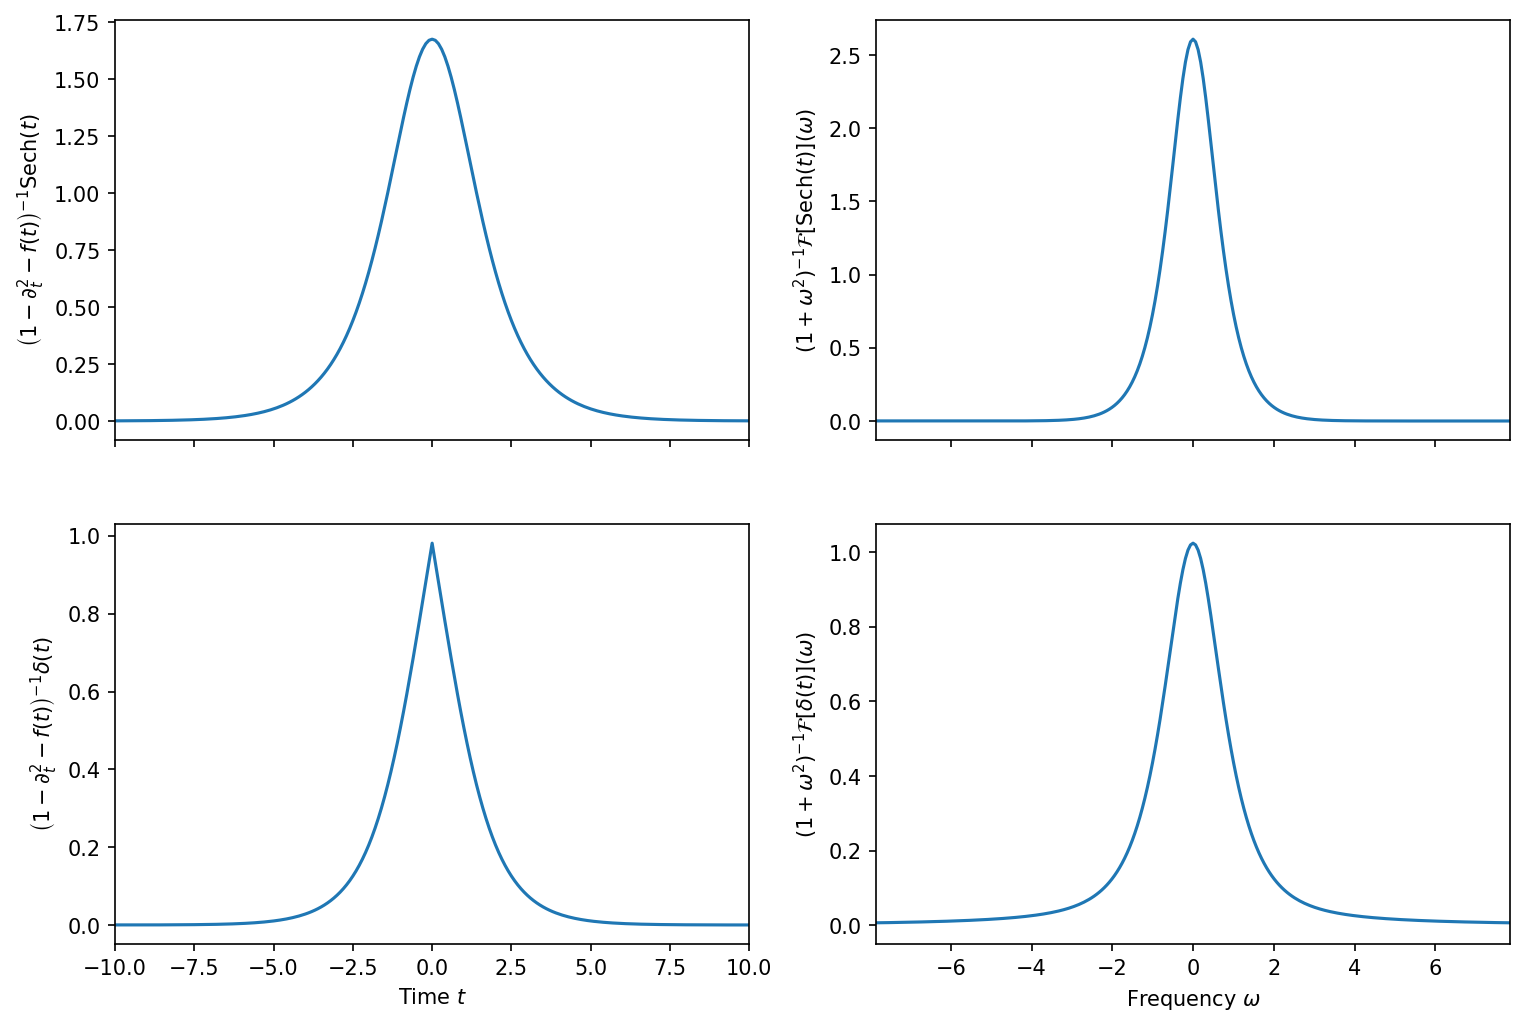

In [6]:
fig,axs = plt.subplots(2,2,figsize=(12,8),dpi=150,sharex='col')

axs[0,0].plot(ts[tord_idx],np.linalg.solve(L,fts)[tord_idx])
axs[0,1].plot(os[oord_idx],np.real(np.fft.fft(np.linalg.solve(L,fts)))[oord_idx] * dt / np.sqrt(2*np.pi))
axs[1,0].plot(ts[tord_idx],np.linalg.solve(L,δ)[tord_idx])
axs[1,1].plot(os[oord_idx],np.real(np.fft.fft(np.linalg.solve(L,δ)))[oord_idx] * dt / np.sqrt(2*np.pi))

axs[0,0].set_xlim(-10,10)
axs[0,1].set_xlim(-2.5*np.pi,2.5*np.pi)

axs[1,0].set_xlabel(r'Time $t$')
axs[1,1].set_xlabel(r'Frequency $\omega$')
axs[0,0].set_ylabel(r'$\left(1-\partial_t^2-f(t)\right)^{-1}\mathrm{Sech}(t)$')
axs[0,1].set_ylabel(r'$\left(1+\omega^2\right)^{-1}\mathcal{F}\left[\mathrm{Sech}(t)\right](\omega)$')
axs[1,0].set_ylabel(r'$\left(1-\partial_t^2-f(t)\right)^{-1}\delta(t)$')
axs[1,1].set_ylabel(r'$\left(1+\omega^2\right)^{-1}\mathcal{F}\left[\delta(t)\right](\omega)$')

# Calculate Values Needed for Linear Response

## Run DMFT on zero contrast fit, and perturb external rate

In [3]:
import dmft

id = None
if id is None:
    with open('./../results/best_fit.pkl', 'rb') as handle:
    # with open('./../results/dmft_grad_descent_id_None_n_75.pkl', 'rb') as handle:
    # with open('./../results/dmft_grad_descent_id_best_fit_v1_n_9.pkl', 'rb') as handle:
        res_dict = pickle.load(handle)
elif len(id)==2:
    with open('./../results/results_ring_{:d}.pkl'.format(
            id[0]), 'rb') as handle:
        res_dict = pickle.load(handle)[id[-1]]
else:
    with open('./../results/results_ring_perturb_njob-{:d}_nrep-{:d}_ntry-{:d}.pkl'.format(
            id[0],id[1],id[2]), 'rb') as handle:
        res_dict = pickle.load(handle)[id[-1]]
prms = res_dict['prms']
eX = res_dict['best_monk_eX']
bX = res_dict['best_monk_bX']
aXs = res_dict['best_monk_aXs']
K = prms['K']
SoriE = prms['SoriE']
SoriI = prms['SoriI']
SoriF = prms['SoriF']
J = prms['J']
beta = prms['beta']
gE = prms['gE']
gI = prms['gI']
hE = prms['hE']
hI = prms['hI']
L = prms['L']
CVL = prms['CVL']
    
ri = ric.Ricciardi()

In [8]:
reload(dmft)

Twrm = 1.2
Tsav = 0.4
dt = 0.01/3

δrX = 0.2

res_dict_init = dmft.run_first_stage_dmft(prms,bX,eX,'./../results',ri,Twrm,Tsav,dt,which='base',return_full=True)
res_dict_pert = dmft.run_first_stage_dmft(prms,bX+δrX,eX,'./../results',ri,Twrm,Tsav,dt,which='base',return_full=True)

0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
integrating first stage took 45.792826 s
0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
integrating first stage took 55.101624 s


## Calculate mean and cross-covariance function of rate drives and derivatives

In [5]:
reload(dmft)

FE,FI,ME,MI,CE,CI = dmft.base_itp_moments('./../results')
FL,ML,CL = dmft.opto_itp_moments('./../results',prms['L'],prms['CVL'])
    
def base_M(mui,Sigii,out):
    out[0] = ME(mui[0],Sigii[0])[0]
    out[1] = MI(mui[1],Sigii[1])[0]
    
def base_C(mui,Sigii,Sigij,out):
    out[0] = CE(mui[0],Sigii[0],Sigij[0])[0]
    out[1] = CI(mui[1],Sigii[1],Sigij[1])[0]

def opto_M(mui,Sigii,out):
    out[0] = ML(mui[0],Sigii[0])[0]
    out[1] = MI(mui[1],Sigii[1])[0]
    
def opto_C(mui,Sigii,Sigij,out):
    out[0] = CL(mui[0],Sigii[0],Sigij[0])[0]
    out[1] = CI(mui[1],Sigii[1],Sigij[1])[0]

tau = np.array([ri.tE,ri.tI],dtype=np.float32)
W = J*np.array([[1,-gE],[1./beta,-gI/beta]],dtype=np.float32)
Ks = np.array([K,K/4],dtype=np.float32)
H = bX*K*J*np.array([hE,hI/beta],dtype=np.float32)
eH = eX

muH = tau*H
SigH = (muH*eH)**2

muW = tau[:,None]*W*Ks
SigW = tau[:,None]**2*W**2*Ks

dmuHdξ = tau*K*J*np.array([hE,hI/beta],dtype=np.float32)
dSigHdξ = 2*muH*dmuHdξ*eH**2

In [5]:
def get_time_freq_func(f):
    N = f.shape[-1]
    new_shape = np.array(f.shape)
    new_shape[-1] += N-2
    ft = np.zeros(new_shape)
    ft[...,:N] = f
    ft[...,N:] = f[...,-1:1:-1]
    fo = np.real(np.fft.fft(ft))
    return ft,fo

def smooth_func(f,dt,fcut=17,beta=1):
    N = f.shape[-1]
    _,fo = get_time_freq_func(f)
    fo *= 1/(1 + np.exp((np.abs(np.fft.fftfreq(2*(N-1),dt)) - fcut)*beta))
    return np.real(np.fft.ifft(fo))[...,:N]

## Construct matrices and vectors to solve for linear suceptibilities

In [11]:
reload(dmft)

NP = res_dict_init['Sig'].shape[0]
NT = res_dict_init['Sig'].shape[1]
dt = 0.01/3
ts = np.arange(NT)*dt

r = res_dict_init['r']
Cr = res_dict_init['Cr']

res_dict_lin_resp = dmft.lin_resp_mats(tau,muW,SigW,dmuHdξ,dSigHdξ,base_M,base_C,Tsav,dt,
                                       res_dict_init['mu'],res_dict_init['Sig'])

A = res_dict_lin_resp['A']
B = res_dict_lin_resp['B']
C = res_dict_lin_resp['C']
D = res_dict_lin_resp['D']
D0dis = res_dict_lin_resp['D0dis']
E = res_dict_lin_resp['E']
F = res_dict_lin_resp['F']

In [12]:
print(A)
print(B[:,:,0])
print(C[:,0,:])
print(D[:,0,:,0])
print()
print(E)
print(F[:,0])

[[ -1.28870702   3.40446329]
 [-11.18823433   8.29032803]]
[[-0.00027695 -0.00245119]
 [-0.00421099 -0.0071518 ]]
[[ -108.54617   161.46298]
 [-1387.0948    903.8402 ]]
[[60.97744174 -0.1996504 ]
 [-0.71193421 11.79087475]]

[11.395694   1.6515415]
[543.13022337 204.80264698]


## Verify that rate moments satisfy self-consistent equations

In [6]:
def svd_inv(A,reg=0):
    U,S,VH = np.linalg.svd(A+reg*np.eye(A.shape[0]))
    Sinv = 1/S
    # Sinv[S < reg] = 0#S[S < reg]
    return VH.T@np.diag(Sinv)@U.T

def svd_solve(A,b,reg=0):
    U,S,VH = np.linalg.svd(A+reg*np.eye(A.shape[0]))
    Sinv = 1/S#(S+reg)
    # Sinv[S < reg] = 1/reg#0#S[S < reg]
    return VH.T@np.diag(Sinv)@U.T@b

def svd_cond(A,reg=0):
    S = np.linalg.svd(A+reg*np.eye(A.shape[0]),compute_uv=False)
    return np.max(S)/np.fmax(reg,np.min(S))

In [14]:
M = np.block([[A,B.reshape(NP,NP*NT)],[C.reshape(NP*NT,NP),D.reshape(NP*NT,NP*NT)]])
f = np.concatenate([E,F.flatten()])

M0dis = np.block([[A,np.zeros_like(B).reshape(NP,NP*NT)],[C.reshape(NP*NT,NP),D0dis.reshape(NP*NT,NP*NT)]])

In [15]:
S0dis = np.linalg.svd(D0dis.reshape(NP*NT,NP*NT),compute_uv=False)
S = np.linalg.svd(M,compute_uv=False)

print(np.linalg.cond(D0dis.reshape(NP*NT,NP*NT)))
print(svd_cond(M))
print(svd_cond(M,0.005*np.min(S0dis)))

122.10989024637941
28271939.48917663
3073091.134385268


In [16]:
# dmdξ = np.linalg.solve(M,f)
dmdξ = svd_solve(M,f,0.005*np.min(S0dis))
drdξ = dmdξ[:NP]
dCrdξ = dmdξ[NP:].reshape(NP,NT)

# dmdξ0dis = np.linalg.solve(M0dis,f)
dmdξ0dis = svd_solve(M0dis,f,0.005*np.min(S0dis))
drdξ0dis = dmdξ0dis[:NP]
dCrdξ0dis = dmdξ0dis[NP:].reshape(NP,NT)

Text(0, 0.5, 'Change in Moments, No Weight Disorder')

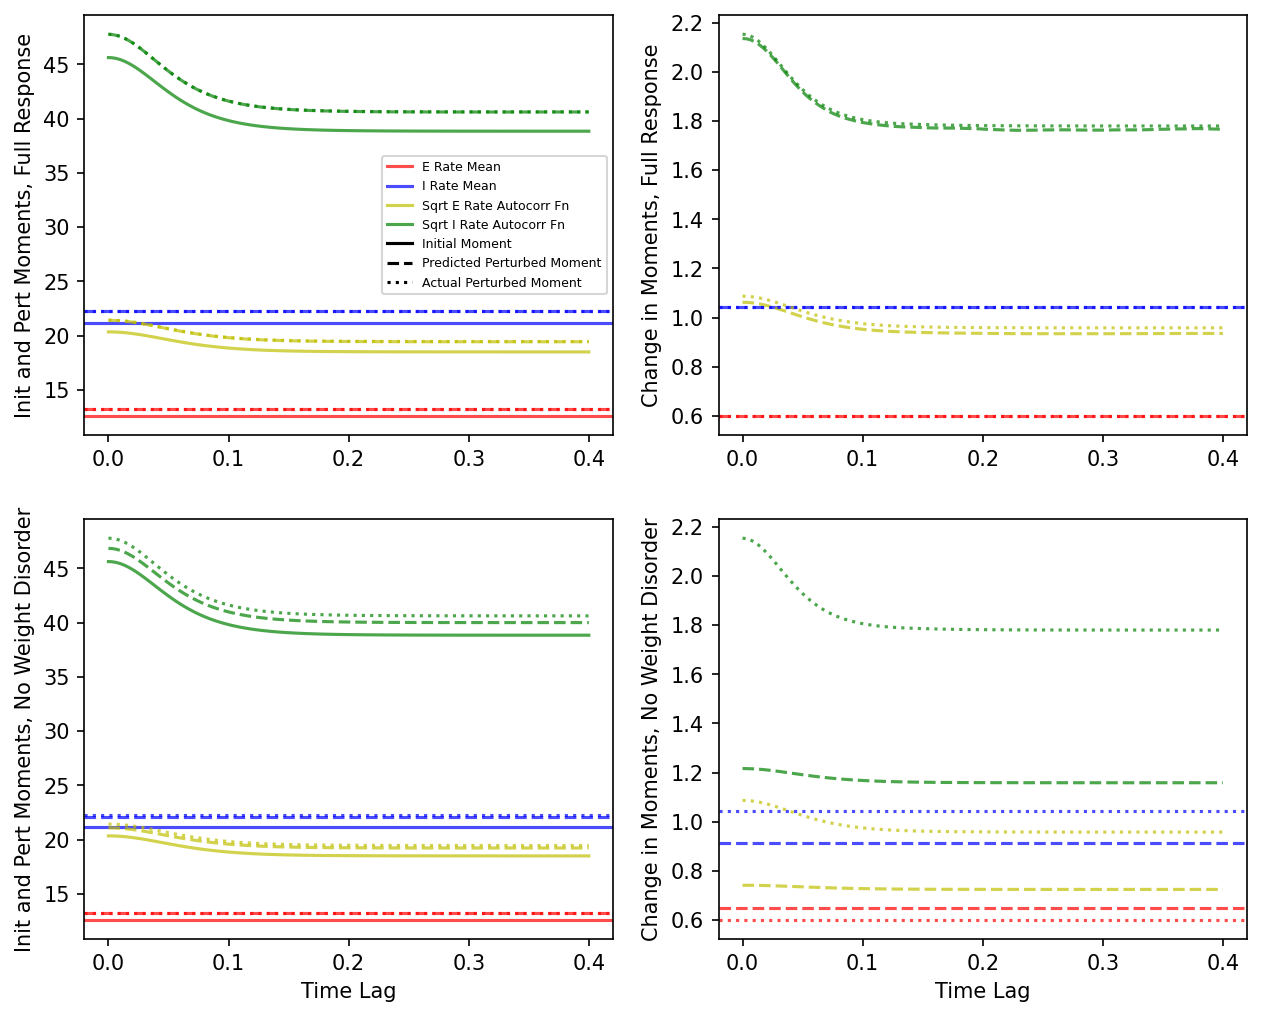

In [17]:
fig,axs= plt.subplots(2,2,figsize=(10,8),dpi=150)

axs[0,0].axhline(r[0],c='r',alpha=0.7,label='E Rate Mean')
axs[0,0].axhline(r[1],c='b',alpha=0.7,label='I Rate Mean')
axs[0,0].plot(ts,np.sqrt(Cr[0]),c='y',alpha=0.7,label='Sqrt E Rate Autocorr Fn')
axs[0,0].plot(ts,np.sqrt(Cr[1]),c='g',alpha=0.7,label='Sqrt I Rate Autocorr Fn')

axs[0,0].axhline(r[0] + drdξ[0]*δrX,c='r',ls='--',alpha=0.7)
axs[0,0].axhline(r[1] + drdξ[1]*δrX,c='b',ls='--',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(Cr[0] + dCrdξ[0]*δrX),c='y',ls='--',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(Cr[1] + dCrdξ[1]*δrX),c='g',ls='--',alpha=0.7)

axs[0,0].axhline(res_dict_pert['r'][0],c='r',ls=':',alpha=0.7)
axs[0,0].axhline(res_dict_pert['r'][1],c='b',ls=':',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(res_dict_pert['Cr'][0]),c='y',ls=':',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(res_dict_pert['Cr'][1]),c='g',ls=':',alpha=0.7)

axs[0,0].plot(np.nan,np.nan,c='k',ls='-',label='Initial Moment')
axs[0,0].plot(np.nan,np.nan,c='k',ls='--',label='Predicted Perturbed Moment')
axs[0,0].plot(np.nan,np.nan,c='k',ls=':',label='Actual Perturbed Moment')

axs[0,0].legend(fontsize=6)

axs[0,1].axhline(drdξ[0]*δrX,c='r',ls='--',alpha=0.7)
axs[0,1].axhline(drdξ[1]*δrX,c='b',ls='--',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(Cr[0] + dCrdξ[0]*δrX) - np.sqrt(Cr[0]),c='y',ls='--',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(Cr[1] + dCrdξ[1]*δrX) - np.sqrt(Cr[1]),c='g',ls='--',alpha=0.7)

axs[0,1].axhline(res_dict_pert['r'][0] - r[0],c='r',ls=':',alpha=0.7)
axs[0,1].axhline(res_dict_pert['r'][1] - r[1],c='b',ls=':',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(res_dict_pert['Cr'][0]) - np.sqrt(Cr[0]),c='y',ls=':',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(res_dict_pert['Cr'][1]) - np.sqrt(Cr[1]),c='g',ls=':',alpha=0.7)

axs[1,0].axhline(r[0],c='r',alpha=0.7,label='Initial E Rate Mean')
axs[1,0].axhline(r[1],c='b',alpha=0.7,label='Initial I Rate Mean')
axs[1,0].plot(ts,np.sqrt(Cr[0]),c='y',alpha=0.7,label='Initial Sqrt E Rate Autocorr Fn')
axs[1,0].plot(ts,np.sqrt(Cr[1]),c='g',alpha=0.7,label='Initial Sqrt I Rate Autocorr Fn')

axs[1,0].axhline(r[0] + drdξ0dis[0]*δrX,c='r',ls='--',alpha=0.7,label='Predicted Perturbed E Rate Mean')
axs[1,0].axhline(r[1] + drdξ0dis[1]*δrX,c='b',ls='--',alpha=0.7,label='Predicted Perturbed I Rate Mean')
axs[1,0].plot(ts,np.sqrt(Cr[0] + dCrdξ0dis[0]*δrX),c='y',ls='--',alpha=0.7,label='Predicted Perturbed Sqrt E Rate Autocorr Fn')
axs[1,0].plot(ts,np.sqrt(Cr[1] + dCrdξ0dis[1]*δrX),c='g',ls='--',alpha=0.7,label='Predicted Perturbed Sqrt I Rate Autocorr Fn')

axs[1,0].axhline(res_dict_pert['r'][0],c='r',ls=':',alpha=0.7,label='Perturbed E Rate Mean')
axs[1,0].axhline(res_dict_pert['r'][1],c='b',ls=':',alpha=0.7,label='Perturbed I Rate Mean')
axs[1,0].plot(ts,np.sqrt(res_dict_pert['Cr'][0]),c='y',ls=':',alpha=0.7,label='Perturbed Sqrt E Rate Autocorr Fn')
axs[1,0].plot(ts,np.sqrt(res_dict_pert['Cr'][1]),c='g',ls=':',alpha=0.7,label='Perturbed Sqrt I Rate Autocorr Fn')

axs[1,1].axhline(drdξ0dis[0]*δrX,c='r',ls='--',alpha=0.7)
axs[1,1].axhline(drdξ0dis[1]*δrX,c='b',ls='--',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(Cr[0] + dCrdξ0dis[0]*δrX) - np.sqrt(Cr[0]),c='y',ls='--',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(Cr[1] + dCrdξ0dis[1]*δrX) - np.sqrt(Cr[1]),c='g',ls='--',alpha=0.7)

axs[1,1].axhline(res_dict_pert['r'][0] - r[0],c='r',ls=':',alpha=0.7)
axs[1,1].axhline(res_dict_pert['r'][1] - r[1],c='b',ls=':',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(res_dict_pert['Cr'][0]) - np.sqrt(Cr[0]),c='y',ls=':',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(res_dict_pert['Cr'][1]) - np.sqrt(Cr[1]),c='g',ls=':',alpha=0.7)

axs[1,0].set_xlabel('Time Lag')
axs[1,1].set_xlabel('Time Lag')
axs[0,0].set_ylabel('Init and Pert Moments, Full Response')
axs[0,1].set_ylabel('Change in Moments, Full Response')
axs[1,0].set_ylabel('Init and Pert Moments, No Weight Disorder')
axs[1,1].set_ylabel('Change in Moments, No Weight Disorder')

Text(0, 0.5, 'Change in Moments, No Weight Disorder')

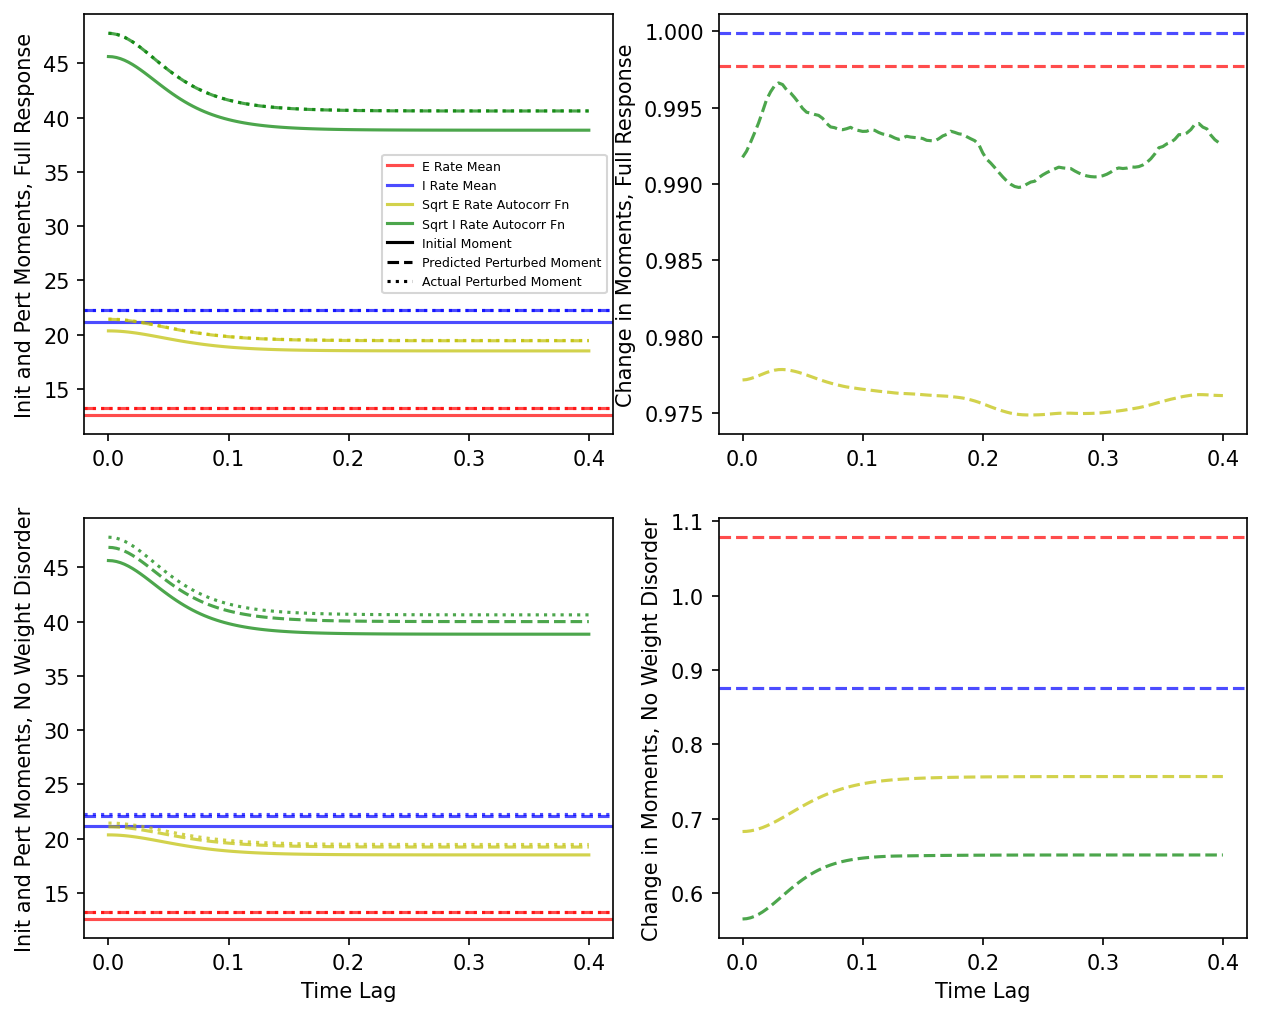

In [18]:
fig,axs= plt.subplots(2,2,figsize=(10,8),dpi=150)

axs[0,0].axhline(r[0],c='r',alpha=0.7,label='E Rate Mean')
axs[0,0].axhline(r[1],c='b',alpha=0.7,label='I Rate Mean')
axs[0,0].plot(ts,np.sqrt(Cr[0]),c='y',alpha=0.7,label='Sqrt E Rate Autocorr Fn')
axs[0,0].plot(ts,np.sqrt(Cr[1]),c='g',alpha=0.7,label='Sqrt I Rate Autocorr Fn')

axs[0,0].axhline(r[0] + drdξ[0]*δrX,c='r',ls='--',alpha=0.7)
axs[0,0].axhline(r[1] + drdξ[1]*δrX,c='b',ls='--',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(Cr[0] + dCrdξ[0]*δrX),c='y',ls='--',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(Cr[1] + dCrdξ[1]*δrX),c='g',ls='--',alpha=0.7)

axs[0,0].axhline(res_dict_pert['r'][0],c='r',ls=':',alpha=0.7)
axs[0,0].axhline(res_dict_pert['r'][1],c='b',ls=':',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(res_dict_pert['Cr'][0]),c='y',ls=':',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(res_dict_pert['Cr'][1]),c='g',ls=':',alpha=0.7)

axs[0,0].plot(np.nan,np.nan,c='k',ls='-',label='Initial Moment')
axs[0,0].plot(np.nan,np.nan,c='k',ls='--',label='Predicted Perturbed Moment')
axs[0,0].plot(np.nan,np.nan,c='k',ls=':',label='Actual Perturbed Moment')

axs[0,0].legend(fontsize=6)

axs[0,1].axhline(drdξ[0]*δrX/(res_dict_pert['r'][0] - r[0]),c='r',ls='--',alpha=0.7)
axs[0,1].axhline(drdξ[1]*δrX/(res_dict_pert['r'][1] - r[1]),c='b',ls='--',alpha=0.7)
axs[0,1].plot(ts,(np.sqrt(Cr[0] + dCrdξ[0]*δrX) - np.sqrt(Cr[0]))/(np.sqrt(res_dict_pert['Cr'][0]) - np.sqrt(Cr[0])),c='y',ls='--',alpha=0.7)
axs[0,1].plot(ts,(np.sqrt(Cr[1] + dCrdξ[1]*δrX) - np.sqrt(Cr[1]))/(np.sqrt(res_dict_pert['Cr'][1]) - np.sqrt(Cr[1])),c='g',ls='--',alpha=0.7)

axs[1,0].axhline(r[0],c='r',alpha=0.7,label='Initial E Rate Mean')
axs[1,0].axhline(r[1],c='b',alpha=0.7,label='Initial I Rate Mean')
axs[1,0].plot(ts,np.sqrt(Cr[0]),c='y',alpha=0.7,label='Initial Sqrt E Rate Autocorr Fn')
axs[1,0].plot(ts,np.sqrt(Cr[1]),c='g',alpha=0.7,label='Initial Sqrt I Rate Autocorr Fn')

axs[1,0].axhline(r[0] + drdξ0dis[0]*δrX,c='r',ls='--',alpha=0.7,label='Predicted Perturbed E Rate Mean')
axs[1,0].axhline(r[1] + drdξ0dis[1]*δrX,c='b',ls='--',alpha=0.7,label='Predicted Perturbed I Rate Mean')
axs[1,0].plot(ts,np.sqrt(Cr[0] + dCrdξ0dis[0]*δrX),c='y',ls='--',alpha=0.7,label='Predicted Perturbed Sqrt E Rate Autocorr Fn')
axs[1,0].plot(ts,np.sqrt(Cr[1] + dCrdξ0dis[1]*δrX),c='g',ls='--',alpha=0.7,label='Predicted Perturbed Sqrt I Rate Autocorr Fn')

axs[1,0].axhline(res_dict_pert['r'][0],c='r',ls=':',alpha=0.7,label='Perturbed E Rate Mean')
axs[1,0].axhline(res_dict_pert['r'][1],c='b',ls=':',alpha=0.7,label='Perturbed I Rate Mean')
axs[1,0].plot(ts,np.sqrt(res_dict_pert['Cr'][0]),c='y',ls=':',alpha=0.7,label='Perturbed Sqrt E Rate Autocorr Fn')
axs[1,0].plot(ts,np.sqrt(res_dict_pert['Cr'][1]),c='g',ls=':',alpha=0.7,label='Perturbed Sqrt I Rate Autocorr Fn')

axs[1,1].axhline(drdξ0dis[0]*δrX/(res_dict_pert['r'][0] - r[0]),c='r',ls='--',alpha=0.7)
axs[1,1].axhline(drdξ0dis[1]*δrX/(res_dict_pert['r'][1] - r[1]),c='b',ls='--',alpha=0.7)
axs[1,1].plot(ts,(np.sqrt(Cr[0] + dCrdξ0dis[0]*δrX) - np.sqrt(Cr[0]))/(np.sqrt(res_dict_pert['Cr'][0]) - np.sqrt(Cr[0])),c='y',ls='--',alpha=0.7)
axs[1,1].plot(ts,(np.sqrt(Cr[1] + dCrdξ0dis[1]*δrX) - np.sqrt(Cr[1]))/(np.sqrt(res_dict_pert['Cr'][1]) - np.sqrt(Cr[1])),c='g',ls='--',alpha=0.7)

axs[1,0].set_xlabel('Time Lag')
axs[1,1].set_xlabel('Time Lag')
axs[0,0].set_ylabel('Init and Pert Moments, Full Response')
axs[0,1].set_ylabel('Change in Moments, Full Response')
axs[1,0].set_ylabel('Init and Pert Moments, No Weight Disorder')
axs[1,1].set_ylabel('Change in Moments, No Weight Disorder')

# Calculate linear response with Structure

In [7]:
reload(dmft)

Twrm = 1.2
Tsav = 0.4
dt = 0.01/3

δrX = 0.2

res_dict_init = dmft.run_first_stage_ring_dmft(prms,bX,aXs[-1]/bX,eX,'./../results',ri,Twrm,Tsav,dt,which='base',return_full=True)
res_dict_pert = dmft.run_first_stage_ring_dmft(prms,bX+δrX,aXs[-1]/(bX+δrX),eX,'./../results',ri,Twrm,Tsav,dt,which='base',return_full=True)

0.20% completed


/Users/tuannguyen/ToroidalNetworks/sparse_weights/notebooks/./../scripts/dmft.py:710: RuntimeWarning: invalid value encountered in divide
  sCri = solve_width((Crsi[1]-Crsi[0])/(Crsi[2]-Crsi[0]))


0.40% completed
0.60% completed
0.80% completed
1.00% completed
integrating first stage took 152.890679 s
0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
integrating first stage took 147.671994 s


In [9]:
rb = res_dict_init['rb']
rp = res_dict_init['rp']
sr = res_dict_init['sr']
Crb = res_dict_init['Crb']
Crp = res_dict_init['Crp']
sCr = res_dict_init['sCr'][:,-1]

print(res_dict_init['sr'])
print(res_dict_init['sCr'][:,-1])
print()
print(res_dict_pert['sr'])
print(res_dict_pert['sCr'][:,-1])

[12.68157838 33.16991463]
[11.11535617 31.15440864]

[12.71955606 33.16253932]
[11.19468902 31.28441013]


In [10]:
SoriE = prms['SoriE']
SoriI = prms['SoriI']

Hb = bX*K*J*np.array([hE,hI/beta],dtype=np.float32)
Hp = (bX+aXs[-1])*K*J*np.array([hE,hI/beta],dtype=np.float32)

muHb = tau*Hb
SigHb = (muHb*eH)**2
muHp = tau*Hp
SigHp = (muHp*eH)**2

sW = np.array([[SoriE,SoriI],[SoriE,SoriI]],dtype=np.float32)
sW2 = sW**2
sWr = np.sqrt(sW2+sr**2)
sWCr = np.sqrt(sW2+sCr**2)

muWbb = (1 - dmft.struct_fact(180/2,sWr,sr,180)) * muW
muWbp = dmft.struct_fact(180/2,sWr,sr,180) * muW
muWpb = (1 - dmft.struct_fact(0,sWr,sr,180)) * muW
muWpp = dmft.struct_fact(0,sWr,sr,180) * muW

SigWbb = (1 - dmft.struct_fact(180/2,sWCr,sCr,180)) * SigW
SigWbp = dmft.struct_fact(180/2,sWCr,sCr,180) * SigW
SigWpb = (1 - dmft.struct_fact(0,sWCr,sCr,180)) * SigW
SigWpp = dmft.struct_fact(0,sWCr,sCr,180) * SigW

dmuHbdξ = tau*K*J*np.array([hE,hI/beta],dtype=np.float32)# + dmuWbpdsr*dsr/δrX@rp + dmuWbbdsr*dsr/δrX@rb
dmuHpdξ = tau*K*J*np.array([hE,hI/beta],dtype=np.float32)# + dmuWppdsr*dsr/δrX@rp + dmuWpbdsr*dsr/δrX@rb
dSigHbdξ = (2*muHb*dmuHbdξ*eH**2)[:,None]# + dSigWbpdsCr*dsCr/δrX@Crp + dSigWbbdsCr*dsCr/δrX@Crb
dSigHpdξ = (2*muHp*dmuHpdξ*eH**2)[:,None]# + dSigWppdsCr*dsCr/δrX@Crp + dSigWpbdsCr*dsCr/δrX@Crb

block_muW = np.block([
    [muWbb,muWbp],
    [muWpb,muWpp]
])
block_SigW = np.block([
    [SigWbb,SigWbp],
    [SigWpb,SigWpp]
])

block_dmuHdξ = np.concatenate([dmuHbdξ,dmuHpdξ])
block_dSigHdξ = np.concatenate([dSigHbdξ,dSigHpdξ],0)

block_mu = np.concatenate([res_dict_init['mub'],res_dict_init['mup']])
block_Sig = np.concatenate([res_dict_init['Sigb'],res_dict_init['Sigp']],0)
    
def block_base_M(mui,Sigii,out):
    out[0] = ME(mui[0],Sigii[0])[0]
    out[1] = MI(mui[1],Sigii[1])[0]
    out[2] = ME(mui[2],Sigii[2])[0]
    out[3] = MI(mui[3],Sigii[3])[0]
    
def block_base_C(mui,Sigii,Sigij,out):
    out[0] = CE(mui[0],Sigii[0],Sigij[0])[0]
    out[1] = CI(mui[1],Sigii[1],Sigij[1])[0]
    out[2] = CE(mui[2],Sigii[2],Sigij[2])[0]
    out[3] = CI(mui[3],Sigii[3],Sigij[3])[0]

In [ ]:
res_dict_lin_resp = dmft.lin_resp_mats(np.concatenate([tau,tau]),block_muW,block_SigW,
                                       block_dmuHdξ,block_dSigHdξ,block_base_M,block_base_C,Tsav,dt,
                                       block_mu,block_Sig)

A = res_dict_lin_resp['A']
B = res_dict_lin_resp['B']
C = res_dict_lin_resp['C']
D = res_dict_lin_resp['D']
D0dis = res_dict_lin_resp['D0dis'][:2,:,:2,:]
E = res_dict_lin_resp['E']
F = res_dict_lin_resp['F']

Abb,Abp,Apb,App = A[:2,  :2],  A[:2,  2:],  A[2:,  :2],  A[2:,  2:]
Bbb,Bbp,Bpb,Bpp = B[:2,  :2,:],B[:2,  2:,:],B[2:,  :2,:],B[2:,  2:,:]
Cbb,Cbp,Cpb,Cpp = C[:2,:,:2],  C[:2,:,2:],  C[2:,:,:2],  C[2:,:,2:]
Dbb,Dbp,Dpb,Dpp = D[:2,:,:2,:],D[:2,:,2:,:],D[2:,:,:2,:],D[2:,:,2:,:]
Eb,Ep = E[:2],  E[2:]
Fb,Fp = F[:2,:],F[2:,:]

In [ ]:
Mbb = np.block([[Abb,Bbb.reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
Mbp = np.block([[Abp,Bbp.reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
Mpb = np.block([[Apb,Bpb.reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
Mpp = np.block([[App,Bpp.reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),Dpp.reshape(NP*NT,NP*NT)]])
fb = np.concatenate([Eb,Fb.flatten()])
fp = np.concatenate([Ep,Fp.flatten()])

Mbb0dis = np.block([[Abb,np.zeros_like(Bbb).reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),D0dis.reshape(NP*NT,NP*NT)]])
Mbp0dis = np.block([[Abp,np.zeros_like(Bbp).reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),np.zeros_like(Dbp).reshape(NP*NT,NP*NT)]])
Mpb0dis = np.block([[Apb,np.zeros_like(Bpb).reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),np.zeros_like(Dpb).reshape(NP*NT,NP*NT)]])
Mpp0dis = np.block([[App,np.zeros_like(Bpp).reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),D0dis.reshape(NP*NT,NP*NT)]])

M = np.block([[Mbb,Mbp],[Mpb,Mpp]])
M0dis = np.block([[Mbb0dis,Mbp0dis],[Mpb0dis,Mpp0dis]])
f = np.concatenate([fb,fp])

In [ ]:
dmdξ = np.linalg.solve(M,f)
dmbdξ = dmdξ[:NP+NP*NT]
dmpdξ = dmdξ[NP+NP*NT:]
drbdξ = dmbdξ[:NP]
dCrbdξ = dmbdξ[NP:].reshape(NP,NT)
drpdξ = dmpdξ[:NP]
dCrpdξ = dmpdξ[NP:].reshape(NP,NT)

dmdξ0dis = np.linalg.solve(M0dis,f)
dmbdξ0dis = dmdξ0dis[:NP+NP*NT]
dmpdξ0dis = dmdξ0dis[NP+NP*NT:]
drbdξ0dis = dmbdξ0dis[:NP]
dCrbdξ0dis = dmbdξ0dis[NP:].reshape(NP,NT)
drpdξ0dis = dmpdξ0dis[:NP]
dCrpdξ0dis = dmpdξ0dis[NP:].reshape(NP,NT)

Text(0, 0.5, 'Change in Peak Moments, No Weight Disorder')

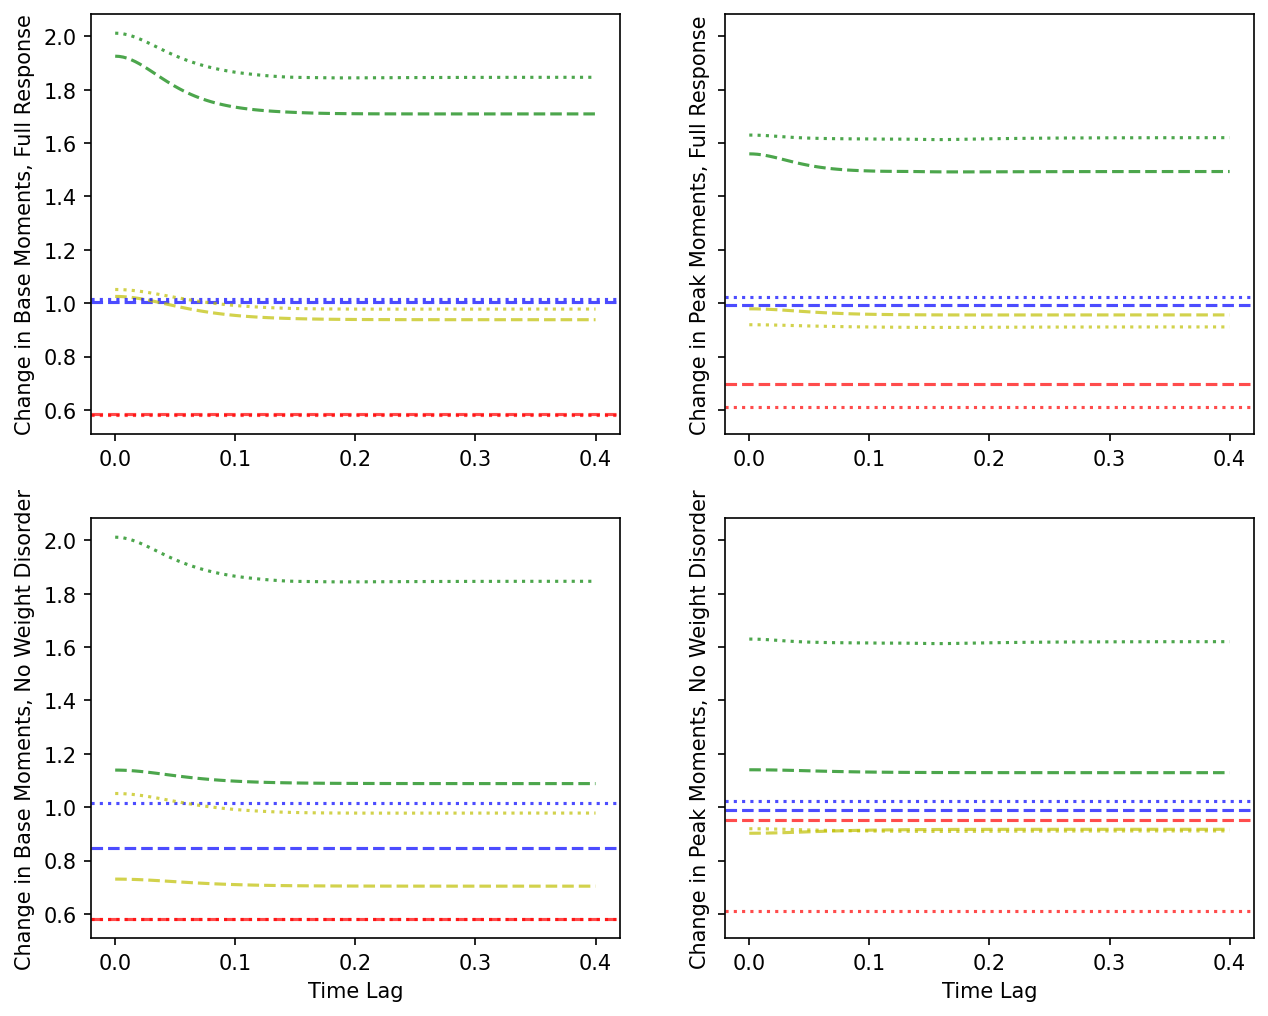

In [87]:
fig,axs= plt.subplots(2,2,figsize=(10,8),dpi=150,sharey=True)

axs[0,0].axhline(drbdξ[0]*δrX,c='r',ls='--',alpha=0.7)
axs[0,0].axhline(drbdξ[1]*δrX,c='b',ls='--',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(Crb[0] + dCrbdξ[0]*δrX) - np.sqrt(Crb[0]),c='y',ls='--',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(Crb[1] + dCrbdξ[1]*δrX) - np.sqrt(Crb[1]),c='g',ls='--',alpha=0.7)

axs[0,0].axhline(res_dict_pert['rb'][0] - rb[0],c='r',ls=':',alpha=0.7)
axs[0,0].axhline(res_dict_pert['rb'][1] - rb[1],c='b',ls=':',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(res_dict_pert['Crb'][0]) - np.sqrt(Crb[0]),c='y',ls=':',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(res_dict_pert['Crb'][1]) - np.sqrt(Crb[1]),c='g',ls=':',alpha=0.7)

axs[0,1].axhline(drpdξ[0]*δrX,c='r',ls='--',alpha=0.7)
axs[0,1].axhline(drpdξ[1]*δrX,c='b',ls='--',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(Crp[0] + dCrpdξ[0]*δrX) - np.sqrt(Crp[0]),c='y',ls='--',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(Crp[1] + dCrpdξ[1]*δrX) - np.sqrt(Crp[1]),c='g',ls='--',alpha=0.7)

axs[0,1].axhline(res_dict_pert['rp'][0] - rp[0],c='r',ls=':',alpha=0.7)
axs[0,1].axhline(res_dict_pert['rp'][1] - rp[1],c='b',ls=':',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(res_dict_pert['Crp'][0]) - np.sqrt(Crp[0]),c='y',ls=':',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(res_dict_pert['Crp'][1]) - np.sqrt(Crp[1]),c='g',ls=':',alpha=0.7)

axs[1,0].axhline(drbdξ0dis[0]*δrX,c='r',ls='--',alpha=0.7)
axs[1,0].axhline(drbdξ0dis[1]*δrX,c='b',ls='--',alpha=0.7)
axs[1,0].plot(ts,np.sqrt(Crb[0] + dCrbdξ0dis[0]*δrX) - np.sqrt(Crb[0]),c='y',ls='--',alpha=0.7)
axs[1,0].plot(ts,np.sqrt(Crb[1] + dCrbdξ0dis[1]*δrX) - np.sqrt(Crb[1]),c='g',ls='--',alpha=0.7)

axs[1,0].axhline(res_dict_pert['rb'][0] - rb[0],c='r',ls=':',alpha=0.7)
axs[1,0].axhline(res_dict_pert['rb'][1] - rb[1],c='b',ls=':',alpha=0.7)
axs[1,0].plot(ts,np.sqrt(res_dict_pert['Crb'][0]) - np.sqrt(Crb[0]),c='y',ls=':',alpha=0.7)
axs[1,0].plot(ts,np.sqrt(res_dict_pert['Crb'][1]) - np.sqrt(Crb[1]),c='g',ls=':',alpha=0.7)

axs[1,1].axhline(drpdξ0dis[0]*δrX,c='r',ls='--',alpha=0.7)
axs[1,1].axhline(drpdξ0dis[1]*δrX,c='b',ls='--',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(Crp[0] + dCrpdξ0dis[0]*δrX) - np.sqrt(Crp[0]),c='y',ls='--',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(Crp[1] + dCrpdξ0dis[1]*δrX) - np.sqrt(Crp[1]),c='g',ls='--',alpha=0.7)

axs[1,1].axhline(res_dict_pert['rp'][0] - rp[0],c='r',ls=':',alpha=0.7)
axs[1,1].axhline(res_dict_pert['rp'][1] - rp[1],c='b',ls=':',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(res_dict_pert['Crp'][0]) - np.sqrt(Crp[0]),c='y',ls=':',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(res_dict_pert['Crp'][1]) - np.sqrt(Crp[1]),c='g',ls=':',alpha=0.7)

axs[1,0].set_xlabel('Time Lag')
axs[1,1].set_xlabel('Time Lag')
axs[0,0].set_ylabel('Change in Base Moments, Full Response')
axs[0,1].set_ylabel('Change in Peak Moments, Full Response')
axs[1,0].set_ylabel('Change in Base Moments, No Weight Disorder')
axs[1,1].set_ylabel('Change in Peak Moments, No Weight Disorder')

## Calculate Linear Response with Width Changes

In [91]:
dsr = res_dict_pert['sr']-res_dict_init['sr']
dsCr = res_dict_pert['sCr'][:,-1]-res_dict_init['sCr'][:,-1]

dmuWbbdsr = (dmft.struct_fact(180/2,np.sqrt(sW2+(sr+0.1)**2),sr+0.1,180) +\
    - dmft.struct_fact(180/2,np.sqrt(sW2+(sr-0.1)**2),sr-0.1,180)) / 0.2 * muW
dmuWbpdsr = (dmft.struct_fact(180/2,np.sqrt(sW2+(sr+0.1)**2),sr+0.1,180) +\
    - dmft.struct_fact(180/2,np.sqrt(sW2+(sr-0.1)**2),sr-0.1,180)) / 0.2 * muW
dmuWpbdsr = (dmft.struct_fact(0,np.sqrt(sW2+(sr+0.1)**2),sr+0.1,180) +\
    - dmft.struct_fact(0,np.sqrt(sW2+(sr-0.1)**2),sr-0.1,180)) / 0.2 * muW
dmuWppdsr = (dmft.struct_fact(0,np.sqrt(sW2+(sr+0.1)**2),sr+0.1,180) +\
    - dmft.struct_fact(0,np.sqrt(sW2+(sr-0.1)**2),sr-0.1,180)) / 0.2 * muW

dSigWbbdsCr = (dmft.struct_fact(180/2,np.sqrt(sW2+(sCr+0.1)**2),sCr+0.1,180) +\
    - dmft.struct_fact(180/2,np.sqrt(sW2+(sCr-0.1)**2),sCr-0.1,180)) / 0.2 * SigW
dSigWbpdsCr = (dmft.struct_fact(180/2,np.sqrt(sW2+(sCr+0.1)**2),sCr+0.1,180) +\
    - dmft.struct_fact(180/2,np.sqrt(sW2+(sCr-0.1)**2),sCr-0.1,180)) / 0.2 * SigW
dSigWpbdsCr = (dmft.struct_fact(0,np.sqrt(sW2+(sCr+0.1)**2),sCr+0.1,180) +\
    - dmft.struct_fact(0,np.sqrt(sW2+(sCr-0.1)**2),sCr-0.1,180)) / 0.2 * SigW
dSigWppdsCr = (dmft.struct_fact(0,np.sqrt(sW2+(sCr+0.1)**2),sCr+0.1,180) +\
    - dmft.struct_fact(0,np.sqrt(sW2+(sCr-0.1)**2),sCr-0.1,180)) / 0.2 * SigW

In [92]:
print(tau*K*J*np.array([hE,hI/beta],dtype=np.float32))
print(tau*K*J*np.array([hE,hI/beta],dtype=np.float32))
print(dmuWbpdsr*dsr/δrX@rp + dmuWbbdsr*dsr/δrX@rb)
print(dmuWppdsr*dsr/δrX@rp + dmuWpbdsr*dsr/δrX@rb)

[0.00773113 0.00100892]
[0.00773113 0.00100892]
[0.00018881 0.00076433]
[0.00046844 0.00197345]


In [93]:
dmuHbdξ = tau*K*J*np.array([hE,hI/beta],dtype=np.float32) + dmuWbpdsr*dsr/δrX@rp + dmuWbbdsr*dsr/δrX@rb
dmuHpdξ = tau*K*J*np.array([hE,hI/beta],dtype=np.float32) + dmuWppdsr*dsr/δrX@rp + dmuWpbdsr*dsr/δrX@rb
dSigHbdξ = (2*muHb*dmuHbdξ*eH**2)[:,None] + dSigWbpdsCr*dsCr/δrX@Crp + dSigWbbdsCr*dsCr/δrX@Crb
dSigHpdξ = (2*muHp*dmuHpdξ*eH**2)[:,None] + dSigWppdsCr*dsCr/δrX@Crp + dSigWpbdsCr*dsCr/δrX@Crb

block_dmuHdξ = np.concatenate([dmuHbdξ,dmuHpdξ])
block_dSigHdξ = np.concatenate([dSigHbdξ,dSigHpdξ],0)

res_dict_lin_resp = dmft.lin_resp_mats(np.concatenate([tau,tau]),block_muW,block_SigW,
                                       block_dmuHdξ,block_dSigHdξ,block_base_M,block_base_C,Tsav,dt,
                                       block_mu,block_Sig)

E = res_dict_lin_resp['E']
F = res_dict_lin_resp['F']

Eb,Ep = E[:2],  E[2:]
Fb,Fp = F[:2,:],F[2:,:]

Mbb = np.block([[Abb,Bbb.reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
Mbp = np.block([[Abp,Bbp.reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
Mpb = np.block([[Apb,Bpb.reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
Mpp = np.block([[App,Bpp.reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),Dpp.reshape(NP*NT,NP*NT)]])
fb = np.concatenate([Eb,Fb.flatten()])
fp = np.concatenate([Ep,Fp.flatten()])

Mbb0dis = np.block([[Abb,np.zeros_like(Bbb).reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),D0dis.reshape(NP*NT,NP*NT)]])
Mbp0dis = np.block([[Abp,np.zeros_like(Bbp).reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),np.zeros_like(Dbp).reshape(NP*NT,NP*NT)]])
Mpb0dis = np.block([[Apb,np.zeros_like(Bpb).reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),np.zeros_like(Dpb).reshape(NP*NT,NP*NT)]])
Mpp0dis = np.block([[App,np.zeros_like(Bpp).reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),D0dis.reshape(NP*NT,NP*NT)]])

M = np.block([[Mbb,Mbp],[Mpb,Mpp]])
M0dis = np.block([[Mbb0dis,Mbp0dis],[Mpb0dis,Mpp0dis]])
f = np.concatenate([fb,fp])

dmdξ = np.linalg.solve(M,f)
dmbdξ = dmdξ[:NP+NP*NT]
dmpdξ = dmdξ[NP+NP*NT:]
drbdξ = dmbdξ[:NP]
dCrbdξ = dmbdξ[NP:].reshape(NP,NT)
drpdξ = dmpdξ[:NP]
dCrpdξ = dmpdξ[NP:].reshape(NP,NT)

dmdξ0dis = np.linalg.solve(M0dis,f)
dmbdξ0dis = dmdξ0dis[:NP+NP*NT]
dmpdξ0dis = dmdξ0dis[NP+NP*NT:]
drbdξ0dis = dmbdξ0dis[:NP]
dCrbdξ0dis = dmbdξ0dis[NP:].reshape(NP,NT)
drpdξ0dis = dmpdξ0dis[:NP]
dCrpdξ0dis = dmpdξ0dis[NP:].reshape(NP,NT)

/Users/tuannguyen/ToroidalNetworks/sparse_weights/notebooks/./../scripts/dmft.py:210: RuntimeWarning: invalid value encountered in cast
  ft[...,:N] = f
/Users/tuannguyen/ToroidalNetworks/sparse_weights/notebooks/./../scripts/dmft.py:211: RuntimeWarning: invalid value encountered in cast
  ft[...,N:] = f[...,-1:1:-1]


Text(0, 0.5, 'Change in Peak Moments, No Weight Disorder')

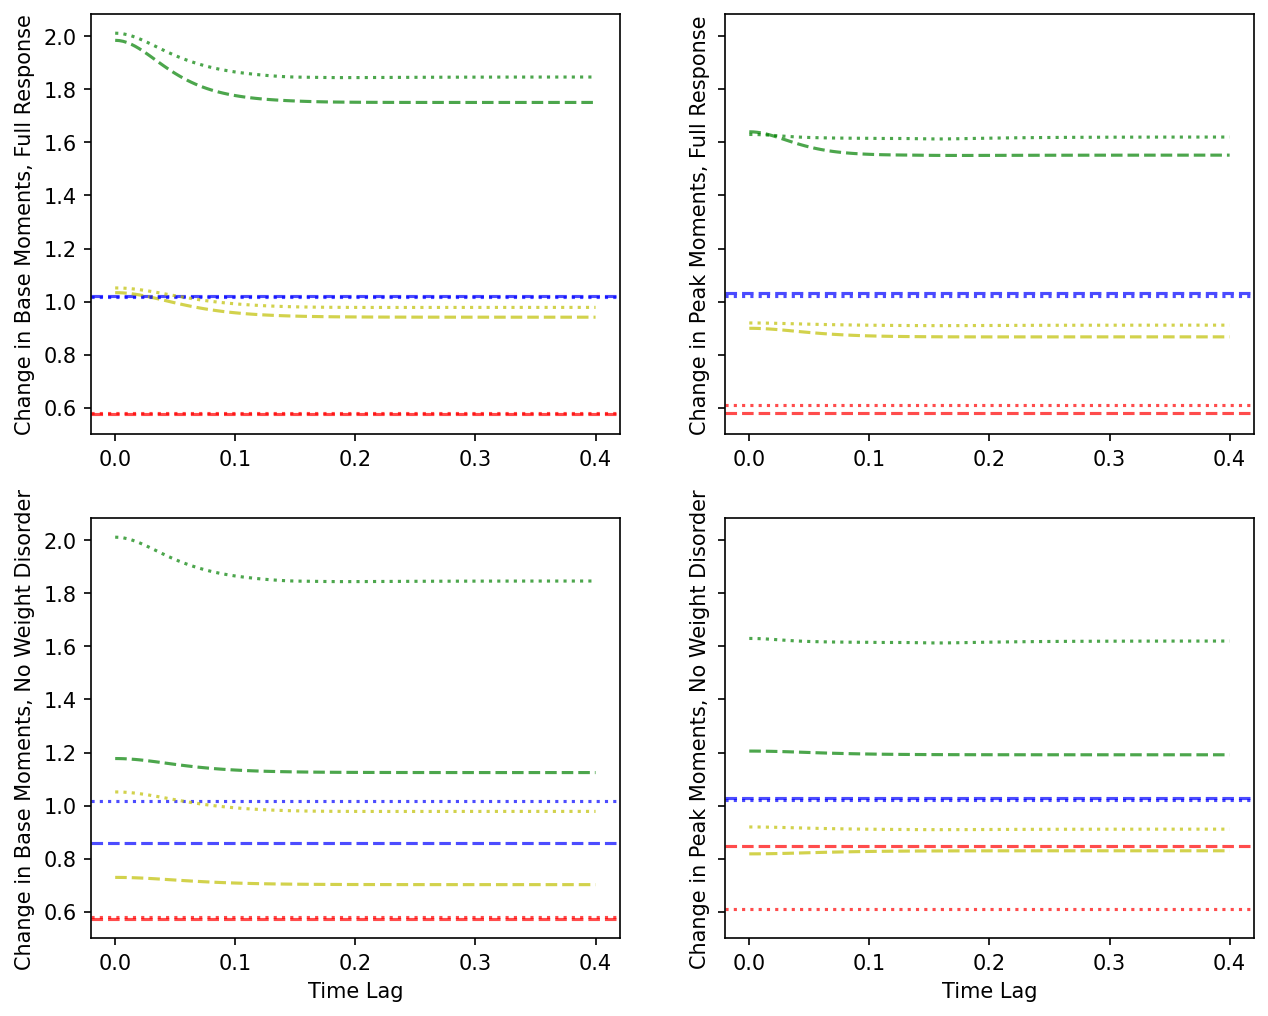

In [94]:
fig,axs= plt.subplots(2,2,figsize=(10,8),dpi=150,sharey=True)

axs[0,0].axhline(drbdξ[0]*δrX,c='r',ls='--',alpha=0.7)
axs[0,0].axhline(drbdξ[1]*δrX,c='b',ls='--',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(Crb[0] + dCrbdξ[0]*δrX) - np.sqrt(Crb[0]),c='y',ls='--',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(Crb[1] + dCrbdξ[1]*δrX) - np.sqrt(Crb[1]),c='g',ls='--',alpha=0.7)

axs[0,0].axhline(res_dict_pert['rb'][0] - rb[0],c='r',ls=':',alpha=0.7)
axs[0,0].axhline(res_dict_pert['rb'][1] - rb[1],c='b',ls=':',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(res_dict_pert['Crb'][0]) - np.sqrt(Crb[0]),c='y',ls=':',alpha=0.7)
axs[0,0].plot(ts,np.sqrt(res_dict_pert['Crb'][1]) - np.sqrt(Crb[1]),c='g',ls=':',alpha=0.7)

axs[0,1].axhline(drpdξ[0]*δrX,c='r',ls='--',alpha=0.7)
axs[0,1].axhline(drpdξ[1]*δrX,c='b',ls='--',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(Crp[0] + dCrpdξ[0]*δrX) - np.sqrt(Crp[0]),c='y',ls='--',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(Crp[1] + dCrpdξ[1]*δrX) - np.sqrt(Crp[1]),c='g',ls='--',alpha=0.7)

axs[0,1].axhline(res_dict_pert['rp'][0] - rp[0],c='r',ls=':',alpha=0.7)
axs[0,1].axhline(res_dict_pert['rp'][1] - rp[1],c='b',ls=':',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(res_dict_pert['Crp'][0]) - np.sqrt(Crp[0]),c='y',ls=':',alpha=0.7)
axs[0,1].plot(ts,np.sqrt(res_dict_pert['Crp'][1]) - np.sqrt(Crp[1]),c='g',ls=':',alpha=0.7)

axs[1,0].axhline(drbdξ0dis[0]*δrX,c='r',ls='--',alpha=0.7)
axs[1,0].axhline(drbdξ0dis[1]*δrX,c='b',ls='--',alpha=0.7)
axs[1,0].plot(ts,np.sqrt(Crb[0] + dCrbdξ0dis[0]*δrX) - np.sqrt(Crb[0]),c='y',ls='--',alpha=0.7)
axs[1,0].plot(ts,np.sqrt(Crb[1] + dCrbdξ0dis[1]*δrX) - np.sqrt(Crb[1]),c='g',ls='--',alpha=0.7)

axs[1,0].axhline(res_dict_pert['rb'][0] - rb[0],c='r',ls=':',alpha=0.7)
axs[1,0].axhline(res_dict_pert['rb'][1] - rb[1],c='b',ls=':',alpha=0.7)
axs[1,0].plot(ts,np.sqrt(res_dict_pert['Crb'][0]) - np.sqrt(Crb[0]),c='y',ls=':',alpha=0.7)
axs[1,0].plot(ts,np.sqrt(res_dict_pert['Crb'][1]) - np.sqrt(Crb[1]),c='g',ls=':',alpha=0.7)

axs[1,1].axhline(drpdξ0dis[0]*δrX,c='r',ls='--',alpha=0.7)
axs[1,1].axhline(drpdξ0dis[1]*δrX,c='b',ls='--',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(Crp[0] + dCrpdξ0dis[0]*δrX) - np.sqrt(Crp[0]),c='y',ls='--',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(Crp[1] + dCrpdξ0dis[1]*δrX) - np.sqrt(Crp[1]),c='g',ls='--',alpha=0.7)

axs[1,1].axhline(res_dict_pert['rp'][0] - rp[0],c='r',ls=':',alpha=0.7)
axs[1,1].axhline(res_dict_pert['rp'][1] - rp[1],c='b',ls=':',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(res_dict_pert['Crp'][0]) - np.sqrt(Crp[0]),c='y',ls=':',alpha=0.7)
axs[1,1].plot(ts,np.sqrt(res_dict_pert['Crp'][1]) - np.sqrt(Crp[1]),c='g',ls=':',alpha=0.7)

axs[1,0].set_xlabel('Time Lag')
axs[1,1].set_xlabel('Time Lag')
axs[0,0].set_ylabel('Change in Base Moments, Full Response')
axs[0,1].set_ylabel('Change in Peak Moments, Full Response')
axs[1,0].set_ylabel('Change in Base Moments, No Weight Disorder')
axs[1,1].set_ylabel('Change in Peak Moments, No Weight Disorder')

## Figure out which projections can be treated perturbatively

In [95]:
np.max(np.real(np.linalg.eig(np.linalg.inv(np.block([[Mbb,np.zeros_like(Mbp)],[Mpb,Mpp]]))@\
    np.block([[np.zeros_like(Mbb),Mbp],[np.zeros_like(Mpb),np.zeros_like(Mpp)]]))[0]))

0.0

In [96]:
np.max(np.real(np.linalg.eig(np.linalg.inv(np.block([[Mbb,np.zeros_like(Mbp)],[np.zeros_like(Mpb),Mpp]]))@\
    np.block([[np.zeros_like(Mbb),Mbp],[Mpb,np.zeros_like(Mpp)]]))[0]))

0.48378031491049345

# Calculate linear response with Opto Perturbation

In [270]:
reload(dmft)

Twrm = 1.2
Tsav = 0.4
dt = 0.01/5

# res_dict_init = dmft.run_first_stage_ring_dmft(prms,bX,aXs[-1]/bX,eX,'./../results',ri,Twrm,Tsav,dt,which='base',return_full=True)
# res_dict_pert = dmft.run_first_stage_ring_dmft(prms,bX,aXs[-1]/bX,eX,'./../results',ri,Twrm,Tsav,dt,which='opto',return_full=True)

with open('./../results/dmft_best_fit_id_None_c_{:d}'.format(5)+'.pkl','rb') as\
        handle:
    this_res_dict = pickle.load(handle)['dmft_res']
    res_dict_init = {key: this_res_dict[key][:2] for key in ['rb','rp','sr','Crb','Crp','sCr',
                                                            'mub','mup','Sigb','Sigp']}
    res_dict_pert = {key: this_res_dict[key][2:] for key in ['rb','rp','sr','Crb','Crp','sCr',
                                                            'mub','mup','Sigb','Sigp']}

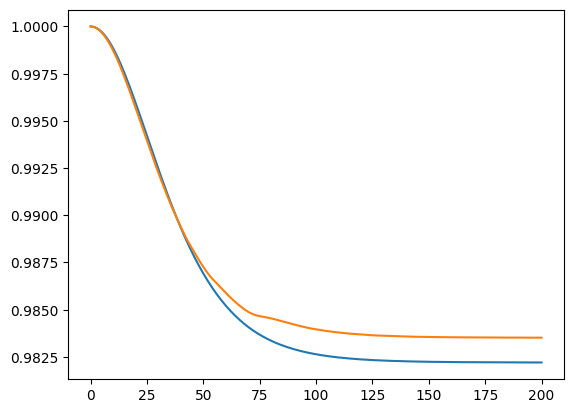

In [5]:
plt.plot((res_dict_init['sCr']/res_dict_init['sCr'][:,0:1]).T)

In [271]:
rvb = res_dict_init['rb']
rvp = res_dict_init['rp']
sr = res_dict_init['sr']
Crvb = res_dict_init['Crb']
Crvp = res_dict_init['Crp']
sCr = res_dict_init['sCr'][:,-1]

rob = res_dict_pert['rb']
rop = res_dict_pert['rp']
Crob = res_dict_pert['Crb']
Crop = res_dict_pert['Crp']

In [272]:
reload(dmft)

Twrm = 1.2
Tsav = 0.4
dt = 0.01/5

# res_dict_decoup = dmft.run_decoupled_two_site_dmft(prms,bX,aXs[-1]/bX,eX,'./../results',ri,Twrm,Tsav,dt,
#                                                    struct_dict=res_dict_init,which='base',return_full=True)
# with open('./decoup_resp.pkl','wb') as handle:
#     pickle.dump(res_dict_decoup,handle)
    
with open('./decoup_resp.pkl','rb') as handle:
    res_dict_decoup = pickle.load(handle)

In [273]:
rLb = res_dict_decoup['rb']
rLp = res_dict_decoup['rp']
CrLb = res_dict_decoup['Crb']
CrLp = res_dict_decoup['Crp']

δrb0 = rLb - rvb
δrp0 = rLp - rvp
δCrb0 = CrLb - Crvb
δCrp0 = CrLp - Crvp

In [274]:
print(δrb0)
print(res_dict_pert['rb'] - rvb)
print()
print(δrp0)
print(res_dict_pert['rp'] - rvp)
print()
print(δCrb0[:,-1])
print(res_dict_pert['Crb'][:,-1] - Crvb[:,-1])
print()
print(δCrp0[:,-1])
print(res_dict_pert['Crp'][:,-1] - Crvp[:,-1])

[3.3925238 5.5798035]
[3.319559 5.454092]

[5.5653305 2.8086739]
[0.01517487 3.945015  ]

[ 830.6201 1198.3119]
[ 830.677 1254.078]

[1627.8237  938.7134]
[ 932.0913 1432.9468]


In [275]:
FE,FI,ME,MI,CE,CI = dmft.base_itp_moments('./../results')
FL,ML,CL = dmft.opto_itp_moments('./../results',prms['L'],prms['CVL'])
    
def base_M(mui,Sigii,out):
    out[0] = ME(mui[0],Sigii[0])[0]
    out[1] = MI(mui[1],Sigii[1])[0]
    
def base_C(mui,Sigii,Sigij,out):
    out[0] = CE(mui[0],Sigii[0],Sigij[0])[0]
    out[1] = CI(mui[1],Sigii[1],Sigij[1])[0]

def opto_M(mui,Sigii,out):
    out[0] = ML(mui[0],Sigii[0])[0]
    out[1] = MI(mui[1],Sigii[1])[0]
    
def opto_C(mui,Sigii,Sigij,out):
    out[0] = CL(mui[0],Sigii[0],Sigij[0])[0]
    out[1] = CI(mui[1],Sigii[1],Sigij[1])[0]

tau = np.array([ri.tE,ri.tI],dtype=np.float32)
W = J*np.array([[1,-gE],[1./beta,-gI/beta]],dtype=np.float32)
Ks = np.array([K,K/4],dtype=np.float32)
H = bX*K*J*np.array([hE,hI/beta],dtype=np.float32)
eH = eX

muH = tau*H
SigH = (muH*eH)**2

muW = tau[:,None]*W*Ks
SigW = tau[:,None]**2*W**2*Ks

sW = np.array([[SoriE,SoriI],[SoriE,SoriI]],dtype=np.float32)
sW2 = sW**2
sWr = np.sqrt(sW2+sr**2)
sWCr = np.sqrt(sW2+sCr**2)

muWbb = (1 - dmft.struct_fact(180/2,sWr,sr,180)) * muW
muWbp = dmft.struct_fact(180/2,sWr,sr,180) * muW
muWpb = (1 - dmft.struct_fact(0,sWr,sr,180)) * muW
muWpp = dmft.struct_fact(0,sWr,sr,180) * muW

SigWbb = (1 - dmft.struct_fact(180/2,sWCr,sCr,180)) * SigW
SigWbp = dmft.struct_fact(180/2,sWCr,sCr,180) * SigW
SigWpb = (1 - dmft.struct_fact(0,sWCr,sCr,180)) * SigW
SigWpp = dmft.struct_fact(0,sWCr,sCr,180) * SigW

block_muW = np.block([
    [muWbb,muWbp],
    [muWpb,muWpp]
])
block_SigW = np.block([
    [SigWbb,SigWbp],
    [SigWpb,SigWpp]
])

block_mu = np.concatenate([res_dict_decoup['mub'],res_dict_decoup['mup']])
block_Sig = np.concatenate([res_dict_decoup['Sigb'],res_dict_decoup['Sigp']],0)

def block_base_M(mui,Sigii,out):
    out[0] = ME(mui[0],Sigii[0])[0]
    out[1] = MI(mui[1],Sigii[1])[0]
    out[2] = ME(mui[2],Sigii[2])[0]
    out[3] = MI(mui[3],Sigii[3])[0]
    
def block_base_C(mui,Sigii,Sigij,out):
    out[0] = CE(mui[0],Sigii[0],Sigij[0])[0]
    out[1] = CI(mui[1],Sigii[1],Sigij[1])[0]
    out[2] = CE(mui[2],Sigii[2],Sigij[2])[0]
    out[3] = CI(mui[3],Sigii[3],Sigij[3])[0]

def block_opto_M(mui,Sigii,out):
    out[0] = ML(mui[0],Sigii[0])[0]
    out[1] = MI(mui[1],Sigii[1])[0]
    out[2] = ML(mui[2],Sigii[2])[0]
    out[3] = MI(mui[3],Sigii[3])[0]
    
def block_opto_C(mui,Sigii,Sigij,out):
    out[0] = CL(mui[0],Sigii[0],Sigij[0])[0]
    out[1] = CI(mui[1],Sigii[1],Sigij[1])[0]
    out[2] = CL(mui[2],Sigii[2],Sigij[2])[0]
    out[3] = CI(mui[3],Sigii[3],Sigij[3])[0]

In [276]:
res_dict_lin_resp = dmft.lin_resp_mats(np.concatenate([tau,tau]),block_muW,block_SigW,
                                       np.zeros(4),np.zeros(4),block_opto_M,block_opto_C,Tsav,dt,
                                       block_mu,block_Sig)

A = res_dict_lin_resp['A']
B = res_dict_lin_resp['B']
C = res_dict_lin_resp['C']
D = res_dict_lin_resp['D']
D0dis = res_dict_lin_resp['D0dis'][:2,:,:2,:]

Abb,Abp,Apb,App = A[:2,  :2],  A[:2,  2:],  A[2:,  :2],  A[2:,  2:]
Bbb,Bbp,Bpb,Bpp = B[:2,  :2,:],B[:2,  2:,:],B[2:,  :2,:],B[2:,  2:,:]
Cbb,Cbp,Cpb,Cpp = C[:2,:,:2],  C[:2,:,2:],  C[2:,:,:2],  C[2:,:,2:]
Dbb,Dbp,Dpb,Dpp = D[:2,:,:2,:],D[:2,:,2:,:],D[2:,:,:2,:],D[2:,:,2:,:]

In [277]:
NP = res_dict_init['Sigb'].shape[0]
NT = res_dict_init['Sigb'].shape[1]

Mbb = np.block([[Abb,Bbb.reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
Mbp = np.block([[Abp,Bbp.reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
Mpb = np.block([[Apb,Bpb.reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
Mpp = np.block([[App,Bpp.reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),Dpp.reshape(NP*NT,NP*NT)]])

# Mbb0dis = np.block([[Abb,np.zeros_like(Bbb).reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),D0dis.reshape(NP*NT,NP*NT)]])
# Mbp0dis = np.block([[Abp,np.zeros_like(Bbp).reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),np.zeros_like(Dbp).reshape(NP*NT,NP*NT)]])
# Mpb0dis = np.block([[Apb,np.zeros_like(Bpb).reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),np.zeros_like(Dpb).reshape(NP*NT,NP*NT)]])
# Mpp0dis = np.block([[App,np.zeros_like(Bpp).reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),D0dis.reshape(NP*NT,NP*NT)]])

# Mbb0dis = np.block([[Abb,Bbb.reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
# Mbp0dis = np.block([[Abp,Bbp.reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
Mbb0dis = np.block([[Abb,np.zeros_like(Bbb).reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
Mbp0dis = np.block([[Abp,np.zeros_like(Bbp).reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
Mpb0dis = np.block([[Apb,np.zeros_like(Bpb).reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
Mpp0dis = np.block([[App,np.zeros_like(Bpp).reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),Dpp.reshape(NP*NT,NP*NT)]])

Mbb1dis = np.block([[np.zeros((NP,NP)),Bbb.reshape(NP,NP*NT)],[np.zeros((NP*NT,NP)),np.zeros((NP*NT,NP*NT))]])
Mbp1dis = np.block([[np.zeros((NP,NP)),Bbp.reshape(NP,NP*NT)],[np.zeros((NP*NT,NP)),np.zeros((NP*NT,NP*NT))]])
Mpb1dis = np.block([[np.zeros((NP,NP)),Bpb.reshape(NP,NP*NT)],[np.zeros((NP*NT,NP)),np.zeros((NP*NT,NP*NT))]])
Mpp1dis = np.block([[np.zeros((NP,NP)),Bpp.reshape(NP,NP*NT)],[np.zeros((NP*NT,NP)),np.zeros((NP*NT,NP*NT))]])

δmb0 = np.concatenate([δrb0,δCrb0.flatten()])
δmp0 = np.concatenate([δrp0,δCrp0.flatten()])

fb = Mbb@δmb0
fp = Mpp@δmp0

M = np.block([[Mbb,Mbp],[Mpb,Mpp]])
M0dis = np.block([[Mbb0dis,Mbp0dis],[Mpb0dis,Mpp0dis]])
f = np.concatenate([fb,fp])

# δm = np.linalg.solve(M,f)
δm = np.concatenate([δmb0-np.linalg.solve(Mbb,Mbp@δmp0),δmp0-np.linalg.solve(Mpp,Mpb@δmb0)])
# δm0dis = np.linalg.solve(M0dis,f)
δm0dis = np.concatenate([δmb0-np.linalg.solve(Mbb0dis,Mbp0dis@δmp0),δmp0-np.linalg.solve(Mpp0dis,Mpb0dis@δmb0)])

δmb = δm[:NP+NP*NT]
δmp = δm[NP+NP*NT:]

δmb0dis = δm0dis[:NP+NP*NT]
δmp0dis = δm0dis[NP+NP*NT:]

δrb = δmb[:NP]
δCrb = δmb[NP:].reshape(NP,NT)
δrp = δmp[:NP]
δCrp = δmp[NP:].reshape(NP,NT)

δrb0dis = δmb0dis[:NP]
δCrb0dis = δmb0dis[NP:].reshape(NP,NT)
δrp0dis = δmp0dis[:NP]
δCrp0dis = δmp0dis[NP:].reshape(NP,NT)

In [278]:
print(δmb0[:2])
print(δmp0[:2])
print()
print(δmb[:2])
print(δmp[:2])

[3.3925238 5.5798035]
[5.5653305 2.8086739]

[3.08063055 5.71821935]
[0.11370683 3.7389968 ]


In [279]:
np.max(np.abs(np.linalg.eig(np.linalg.inv(np.block([[Mbb,np.zeros_like(Mbp)],[Mpb,Mpp]]))@\
    np.block([[np.zeros_like(Mbb),Mbp],[np.zeros_like(Mpb),np.zeros_like(Mpp)]]))[0]))

0.30574130860463844

In [280]:
np.max(np.abs(np.linalg.eig(np.linalg.inv(np.block([[Mbb0dis,np.zeros_like(Mbp0dis)],[Mpb0dis,Mpp0dis]]))@\
    np.block([[np.zeros_like(Mbb0dis),Mbp0dis],[np.zeros_like(Mpb0dis),np.zeros_like(Mpp0dis)]]))[0]))

2.1823548893562883

In [16]:
np.max(np.abs(np.linalg.eig(np.linalg.inv(np.block([[Mbb,np.zeros_like(Mbp)],[np.zeros_like(Mpb),Mpp]]))@\
    np.block([[np.zeros_like(Mbb),Mbp],[Mpb,np.zeros_like(Mpp)]]))[0]))

0.5529387928193793

In [281]:
sim_dr = np.array([2.8632733 , 0.46012648, 0.31349788, 0.13982971, 0.05703189, 0.02666332])
sim_dstdr = np.array([15.64064821, 10.74145532,  9.67937987,  8.40606301,  7.96817521, 7.86632242])

sim_rvE = np.array([68.97733867, 55.62796466, 30.52583861, 12.9365711 ,  6.23059766,
        5.02963256,  5.67675831,  7.122793  ,  9.31705425, 10.7507899 ,
       11.62559419, 10.84714221,  9.19416534,  7.4510832 ,  5.80674291,
        5.05020631,  6.43007453, 12.91497832, 30.21023504, 55.28638687])
sim_rvI = np.array([42.22267755, 44.2655882 , 39.85187656, 35.78976117, 32.5092976 ,
       29.77520101, 26.33714218, 24.00078065, 20.9543997 , 19.96423943,
       18.52759328, 19.79796247, 21.77673685, 23.3321855 , 26.42613705,
       29.03981693, 33.32299897, 35.82229191, 40.3377957 , 42.45983409])

sim_roE = np.array([68.12356329, 55.62542769, 32.76158408, 16.77672343, 10.0900948 ,
        9.2486116 ,  9.66629388, 11.08456271, 12.45318941, 13.71325399,
       14.07155846, 13.78208456, 12.60230108, 11.06283618,  9.65569521,
        9.04009163, 10.13569005, 16.84672337, 32.28955217, 55.36414603])
sim_roI = np.array([45.77109566, 47.5042508 , 43.77013266, 40.34887994, 37.1388502 ,
       34.27780032, 32.25961519, 28.43824625, 26.22238183, 25.52519509,
       24.38144881, 25.525264  , 27.13649654, 28.63389435, 31.0277583 ,
       33.99121783, 37.36871739, 40.291363  , 43.58412479, 47.81088607])

sim_std_rvE = np.array([42.10519423, 39.7132907 , 31.28676259, 19.5746686 , 12.2799577 ,
       10.32652004, 10.61166957, 11.45794762, 12.91249399, 13.45310985,
       14.06741991, 13.61160906, 12.69215476, 11.76546235, 10.66237776,
       10.4683471 , 12.68349306, 19.54980369, 30.82531814, 39.5125641 ])
sim_std_rvI = np.array([66.02189259, 67.16863276, 63.95849201, 59.38342017, 54.75481557,
       50.28232267, 46.85709882, 43.36562633, 38.46335062, 36.44943882,
       35.38743924, 37.15797238, 38.92180719, 41.84712986, 46.35560574,
       50.79675898, 56.18926841, 59.45078842, 64.18852714, 66.45435967])

sim_std_roE = np.array([51.29680636, 48.58114268, 42.72370156, 34.13558415, 29.29143991,
       28.74414667, 29.53162426, 30.70441223, 30.61329712, 32.23168274,
       31.3706999 , 32.11373282, 31.18344056, 29.94073522, 28.45273394,
       28.30573962, 27.86295617, 34.37949692, 41.90246766, 49.28480156])
sim_std_roI = np.array([72.49110033, 73.29698759, 70.69122907, 66.79029227, 63.46540254,
       59.01493962, 56.13497679, 51.70726138, 49.19097429, 47.59169756,
       46.18178629, 47.39486643, 49.50127206, 52.33215921, 55.22989533,
       59.41658148, 63.60638401, 66.1437379 , 69.65726529, 73.03645928])

In [282]:
nori = 20

oris = np.arange(nori//2+1) * 90/(nori/2)
def gauss(x,b,p,s):
    return b + (p-b)*dmft.basesubwrapnorm(x,s)

rvE = gauss(oris,rvb[0],rvp[0],sr[0])
rvI = gauss(oris,rvb[1],rvp[1],sr[1])
roE = gauss(oris,rob[0],rop[0],sr[0])
roI = gauss(oris,rob[1],rop[1],sr[1])

drE0 = gauss(oris,δrb0[0],δrp0[0],sr[0])
drI0 = gauss(oris,δrb0[1],δrp0[1],sr[1])
drE = gauss(oris,δrb[0],δrp[0],sr[0])
drI = gauss(oris,δrb[1],δrp[1],sr[1])
drE0dis = gauss(oris,δrb0dis[0],δrp0dis[0],sr[0])
drI0dis = gauss(oris,δrb0dis[1],δrp0dis[1],sr[1])

CrvE = gauss(oris,dmft.grid_stat(np.mean,Crvb[0:0+1],1,dt),dmft.grid_stat(np.mean,Crvp[0:0+1],1,dt),sCr[0])
CrvI = gauss(oris,dmft.grid_stat(np.mean,Crvb[1:1+1],1,dt),dmft.grid_stat(np.mean,Crvp[1:1+1],1,dt),sCr[1])
CroE = gauss(oris,dmft.grid_stat(np.mean,Crob[0:0+1],1,dt),dmft.grid_stat(np.mean,Crop[0:0+1],1,dt),sCr[0])
CroI = gauss(oris,dmft.grid_stat(np.mean,Crob[1:1+1],1,dt),dmft.grid_stat(np.mean,Crop[1:1+1],1,dt),sCr[1])

dCrE0 = gauss(oris,dmft.grid_stat(np.mean,δCrb0[0:0+1],1,dt),dmft.grid_stat(np.mean,δCrp0[0:0+1],1,dt),sCr[0])
dCrI0 = gauss(oris,dmft.grid_stat(np.mean,δCrb0[1:1+1],1,dt),dmft.grid_stat(np.mean,δCrp0[1:1+1],1,dt),sCr[1])
dCrE = gauss(oris,dmft.grid_stat(np.mean,δCrb[0:0+1],1,dt),
              dmft.grid_stat(np.mean,δCrp[0:0+1],1,dt),sCr[0])
dCrI = gauss(oris,dmft.grid_stat(np.mean,δCrb[1:1+1],1,dt),
              dmft.grid_stat(np.mean,δCrp[1:1+1],1,dt),sCr[1])
dCrE0dis = gauss(oris,dmft.grid_stat(np.mean,δCrb0dis[0:0+1],1,dt),
              dmft.grid_stat(np.mean,δCrp0dis[0:0+1],1,dt),sCr[0])
dCrI0dis = gauss(oris,dmft.grid_stat(np.mean,δCrb0dis[1:1+1],1,dt),
              dmft.grid_stat(np.mean,δCrp0dis[1:1+1],1,dt),sCr[1])

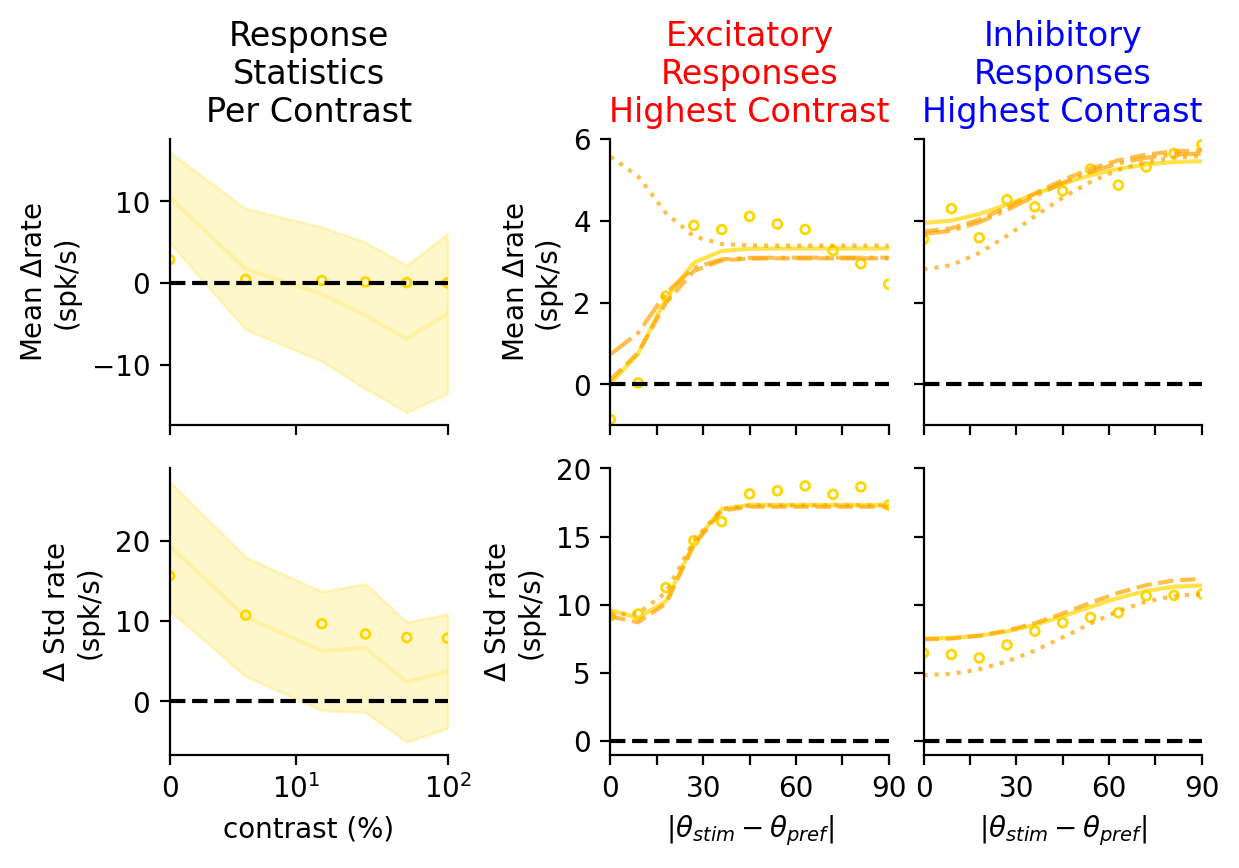

In [19]:
with open('./data_moments'+'.pkl', 'rb') as handle:
    data_preds = np.transpose(pickle.load(handle)[1],(1,0,2))
data_dr = np.concatenate([data_preds[:,1,0:1]-data_preds[:,0,0:1],
                          np.sqrt(data_preds[:,1,1:2]**2+data_preds[:,0,1:2]**2)],-1)
data_dstdr = np.concatenate([data_preds[:,3,0:1]-data_preds[:,2,0:1],
                             np.sqrt(data_preds[:,3,1:2]**2+data_preds[:,2,1:2]**2)],-1)
with open('./data_contrasts'+'.pkl', 'rb') as handle:
    cons = pickle.load(handle)[1]

def abs_ori(A):
    return 0.5*(A[:nori//2+1] + np.concatenate((A[0:1],A[-1:nori//2-1:-1])))

fig,axs = plt.subplots(2,4,figsize=(2*3.33,2*2),dpi=200,sharex='col',width_ratios=(3,1,3,3))
fig.subplots_adjust(hspace=0.15,wspace=0.15)
for i in range(2):
    axs[i,1].set_axis_off()
    axs[i,2].yaxis.set_tick_params(which='both',labelleft=True)
    axs[i,3].yaxis.set_tick_params(which='both',labelleft=False)
axs = axs[:,[0,2,3]]

axs[0,0].plot(cons,data_dr[:,0],color='gold',alpha=0.2)
axs[0,0].fill_between(cons,data_dr[:,0]-data_dr[:,1],data_dr[:,0]+data_dr[:,1],color='gold',alpha=0.2)
axs[0,0].scatter(cons,sim_dr,edgecolors='gold',facecolors='none',marker='o',s=10)
axs[0,1].plot(oris,roE-rvE,c='gold',ls='-',alpha=0.7,label='a')
axs[0,1].plot(oris,drE0,c='orange',ls=':',alpha=0.7,label='a')
axs[0,1].plot(oris,drE,c='orange',ls='--',alpha=0.7,label='a')
axs[0,1].plot(oris,drE0dis,c='orange',ls='-.',alpha=0.7,label='a')
# axs[0,1].legend()
axs[0,1].scatter(oris,abs_ori(sim_roE-sim_rvE),edgecolors='gold',facecolors='none',marker='o',s=10)
axs[0,2].plot(oris,roI-rvI,c='gold',ls='-',alpha=0.7)
axs[0,2].plot(oris,drI0,c='orange',ls=':',alpha=0.7)
axs[0,2].plot(oris,drI,c='orange',ls='--',alpha=0.7)
axs[0,2].plot(oris,drI0dis,c='orange',ls='-.',alpha=0.7)
axs[0,2].scatter(oris,abs_ori(sim_roI-sim_rvI),edgecolors='gold',facecolors='none',marker='o',s=10)
axs[1,0].plot(cons,data_dstdr[:,0],color='gold',alpha=0.2)
axs[1,0].fill_between(cons,data_dstdr[:,0]-data_dstdr[:,1],data_dstdr[:,0]+data_dstdr[:,1],color='gold',alpha=0.2)
axs[1,0].scatter(cons,sim_dstdr,edgecolors='gold',facecolors='none',marker='o',s=10)
axs[1,1].plot(oris,np.sqrt(CroE-roE**2)-np.sqrt(CrvE-rvE**2),c='gold',ls='-',alpha=0.7)
axs[1,1].plot(oris,np.sqrt(CrvE+dCrE0-(rvE+drE0)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls=':',alpha=0.7)
axs[1,1].plot(oris,np.sqrt(CrvE+dCrE-(rvE+drE)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls='--',alpha=0.7)
# axs[1,1].plot(oris,np.sqrt(CrvE+dCrE0dis-(rvE+drE0dis)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls='-.',alpha=0.7)
axs[1,1].scatter(oris,abs_ori(sim_std_roE-sim_std_rvE),edgecolors='gold',facecolors='none',marker='o',s=10)
axs[1,2].plot(oris,np.sqrt(CroI-roI**2)-np.sqrt(CrvI-rvI**2),c='gold',ls='-',alpha=0.7)
axs[1,2].plot(oris,np.sqrt(CrvI+dCrI0-(rvI+drI0)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls=':',alpha=0.7)
axs[1,2].plot(oris,np.sqrt(CrvI+dCrI-(rvI+drI)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls='--',alpha=0.7)
# axs[1,2].plot(oris,np.sqrt(CrvI+dCrI0dis-(rvI+drI0dis)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls='-.',alpha=0.7)
axs[1,2].scatter(oris,abs_ori(sim_std_roI-sim_std_rvI),edgecolors='gold',facecolors='none',marker='o',s=10)

for i in range(2):
    for j in range(3):
        axs[i,j].axhline(0,c='k',ls='--')
    
# axs[0,1].legend()
# axs[1,1].legend()
# axs[2,1].legend()

for ax in axs.flat:
    ax.spines[['right', 'top']].set_visible(False)

axs[0,0].set_xscale('symlog', linthresh=12)
nticks = 7
ticks = np.array(['{:.0f}'.format(ori) for ori in np.linspace(0,90,nticks)])
ticks[1::2] = ''
for i in range(1,3):
    axs[1,i].set_xticks(np.linspace(0,90,7),ticks)

axs[0,0].set_xlim(0,100)
axs[0,1].set_xlim(0,90)
axs[0,2].set_xlim(0,90)
for i in range(1,3):
    axs[0,i].set_ylim(-1,6)
    axs[1,i].set_ylim(-1,20)

axs[1,0].set_xlabel('contrast (%)')
axs[1,1].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')
axs[1,2].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')

for i in range(2):
    axs[0,i].set_ylabel(r'Mean $\Delta$rate'+'\n(spk/s)')
    axs[1,i].set_ylabel(r'$\Delta$ Std rate'+'\n(spk/s)')

axs[0,0].set_title('Response\nStatistics\nPer Contrast',color='k')
axs[0,1].set_title('Excitatory\nResponses\nHighest Contrast',color='r')
axs[0,2].set_title('Inhibitory\nResponses\nHighest Contrast',color='b')

# fig.tight_layout()
fig.savefig('./../plots/delta_rate_lin_resp_test.pdf')

# Try Gaussian Perturbation

In [124]:
dmuHbdξ = np.array([L*1e-3,0],dtype=np.float32)# + dmuWbpdsr*dsr/δrX@rp + dmuWbbdsr*dsr/δrX@rb
dmuHpdξ = np.array([L*1e-3,0],dtype=np.float32)# + dmuWppdsr*dsr/δrX@rp + dmuWpbdsr*dsr/δrX@rb
dSigHbdξ = (2*muHb*dmuHbdξ*eH**2 + (dmuHbdξ*CVL)**2)[:,None]# + dSigWbpdsCr*dsCr/δrX@Crp + dSigWbbdsCr*dsCr/δrX@Crb
dSigHpdξ = (2*muHp*dmuHpdξ*eH**2 + (dmuHbdξ*CVL)**2)[:,None]# + dSigWppdsCr*dsCr/δrX@Crp + dSigWpbdsCr*dsCr/δrX@Crb

block_dmuHdξ = np.concatenate([dmuHbdξ,dmuHpdξ])
block_dSigHdξ = np.concatenate([dSigHbdξ,dSigHpdξ],0)

block_mu = np.concatenate([res_dict_init['mub'],res_dict_init['mup']])
block_Sig = np.concatenate([res_dict_init['Sigb'],res_dict_init['Sigp']],0)

res_dict_lin_resp = dmft.lin_resp_mats(np.concatenate([tau,tau]),block_muW,block_SigW,
                                       block_dmuHdξ,block_dSigHdξ,block_base_M,block_base_C,Tsav,dt,
                                       block_mu,block_Sig)

A = res_dict_lin_resp['A']
B = res_dict_lin_resp['B']
C = res_dict_lin_resp['C']
D = res_dict_lin_resp['D']
D0dis = res_dict_lin_resp['D0dis'][:2,:,:2,:]
# E = res_dict_lin_resp['E']
# F = res_dict_lin_resp['F']

Abb,Abp,Apb,App = A[:2,  :2],  A[:2,  2:],  A[2:,  :2],  A[2:,  2:]
Bbb,Bbp,Bpb,Bpp = B[:2,  :2,:],B[:2,  2:,:],B[2:,  :2,:],B[2:,  2:,:]
Cbb,Cbp,Cpb,Cpp = C[:2,:,:2],  C[:2,:,2:],  C[2:,:,:2],  C[2:,:,2:]
Dbb,Dbp,Dpb,Dpp = D[:2,:,:2,:],D[:2,:,2:,:],D[2:,:,:2,:],D[2:,:,2:,:]
# Eb,Ep = E[:2],  E[2:]
# Fb,Fp = F[:2,:],F[2:,:]

Mbb = np.block([[Abb,Bbb.reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
Mbp = np.block([[Abp,Bbp.reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
Mpb = np.block([[Apb,Bpb.reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
Mpp = np.block([[App,Bpp.reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),Dpp.reshape(NP*NT,NP*NT)]])
# fb = np.concatenate([Eb,Fb.flatten()])
# fp = np.concatenate([Ep,Fp.flatten()])

δmb0 = np.concatenate([δrb0,δCrb0.flatten()])
δmp0 = np.concatenate([δrp0,δCrp0.flatten()])

fb = Mbb@δmb0
fp = Mpp@δmp0

Eb = fb[:NP]
Fb = fb[NP:].reshape((NP,NT))
Ep = fp[:NP]
Fp = fp[NP:].reshape((NP,NT))

E = np.concatenate([Eb,Ep])
F = np.concatenate([Fb,Fp],0)

Mdphi = res_dict_lin_resp['Mdphi']
Md2phi = res_dict_lin_resp['Md2phi']
Rdphi = res_dict_lin_resp['Rdphi']
Rd2phi = res_dict_lin_resp['Rd2phi']
Cdphi = res_dict_lin_resp['Cdphi']

M = np.block([[Mbb,Mbp],[Mpb,Mpp]])
f = np.concatenate([fb,fp])

In [125]:
reload(dmft)

res_dict_lin_resp = dmft.lin_resp_mats(np.concatenate([tau,tau]),block_muW,block_SigW,
                                       block_dmuHdξ,block_dSigHdξ,block_base_M,block_base_C,Tsav,dt,
                                       block_mu,block_Sig)

res_dict_opto_lin_resp = dmft.lin_resp_mats(np.concatenate([tau,tau]),block_muW,block_SigW,
                                       block_dmuHdξ,block_dSigHdξ,block_opto_M,block_opto_C,Tsav,dt,
                                       block_mu,block_Sig)

In [126]:
print(res_dict_opto_lin_resp['Mphi']-res_dict_lin_resp['Mphi'])
print(res_dict_opto_lin_resp['Mdphi']-res_dict_lin_resp['Mdphi'])
print(res_dict_opto_lin_resp['Md2phi']-res_dict_lin_resp['Md2phi'])
print(res_dict_opto_lin_resp['Rdphi'][:,-1]-res_dict_lin_resp['Rdphi'][:,-1])
print(res_dict_opto_lin_resp['Rd2phi'][:,-1]-res_dict_lin_resp['Rd2phi'][:,-1])
print(res_dict_opto_lin_resp['Cphi'][:,-1]-res_dict_lin_resp['Cphi'][:,-1])
print(res_dict_opto_lin_resp['Cdphi'][:,-1]-res_dict_lin_resp['Cdphi'][:,-1])

Eeff = res_dict_opto_lin_resp['Mphi']-res_dict_lin_resp['Mphi']
Feff = res_dict_opto_lin_resp['Cphi']-res_dict_lin_resp['Cphi']
Eeffb,Eeffp = Eeff[:2],  Eeff[2:]
Feffb,Feffp = Feff[:2,:],Feff[2:,:]
feffb = np.concatenate([Eeffb,Feffb.flatten()])
feffp = np.concatenate([Eeffp,Feffp.flatten()])
feff = np.concatenate([feffb,feffp])

feffmat = np.block([
    [np.ones((1,1)),np.zeros((1,1)),np.zeros((1,1)),np.zeros((1,1))],
    [np.zeros((1,1)),np.ones((1,1)),np.zeros((1,1)),np.zeros((1,1))],
    [np.zeros((NT,1)),np.zeros((NT,1)),np.ones((NT,1)),np.zeros((NT,1))],
    [np.zeros((NT,1)),np.zeros((NT,1)),np.zeros((NT,1)),np.ones((NT,1))]
])

[ 9.9049835  0.        13.20253    0.       ]
[363.45483   0.       32.00537   0.     ]
[ -2861.0234      0.     -10681.152       0.    ]
[27955.514     0.    28496.094     0.   ]
[   7433.14001391       0.         -543038.51592929       0.        ]
[1204.3297    0.     2623.5366    0.    ]
[1146089.53576093       0.           59255.42783529       0.        ]


In [127]:
fmat = np.block([
    [np.diag(Mdphi),0.5*np.diag(Md2phi)],
    [2*(np.eye(4)[:,:,None]*Rdphi[None,:,:]).reshape(2*NP,2*NP*NT).T,
     (np.eye(4)[:,:,None]*(Rd2phi+Cdphi)[None,:,:]).reshape(2*NP,2*NP*NT).T]])
fbmat = np.block([
    [np.diag(Mdphi[:2]),0.5*np.diag(Md2phi[:2])],
    [2*(np.eye(2)[:,:,None]*Rdphi[None,:2,:]).reshape(NP,NP*NT).T,
     (np.eye(2)[:,:,None]*(Rd2phi+Cdphi)[None,:2,:]).reshape(NP,NP*NT).T]])
fpmat = np.block([
    [np.diag(Mdphi[2:]),0.5*np.diag(Md2phi[2:])],
    [2*(np.eye(2)[:,:,None]*Rdphi[None,2:,:]).reshape(NP,NP*NT).T,
     (np.eye(2)[:,:,None]*(Rd2phi+Cdphi)[None,2:,:]).reshape(NP,NP*NT).T]])
rescale = np.concatenate([np.ones(4),1/100*np.ones(4*NT)])
fpermmat = np.block([
    [np.eye(2),         np.zeros((2,2)),   np.zeros((2,2*NT)),   np.zeros((2,2*NT))   ],
    [np.zeros((2*NT,2)),np.zeros((2*NT,2)),np.eye(2*NT),         np.zeros((2*NT,2*NT))],
    [np.zeros((2,2)),   np.eye(2),         np.zeros((2,2*NT)),   np.zeros((2,2*NT))   ],
    [np.zeros((2*NT,2)),np.zeros((2*NT,2)),np.zeros((2*NT,2*NT)),np.eye(2*NT)         ]
])

eff_inp,eff_res,_,_ = np.linalg.lstsq(rescale[:,None]*fmat,rescale*np.concatenate([E,F.flatten()]),
                                        rcond=None)

Eonly_mask = np.array([
    [1,0,0,0],
    [0,0,0,0],
    [0,1,0,0],
    [0,0,0,0],
    [0,0,1,0],
    [0,0,0,0],
    [0,0,0,1],
    [0,0,0,0]
])
homog_mask = np.array([
    [1,0],
    [0,0],
    [1,0],
    [0,0],
    [0,1],
    [0,0],
    [0,1],
    [0,0]
])

eff_Einp,eff_Eres,_,_ = np.linalg.lstsq(rescale[:,None]*fmat@Eonly_mask,rescale*np.concatenate([E,F.flatten()]),
                                        rcond=None)
eff_hinp,eff_hres,_,_ = np.linalg.lstsq(rescale[:,None]*fmat@homog_mask,rescale*np.concatenate([E,F.flatten()]),
                                        rcond=None)

print(eff_inp,eff_res)
print(eff_Einp,eff_Eres)
print(eff_hinp,eff_hres)
print([1e-3*L,(1e-3*L*CVL)**2])

print()
print(E)
print((fmat@eff_inp)[:4])
print((fmat@Eonly_mask@eff_Einp)[:4])
print((fmat@homog_mask@eff_hinp)[:4])

print()
print(F[:,(0,-1)])
print((fmat@eff_inp)[4:].reshape((4,NT))[:,(0,-1)])
print((fmat@Eonly_mask@eff_Einp)[4:].reshape((4,NT))[:,(0,-1)])
print((fmat@homog_mask@eff_hinp)[4:].reshape((4,NT))[:,(0,-1)])

[-1.14236713e-02 -1.69091460e-03  4.46011620e-03 -9.10810531e-04
  4.58318247e-04  3.45397845e-05  1.25869981e-04  4.60459645e-05] [0.77714099]
[-0.01142367  0.00446012  0.00045832  0.00012587] [128.6869842]
[0.00165306 0.00027646] [199.47812363]
[0.005482675876659675, 0.00031824888898779086]

[ 8.87138399 -1.18358861 13.16582916 -0.22529848]
[ 8.95518605 -1.26590444 13.47043921 -0.57245969]
[ 8.95518605  0.         13.47043921  0.        ]
[14.91828328  0.          8.58677434  0.        ]

[[1007.24081882  973.09281346]
 [-112.08877629  -67.96609967]
 [2542.27870641 2539.2891486 ]
 [ -44.88521878  -11.9242695 ]]
[[1000.85712422  974.02032022]
 [-112.72633977  -68.36330846]
 [2528.92579439 2541.68086037]
 [ -43.16413713  -12.70118639]]
[[1000.85712422  974.02032022]
 [   0.            0.        ]
 [2528.92579439 2541.68086037]
 [   0.            0.        ]]
[[1038.94444387  957.3985302 ]
 [   0.            0.        ]
 [2483.86756357 2553.21366786]
 [   0.            0.        ]]


In [128]:
δmb = np.linalg.solve(Mbb,fb)
δmp = np.linalg.solve(Mpp,fp)

δrbdc = δmb[:NP]
δCrbdc = δmb[NP:].reshape(NP,NT)
δrpdc = δmp[:NP]
δCrpdc = δmp[NP:].reshape(NP,NT)

δmb = np.linalg.solve(Mbb,(fpermmat@fmat@eff_inp)[:2+2*NT])
δmp = np.linalg.solve(Mpp,(fpermmat@fmat@eff_inp)[2+2*NT:])

δrbdc_eff_inp = δmb[:NP]
δCrbdc_eff_inp = δmb[NP:].reshape(NP,NT)
δrpdc_eff_inp = δmp[:NP]
δCrpdc_eff_inp = δmp[NP:].reshape(NP,NT)

# δmb = np.linalg.solve(Mbb,(fpermmat@fmat@Eonly_mask@eff_Einp)[:2+2*NT])
# δmp = np.linalg.solve(Mpp,(fpermmat@fmat@Eonly_mask@eff_Einp)[2+2*NT:])
δmb = np.linalg.solve(Mbb,feffb)
δmp = np.linalg.solve(Mpp,feffp)

δrbdc_eff_Einp = δmb[:NP]
δCrbdc_eff_Einp = δmb[NP:].reshape(NP,NT)
δrpdc_eff_Einp = δmp[:NP]
δCrpdc_eff_Einp = δmp[NP:].reshape(NP,NT)

δmb = np.linalg.solve(Mbb,(fpermmat@fmat@homog_mask@eff_hinp)[:2+2*NT])
δmp = np.linalg.solve(Mpp,(fpermmat@fmat@homog_mask@eff_hinp)[2+2*NT:])

δrbdc_eff_hinp = δmb[:NP]
δCrbdc_eff_hinp = δmb[NP:].reshape(NP,NT)
δrpdc_eff_hinp = δmp[:NP]
δCrpdc_eff_hinp = δmp[NP:].reshape(NP,NT)

In [129]:
δm = np.linalg.solve(M,f)

δmb = δm[:NP+NP*NT]
δmp = δm[NP+NP*NT:]

δrb = δmb[:NP]
δCrb = δmb[NP:].reshape(NP,NT)
δrp = δmp[:NP]
δCrp = δmp[NP:].reshape(NP,NT)

δm = np.linalg.solve(M,fpermmat@fmat@eff_inp)

δmb = δm[:NP+NP*NT]
δmp = δm[NP+NP*NT:]

δrb_eff_inp = δmb[:NP]
δCrb_eff_inp = δmb[NP:].reshape(NP,NT)
δrp_eff_inp = δmp[:NP]
δCrp_eff_inp = δmp[NP:].reshape(NP,NT)

δm = np.linalg.solve(M,fpermmat@fmat@Eonly_mask@eff_Einp)

δmb = δm[:NP+NP*NT]
δmp = δm[NP+NP*NT:]

δrb_eff_Einp = δmb[:NP]
δCrb_eff_Einp = δmb[NP:].reshape(NP,NT)
δrp_eff_Einp = δmp[:NP]
δCrp_eff_Einp = δmp[NP:].reshape(NP,NT)

δm = np.linalg.solve(M,fpermmat@fmat@homog_mask@eff_hinp)

δmb = δm[:NP+NP*NT]
δmp = δm[NP+NP*NT:]

δrb_eff_hinp = δmb[:NP]
δCrb_eff_hinp = δmb[NP:].reshape(NP,NT)
δrp_eff_hinp = δmp[:NP]
δCrp_eff_hinp = δmp[NP:].reshape(NP,NT)

In [130]:
print(δrb0)
print(res_dict_pert['rb'] - rvb)
print()
print(δrp0)
print(res_dict_pert['rp'] - rvp)
print()
print(δCrb0[:,-1])
print(res_dict_pert['Crb'][:,-1] - Crvb[:,-1])
print()
print(δCrp0[:,-1])
print(res_dict_pert['Crp'][:,-1] - Crvp[:,-1])

[3.3925238 5.5798035]
[3.319559 5.454092]

[5.5653305 2.8086739]
[0.01517487 3.945015  ]

[ 830.6201 1198.3119]
[ 830.677 1254.078]

[1627.8237  938.7134]
[ 932.0913 1432.9468]


In [131]:
print(δrb0)
print(δrbdc)
print(δrbdc_eff_inp)
print(δrbdc_eff_Einp)
print(δrbdc_eff_hinp)
print()
print(δrb)
print(δrb_eff_inp)
print(δrb_eff_Einp)
print(δrb_eff_hinp)
print()
print(δrp0)
print(δrpdc)
print(δrpdc_eff_inp)
print(δrpdc_eff_Einp)
print(δrpdc_eff_hinp)
print()
print(δrp)
print(δrp_eff_inp)
print(δrp_eff_Einp)
print(δrp_eff_hinp)
print()
print(δCrb0[:,-1])
print(δCrbdc[:,-1])
print(δCrbdc_eff_inp[:,-1])
print(δCrbdc_eff_Einp[:,-1])
print(δCrbdc_eff_hinp[:,-1])
print()
print(δCrb[:,-1])
print(δCrb_eff_inp[:,-1])
print(δCrb_eff_Einp[:,-1])
print(δCrb_eff_hinp[:,-1])
print()
print(δCrp0[:,-1])
print(δCrpdc[:,-1])
print(δCrpdc_eff_inp[:,-1])
print(δCrpdc_eff_Einp[:,-1])
print(δCrpdc_eff_hinp[:,-1])
print()
print(δCrp[:,-1])
print(δCrp_eff_inp[:,-1])
print(δCrp_eff_Einp[:,-1])
print(δCrp_eff_hinp[:,-1])

[3.3925238 5.5798035]
[3.39252377 5.57980347]
[3.43863774 5.64716335]
[3.57906955 6.12842834]
[5.66407339 9.05591503]

[3.33535708 5.37679139]
[3.37492713 5.45236081]
[3.20311366 5.32398281]
[5.91211916 8.55276608]

[5.5653305 2.8086739]
[5.56533051 2.80867386]
[5.75097346 2.88500203]
[5.5020081  2.81428436]
[3.43320241 1.83420209]

[0.0444095  3.71108018]
[0.16781252 3.79639684]
[0.33764188 3.70736435]
[-5.79864481  3.58403668]

[ 830.6201 1198.3119]
[ 830.62011719 1198.31188965]
[ 831.43861123 1222.75087177]
[1029.18501628 1214.08546666]
[ 670.61937447 1438.55425771]

[ 844.5629552 1310.6514696]
[ 845.49183236 1337.46203213]
[ 822.64068685 1130.81618626]
[ 686.76353822 1444.1937442 ]

[1627.8237  938.7134]
[1627.82373047  938.71337891]
[1628.39568584 1033.90923157]
[1667.25332537  821.98260376]
[1941.91728248  648.66180629]

[1004.16864829 1517.54473234]
[ 997.243899   1617.09677422]
[ 946.63686889 1321.2253797 ]
[ 728.48071362 1113.20443484]


In [132]:
sim_dr = np.array([2.8632733 , 0.46012648, 0.31349788, 0.13982971, 0.05703189, 0.02666332])
sim_dstdr = np.array([15.64064821, 10.74145532,  9.67937987,  8.40606301,  7.96817521, 7.86632242])

sim_rvE = np.array([68.97733867, 55.62796466, 30.52583861, 12.9365711 ,  6.23059766,
        5.02963256,  5.67675831,  7.122793  ,  9.31705425, 10.7507899 ,
       11.62559419, 10.84714221,  9.19416534,  7.4510832 ,  5.80674291,
        5.05020631,  6.43007453, 12.91497832, 30.21023504, 55.28638687])
sim_rvI = np.array([42.22267755, 44.2655882 , 39.85187656, 35.78976117, 32.5092976 ,
       29.77520101, 26.33714218, 24.00078065, 20.9543997 , 19.96423943,
       18.52759328, 19.79796247, 21.77673685, 23.3321855 , 26.42613705,
       29.03981693, 33.32299897, 35.82229191, 40.3377957 , 42.45983409])

sim_roE = np.array([68.12356329, 55.62542769, 32.76158408, 16.77672343, 10.0900948 ,
        9.2486116 ,  9.66629388, 11.08456271, 12.45318941, 13.71325399,
       14.07155846, 13.78208456, 12.60230108, 11.06283618,  9.65569521,
        9.04009163, 10.13569005, 16.84672337, 32.28955217, 55.36414603])
sim_roI = np.array([45.77109566, 47.5042508 , 43.77013266, 40.34887994, 37.1388502 ,
       34.27780032, 32.25961519, 28.43824625, 26.22238183, 25.52519509,
       24.38144881, 25.525264  , 27.13649654, 28.63389435, 31.0277583 ,
       33.99121783, 37.36871739, 40.291363  , 43.58412479, 47.81088607])

sim_std_rvE = np.array([42.10519423, 39.7132907 , 31.28676259, 19.5746686 , 12.2799577 ,
       10.32652004, 10.61166957, 11.45794762, 12.91249399, 13.45310985,
       14.06741991, 13.61160906, 12.69215476, 11.76546235, 10.66237776,
       10.4683471 , 12.68349306, 19.54980369, 30.82531814, 39.5125641 ])
sim_std_rvI = np.array([66.02189259, 67.16863276, 63.95849201, 59.38342017, 54.75481557,
       50.28232267, 46.85709882, 43.36562633, 38.46335062, 36.44943882,
       35.38743924, 37.15797238, 38.92180719, 41.84712986, 46.35560574,
       50.79675898, 56.18926841, 59.45078842, 64.18852714, 66.45435967])

sim_std_roE = np.array([51.29680636, 48.58114268, 42.72370156, 34.13558415, 29.29143991,
       28.74414667, 29.53162426, 30.70441223, 30.61329712, 32.23168274,
       31.3706999 , 32.11373282, 31.18344056, 29.94073522, 28.45273394,
       28.30573962, 27.86295617, 34.37949692, 41.90246766, 49.28480156])
sim_std_roI = np.array([72.49110033, 73.29698759, 70.69122907, 66.79029227, 63.46540254,
       59.01493962, 56.13497679, 51.70726138, 49.19097429, 47.59169756,
       46.18178629, 47.39486643, 49.50127206, 52.33215921, 55.22989533,
       59.41658148, 63.60638401, 66.1437379 , 69.65726529, 73.03645928])

In [201]:
nori = 20

oris = np.arange(nori//2+1) * 90/(nori/2)
def gauss(x,b,p,s):
    return b + (p-b)*dmft.basesubwrapnorm(x,s)

rvE = gauss(oris,rvb[0],rvp[0],sr[0])
rvI = gauss(oris,rvb[1],rvp[1],sr[1])
roE = gauss(oris,rob[0],rop[0],sr[0])
roI = gauss(oris,rob[1],rop[1],sr[1])

drE0 = gauss(oris,δrbdc_eff_Einp[0],δrpdc_eff_Einp[0],sr[0])
drI0 = gauss(oris,δrbdc_eff_Einp[1],δrpdc_eff_Einp[1],sr[1])
drE = gauss(oris,δrb_eff_Einp[0],δrp_eff_Einp[0],sr[0])
drI = gauss(oris,δrb_eff_Einp[1],δrp_eff_Einp[1],sr[1])

CrvE = gauss(oris,dmft.grid_stat(np.mean,Crvb[0:0+1],1,dt),dmft.grid_stat(np.mean,Crvp[0:0+1],1,dt),sCr[0])
CrvI = gauss(oris,dmft.grid_stat(np.mean,Crvb[1:1+1],1,dt),dmft.grid_stat(np.mean,Crvp[1:1+1],1,dt),sCr[1])
CroE = gauss(oris,dmft.grid_stat(np.mean,Crob[0:0+1],1,dt),dmft.grid_stat(np.mean,Crop[0:0+1],1,dt),sCr[0])
CroI = gauss(oris,dmft.grid_stat(np.mean,Crob[1:1+1],1,dt),dmft.grid_stat(np.mean,Crop[1:1+1],1,dt),sCr[1])

dCrE0 = gauss(oris,dmft.grid_stat(np.mean,δCrbdc_eff_Einp[0:0+1],1,dt),dmft.grid_stat(np.mean,δCrpdc_eff_Einp[0:0+1],1,dt),sCr[0])
dCrI0 = gauss(oris,dmft.grid_stat(np.mean,δCrbdc_eff_Einp[1:1+1],1,dt),dmft.grid_stat(np.mean,δCrpdc_eff_Einp[1:1+1],1,dt),sCr[1])
dCrE = gauss(oris,dmft.grid_stat(np.mean,δCrb_eff_Einp[0:0+1],1,dt),
              dmft.grid_stat(np.mean,δCrp_eff_Einp[0:0+1],1,dt),sCr[0])
dCrI = gauss(oris,dmft.grid_stat(np.mean,δCrb_eff_Einp[1:1+1],1,dt),
              dmft.grid_stat(np.mean,δCrp_eff_Einp[1:1+1],1,dt),sCr[1])

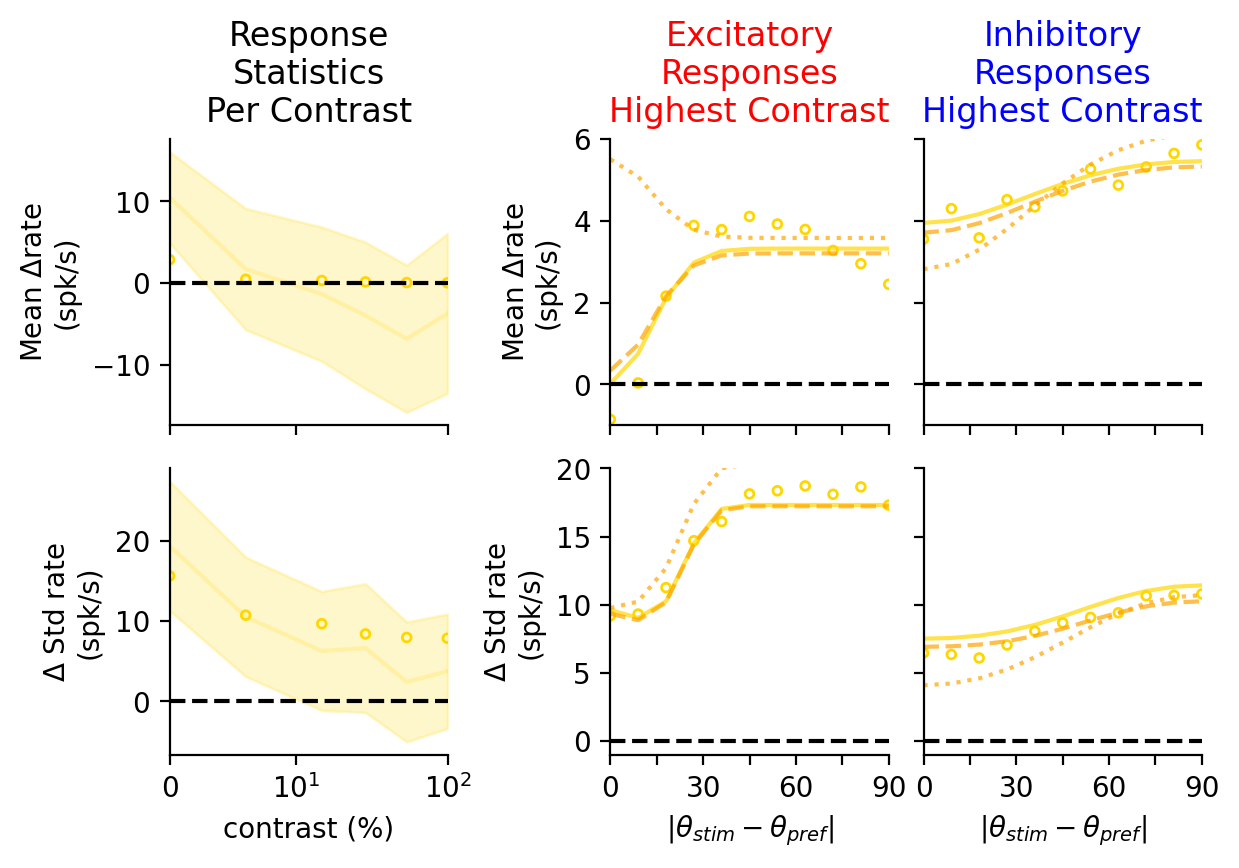

In [202]:
with open('./data_moments'+'.pkl', 'rb') as handle:
    data_preds = np.transpose(pickle.load(handle)[1],(1,0,2))
data_dr = np.concatenate([data_preds[:,1,0:1]-data_preds[:,0,0:1],
                          np.sqrt(data_preds[:,1,1:2]**2+data_preds[:,0,1:2]**2)],-1)
data_dstdr = np.concatenate([data_preds[:,3,0:1]-data_preds[:,2,0:1],
                             np.sqrt(data_preds[:,3,1:2]**2+data_preds[:,2,1:2]**2)],-1)
with open('./data_contrasts'+'.pkl', 'rb') as handle:
    cons = pickle.load(handle)[1]

def abs_ori(A):
    return 0.5*(A[:nori//2+1] + np.concatenate((A[0:1],A[-1:nori//2-1:-1])))

fig,axs = plt.subplots(2,4,figsize=(2*3.33,2*2),dpi=200,sharex='col',width_ratios=(3,1,3,3))
fig.subplots_adjust(hspace=0.15,wspace=0.15)
for i in range(2):
    axs[i,1].set_axis_off()
    axs[i,2].yaxis.set_tick_params(which='both',labelleft=True)
    axs[i,3].yaxis.set_tick_params(which='both',labelleft=False)
axs = axs[:,[0,2,3]]

axs[0,0].plot(cons,data_dr[:,0],color='gold',alpha=0.2)
axs[0,0].fill_between(cons,data_dr[:,0]-data_dr[:,1],data_dr[:,0]+data_dr[:,1],color='gold',alpha=0.2)
axs[0,0].scatter(cons,sim_dr,edgecolors='gold',facecolors='none',marker='o',s=10)
axs[0,1].plot(oris,roE-rvE,c='gold',ls='-',alpha=0.7,label='a')
axs[0,1].plot(oris,drE0,c='orange',ls=':',alpha=0.7,label='a')
axs[0,1].plot(oris,drE,c='orange',ls='--',alpha=0.7,label='a')
# axs[0,1].legend()
axs[0,1].scatter(oris,abs_ori(sim_roE-sim_rvE),edgecolors='gold',facecolors='none',marker='o',s=10)
axs[0,2].plot(oris,roI-rvI,c='gold',ls='-',alpha=0.7)
axs[0,2].plot(oris,drI0,c='orange',ls=':',alpha=0.7)
axs[0,2].plot(oris,drI,c='orange',ls='--',alpha=0.7)
axs[0,2].scatter(oris,abs_ori(sim_roI-sim_rvI),edgecolors='gold',facecolors='none',marker='o',s=10)
axs[1,0].plot(cons,data_dstdr[:,0],color='gold',alpha=0.2)
axs[1,0].fill_between(cons,data_dstdr[:,0]-data_dstdr[:,1],data_dstdr[:,0]+data_dstdr[:,1],color='gold',alpha=0.2)
axs[1,0].scatter(cons,sim_dstdr,edgecolors='gold',facecolors='none',marker='o',s=10)
axs[1,1].plot(oris,np.sqrt(CroE-roE**2)-np.sqrt(CrvE-rvE**2),c='gold',ls='-',alpha=0.7)
axs[1,1].plot(oris,np.sqrt(CrvE+dCrE0-(rvE+drE0)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls=':',alpha=0.7)
axs[1,1].plot(oris,np.sqrt(CrvE+dCrE-(rvE+drE)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls='--',alpha=0.7)
axs[1,1].scatter(oris,abs_ori(sim_std_roE-sim_std_rvE),edgecolors='gold',facecolors='none',marker='o',s=10)
axs[1,2].plot(oris,np.sqrt(CroI-roI**2)-np.sqrt(CrvI-rvI**2),c='gold',ls='-',alpha=0.7)
axs[1,2].plot(oris,np.sqrt(CrvI+dCrI0-(rvI+drI0)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls=':',alpha=0.7)
axs[1,2].plot(oris,np.sqrt(CrvI+dCrI-(rvI+drI)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls='--',alpha=0.7)
axs[1,2].scatter(oris,abs_ori(sim_std_roI-sim_std_rvI),edgecolors='gold',facecolors='none',marker='o',s=10)

for i in range(2):
    for j in range(3):
        axs[i,j].axhline(0,c='k',ls='--')
    
# axs[0,1].legend()
# axs[1,1].legend()
# axs[2,1].legend()

for ax in axs.flat:
    ax.spines[['right', 'top']].set_visible(False)

axs[0,0].set_xscale('symlog', linthresh=12)
nticks = 7
ticks = np.array(['{:.0f}'.format(ori) for ori in np.linspace(0,90,nticks)])
ticks[1::2] = ''
for i in range(1,3):
    axs[1,i].set_xticks(np.linspace(0,90,7),ticks)

axs[0,0].set_xlim(0,100)
axs[0,1].set_xlim(0,90)
axs[0,2].set_xlim(0,90)
for i in range(1,3):
    axs[0,i].set_ylim(-1,6)
    axs[1,i].set_ylim(-1,20)

axs[1,0].set_xlabel('contrast (%)')
axs[1,1].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')
axs[1,2].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')

for i in range(2):
    axs[0,i].set_ylabel(r'Mean $\Delta$rate'+'\n(spk/s)')
    axs[1,i].set_ylabel(r'$\Delta$ Std rate'+'\n(spk/s)')

axs[0,0].set_title('Response\nStatistics\nPer Contrast',color='k')
axs[0,1].set_title('Excitatory\nResponses\nHighest Contrast',color='r')
axs[0,2].set_title('Inhibitory\nResponses\nHighest Contrast',color='b')

# fig.tight_layout()
fig.savefig('./../plots/delta_rate_lin_resp_gauss_test.pdf')

# Compute SVD of Linear Response

In [407]:
varpmat = np.array(
    [[-2*rvp[0],0,1,0],
     [0,-2*rvp[1],0,1]]
)
varbmat = np.array(
    [[-2*rvb[0],0,1,0],
     [0,-2*rvb[1],0,1]]
)
stdpmat = 0.5*varpmat/np.sqrt(Crvp[:,-1]-rvp**2)[:,None]
stdbmat = 0.5*varbmat/np.sqrt(Crvb[:,-1]-rvb**2)[:,None]

In [408]:
# U,S,Vh = np.linalg.svd(stdpmat@np.linalg.inv(Mpp)[(0,1,1+NT,-1),:]@fpmat@Eonly_mask[:4,:2]@\
#     np.diag([1,2*np.sqrt(res_dict_init['Sigp'][0,-1])]))
U,S,Vh = np.linalg.svd(stdpmat@np.linalg.inv(Mpp)[(0,1,1+NT,-1),:]@feffmat[:,(0,2)]@\
    np.diag([1,2*np.sqrt(Crvp[0,-1])]))

In [409]:
print(U)
print(S)
print(Vh.T)

[[-0.99992101  0.01256869]
 [ 0.01256869  0.99992101]]
[2.3771912  0.21433426]
[[ 0.64057254  0.76789766]
 [-0.76789766  0.64057254]]


In [410]:
# np.diag([1,0.5/np.sqrt(res_dict_init['Sigp'][0,-1])])@eff_Einp[2:]
np.diag([1,0.5/np.sqrt(Crvp[0,-1])])@feffp[(0,1+NT),]

array([13.20253372, 17.22654651])

In [411]:
# stdpmat@np.linalg.inv(Mpp)[(0,1,1+NT,-1),:]@fpmat@Eonly_mask[:4,:2]@eff_Einp[2:]
stdpmat@np.linalg.inv(Mpp)[(0,1,1+NT,-1),:]@feffmat[:,(0,2)]@feffp[(0,1+NT),]

array([11.39782646,  4.39520088])

In [412]:
# np.diag(S)@Vh@np.diag([1,0.5/np.sqrt(res_dict_init['Sigp'][0,-1])])@eff_Einp[2:]
np.diag(S)@Vh@np.diag([1,0.5/np.sqrt(Crvp[0,-1])])@feffp[(0,1+NT),]

array([-11.34168423,   4.53810949])

# Calculate Linear Response for All Contrasts

In [283]:
res_dict_inits = [None]*6
res_dict_perts = [None]*6

for c_idx in range(6):
    with open('./../results/dmft_best_fit_id_None_c_{:d}'.format(c_idx)+'.pkl','rb') as\
            handle:
        this_res_dict = pickle.load(handle)['dmft_res']
    if c_idx==0:
        res_dict_inits[c_idx] = {key: this_res_dict[key][:2] for key in ['r','Cr','mu','Sig']}
        res_dict_perts[c_idx] = {key: this_res_dict[key][2:] for key in ['r','Cr','mu','Sig']}
    else:
        res_dict_inits[c_idx] = {key: this_res_dict[key][:2] for key in ['rb','rp','sr','Crb','Crp','sCr',
                                                                         'mub','mup','Sigb','Sigp']}
        res_dict_perts[c_idx] = {key: this_res_dict[key][2:] for key in ['rb','rp','sr','Crb','Crp','sCr',
                                                                         'mub','mup','Sigb','Sigp']}

In [284]:
reload(dmft)

Twrm = 1.2
Tsav = 0.4
dt = 0.01/5

res_dict_decoups = [None]*6

for c_idx in range(1,6):
    # res_dict_decoups[c_idx] = dmft.run_decoupled_two_site_dmft(prms,bX,aXs[c_idx]/bX,eX,'./../results',ri,Twrm,Tsav,dt,
    #                                                            struct_dict=res_dict_inits[c_idx],
    #                                                            which='opto',return_full=True)
    # with open('./decoup_resp_c_{:d}.pkl'.format(c_idx),'wb') as handle:
    #     pickle.dump(res_dict_decoups[c_idx],handle)
        
    with open('./decoup_resp_c_{:d}.pkl'.format(c_idx),'rb') as handle:
        res_dict_decoups[c_idx] = pickle.load(handle)

In [285]:
def calc_lin_resp(res_dict_init,res_dict_decoup):
    δrb0 = res_dict_decoup['rb'] - res_dict_init['rb']
    δrp0 = res_dict_decoup['rp'] - res_dict_init['rp']
    δCrb0 = res_dict_decoup['Crb'] - res_dict_init['Crb']
    δCrp0 = res_dict_decoup['Crp'] - res_dict_init['Crp']
    
    sr = res_dict_init['sr']
    sCr = res_dict_init['sCr'][:,-1]

    sW = np.array([[SoriE,SoriI],[SoriE,SoriI]],dtype=np.float32)
    sW2 = sW**2
    sWr = np.sqrt(sW2+sr**2)
    sWCr = np.sqrt(sW2+sCr**2)

    muWbb = (1 - dmft.struct_fact(180/2,sWr,sr,180)) * muW
    muWbp = dmft.struct_fact(180/2,sWr,sr,180) * muW
    muWpb = (1 - dmft.struct_fact(0,sWr,sr,180)) * muW
    muWpp = dmft.struct_fact(0,sWr,sr,180) * muW

    SigWbb = (1 - dmft.struct_fact(180/2,sWCr,sCr,180)) * SigW
    SigWbp = dmft.struct_fact(180/2,sWCr,sCr,180) * SigW
    SigWpb = (1 - dmft.struct_fact(0,sWCr,sCr,180)) * SigW
    SigWpp = dmft.struct_fact(0,sWCr,sCr,180) * SigW
    
    block_muW = np.block([
        [muWbb,muWbp],
        [muWpb,muWpp]
    ])
    block_SigW = np.block([
        [SigWbb,SigWbp],
        [SigWpb,SigWpp]
    ])

    NP = 2
    NT = int(np.round(Tsav/dt)+1)
    
    block_mu = np.concatenate([res_dict_decoup['mub'],res_dict_decoup['mup']])
    block_Sig = np.concatenate([res_dict_decoup['Sigb'],res_dict_decoup['Sigp']],0)
    
    res_dict_lin_resp = dmft.lin_resp_mats(np.concatenate([tau,tau]),block_muW,block_SigW,
                                        np.zeros(4),np.zeros(4),block_opto_M,block_opto_C,Tsav,dt,
                                        block_mu,block_Sig)

    A = res_dict_lin_resp['A']
    B = res_dict_lin_resp['B']
    C = res_dict_lin_resp['C']
    D = res_dict_lin_resp['D']
    D0dis = res_dict_lin_resp['D0dis'][:2,:,:2,:]
    
    Abb,Abp,Apb,App = A[:2,  :2],  A[:2,  2:],  A[2:,  :2],  A[2:,  2:]
    Bbb,Bbp,Bpb,Bpp = B[:2,  :2,:],B[:2,  2:,:],B[2:,  :2,:],B[2:,  2:,:]
    Cbb,Cbp,Cpb,Cpp = C[:2,:,:2],  C[:2,:,2:],  C[2:,:,:2],  C[2:,:,2:]
    Dbb,Dbp,Dpb,Dpp = D[:2,:,:2,:],D[:2,:,2:,:],D[2:,:,:2,:],D[2:,:,2:,:]
    
    Mbb = np.block([[Abb,Bbb.reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
    Mbp = np.block([[Abp,Bbp.reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
    Mpb = np.block([[Apb,Bpb.reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
    Mpp = np.block([[App,Bpp.reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),Dpp.reshape(NP*NT,NP*NT)]])
    
    Xbp = -np.linalg.solve(Mbb,Mbp)
    Xpb = -np.linalg.solve(Mpp,Mpb)

    Mbb0dis = np.block([[Abb,np.zeros_like(Bbb).reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
    Mbp0dis = np.block([[Abp,np.zeros_like(Bbp).reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
    Mpb0dis = np.block([[Apb,np.zeros_like(Bpb).reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
    Mpp0dis = np.block([[App,np.zeros_like(Bpp).reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),Dpp.reshape(NP*NT,NP*NT)]])
    # Mbb0dis = np.block([[Abb,Bbb.reshape(NP,NP*NT)],[np.zeros_like(Cbb).reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
    # Mbp0dis = np.block([[Abp,Bbp.reshape(NP,NP*NT)],[np.zeros_like(Cbp).reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
    # Mpb0dis = np.block([[Apb,Bpb.reshape(NP,NP*NT)],[np.zeros_like(Cpb).reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
    # Mpp0dis = np.block([[App,Bpp.reshape(NP,NP*NT)],[np.zeros_like(Cpp).reshape(NP*NT,NP),Dpp.reshape(NP*NT,NP*NT)]])
    
    Xbp0dis = Xbp.copy()
    Xbp0dis[:2,:2] = -np.linalg.solve(Abb,Abp)
    Xbp0dis[:2,2:] = 0
    Xpb0dis = Xpb.copy()
    Xpb0dis[:2,:2] = -np.linalg.solve(App,Apb)
    Xpb0dis[:2,2:] = 0

    δmb0 = np.concatenate([δrb0,δCrb0.flatten()])
    δmp0 = np.concatenate([δrp0,δCrp0.flatten()])

    fb = Mbb@δmb0
    fp = Mpp@δmp0

    M = np.block([[Mbb,Mbp],[Mpb,Mpp]])
    M0dis = np.block([[Mbb0dis,Mbp0dis],[Mpb0dis,Mpp0dis]])
    f = np.concatenate([fb,fp])
    
    # δm = np.linalg.solve(M,f)
    # δm = np.concatenate([δmb0+Xbp@δmp0,
    #                      δmp0+Xpb@δmb0])
    δm = np.concatenate([δmb0,
                         δmp0+Xpb@δmb0])
    # δm0dis = np.linalg.solve(M0dis,f)
    # δm0dis = np.concatenate([δmb0+Xbp0dis@δmp0,
    #                          δmp0+Xpb0dis@δmb0])
    δm0dis = np.concatenate([δmb0,
                             δmp0+Xpb0dis@δmb0])

    δmb = δm[:NP+NP*NT]
    δmp = δm[NP+NP*NT:]

    δmb0dis = δm0dis[:NP+NP*NT]
    δmp0dis = δm0dis[NP+NP*NT:]

    δrb = δmb[:NP]
    δCrb = δmb[NP:].reshape(NP,NT)
    δrp = δmp[:NP]
    δCrp = δmp[NP:].reshape(NP,NT)

    δrb0dis = δmb0dis[:NP]
    δCrb0dis = δmb0dis[NP:].reshape(NP,NT)
    δrp0dis = δmp0dis[:NP]
    δCrp0dis = δmp0dis[NP:].reshape(NP,NT)
    
    res_dict = {}
    
    res_dict['drb0'] = δrb0
    res_dict['drp0'] = δrp0
    res_dict['dCrb0'] = δCrb0
    res_dict['dCrp0'] = δCrp0
    res_dict['drb'] = δrb
    res_dict['drp'] = δrp
    res_dict['dCrb'] = δCrb
    res_dict['dCrp'] = δCrp
    res_dict['drb0dis'] = δrb0dis
    res_dict['drp0dis'] = δrp0dis
    res_dict['dCrb0dis'] = δCrb0dis
    res_dict['dCrp0dis'] = δCrp0dis
    
    return res_dict

In [286]:
res_dict_lin_resps = [None]*6

for c_idx in range(1,6):
    res_dict_lin_resps[c_idx] = calc_lin_resp(res_dict_inits[c_idx],res_dict_decoups[c_idx])

In [287]:
dmft_dr = np.zeros(6)
dmft_dr0 = np.zeros(6)
dmft_drfull = np.zeros(6)
dmft_dr0dis = np.zeros(6)
dmft_dstdr = np.zeros(6)
dmft_dstdr0 = np.zeros(6)
dmft_dstdrfull = np.zeros(6)
dmft_dstdr0dis = np.zeros(6)

for c_idx in range(6):
    if c_idx==0:
        dmft_dr[c_idx] = np.sum(np.array([0.8,0.2])*(res_dict_perts[c_idx]['r'] - res_dict_inits[c_idx]['r']))
        dmft_dr0[c_idx] = np.nan
        dmft_drfull[c_idx] = np.nan
        dmft_dr0dis[c_idx] = np.nan
        
        dmft_dstdr[c_idx] = np.sqrt(np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_perts[c_idx]['Cr'],1,dt)-res_dict_perts[c_idx]['r']**2))) -\
            np.sqrt(np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_inits[c_idx]['Cr'],1,dt)-res_dict_inits[c_idx]['r']**2)))
        dmft_dstdr0[c_idx] = np.nan
        dmft_dstdrfull[c_idx] = np.nan
        dmft_dstdr0dis[c_idx] = np.nan
    else:
        dmft_dr[c_idx] = np.sum(np.array([0.8,0.2])*(res_dict_perts[c_idx]['rp'] - res_dict_inits[c_idx]['rp']))
        dmft_dr0[c_idx] = np.sum(np.array([0.8,0.2])*res_dict_lin_resps[c_idx]['drp0'])
        dmft_drfull[c_idx] = np.sum(np.array([0.8,0.2])*res_dict_lin_resps[c_idx]['drp'])
        dmft_dr0dis[c_idx] = np.sum(np.array([0.8,0.2])*res_dict_lin_resps[c_idx]['drp0dis'])
        
        init_varr = np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_inits[c_idx]['Crp'],1,dt)-res_dict_inits[c_idx]['rp']**2))
        dmft_dstdr[c_idx] = np.sqrt(np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_perts[c_idx]['Crp'],1,dt)-res_dict_perts[c_idx]['rp']**2))) -\
            np.sqrt(init_varr)
        dmft_dstdr0[c_idx] = np.sqrt(np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_decoups[c_idx]['Crp'],1,dt)-res_dict_decoups[c_idx]['rp']**2))) -\
            np.sqrt(init_varr)
        dmft_dstdrfull[c_idx] = np.sqrt(np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_inits[c_idx]['Crp']+res_dict_lin_resps[c_idx]['dCrp'],1,dt)-\
            (res_dict_inits[c_idx]['rp']+res_dict_lin_resps[c_idx]['drp'])**2))) -\
            np.sqrt(init_varr)
        dmft_dstdr0dis[c_idx] = np.sqrt(np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_inits[c_idx]['Crp']+res_dict_lin_resps[c_idx]['dCrp0dis'],1,dt)-\
            (res_dict_inits[c_idx]['rp']+res_dict_lin_resps[c_idx]['drp0dis'])**2))) -\
            np.sqrt(init_varr)

In [288]:
print(dmft_dr)
print(dmft_dr0)
print(dmft_drfull)
print(dmft_dr0dis)

[3.32553329 1.45615768 1.11685791 0.91700821 0.83977661 0.80114288]
[       nan 5.17556305 5.1078186  5.05428848 5.02885208 5.01399307]
[       nan 1.3774157  1.10414916 0.9368322  0.86702618 0.83506668]
[       nan 1.89437147 1.61647724 1.43768865 1.3666349  1.32120306]


In [289]:
drE = gauss(oris,res_dict_lin_resps[5]['drb'][0],res_dict_lin_resps[5]['drp'][0],sr[0])
drI = gauss(oris,res_dict_lin_resps[5]['drb'][1],res_dict_lin_resps[5]['drp'][1],sr[1])
drE0dis = gauss(oris,res_dict_lin_resps[5]['drb0dis'][0],res_dict_lin_resps[5]['drp0dis'][0],sr[0])
drI0dis = gauss(oris,res_dict_lin_resps[5]['drb0dis'][1],res_dict_lin_resps[5]['drp0dis'][1],sr[1])

dCrE = gauss(oris,dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrb'][0:0+1],1,dt),
              dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrp'][0:0+1],1,dt),sCr[0])
dCrI = gauss(oris,dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrb'][1:1+1],1,dt),
              dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrp'][1:1+1],1,dt),sCr[1])
dCrE0dis = gauss(oris,dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrb0dis'][0:0+1],1,dt),
              dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrp0dis'][0:0+1],1,dt),sCr[0])
dCrI0dis = gauss(oris,dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrb0dis'][1:1+1],1,dt),
              dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrp0dis'][1:1+1],1,dt),sCr[1])

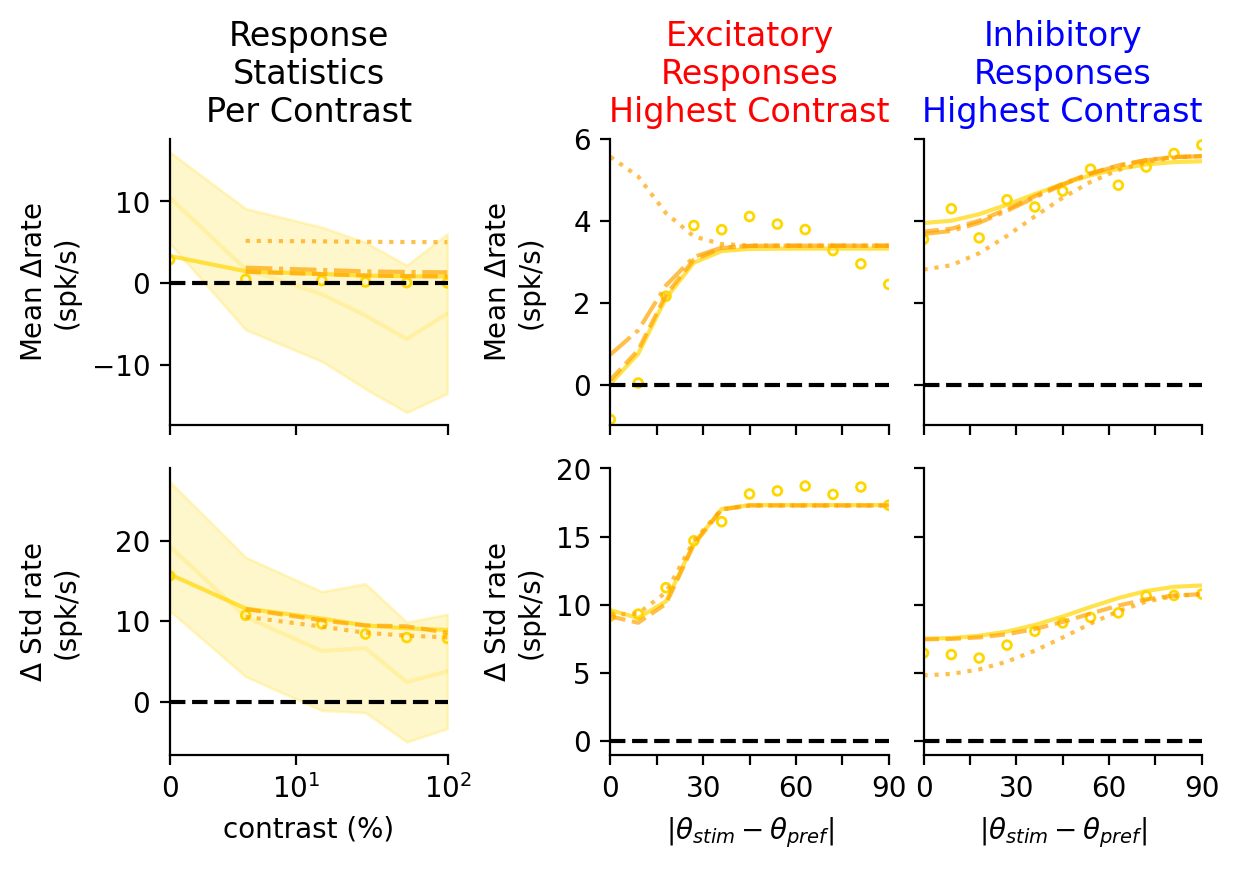

In [290]:
with open('./data_moments'+'.pkl', 'rb') as handle:
    data_preds = np.transpose(pickle.load(handle)[1],(1,0,2))
data_dr = np.concatenate([data_preds[:,1,0:1]-data_preds[:,0,0:1],
                          np.sqrt(data_preds[:,1,1:2]**2+data_preds[:,0,1:2]**2)],-1)
data_dstdr = np.concatenate([data_preds[:,3,0:1]-data_preds[:,2,0:1],
                             np.sqrt(data_preds[:,3,1:2]**2+data_preds[:,2,1:2]**2)],-1)
with open('./data_contrasts'+'.pkl', 'rb') as handle:
    cons = pickle.load(handle)[1]

def abs_ori(A):
    return 0.5*(A[:nori//2+1] + np.concatenate((A[0:1],A[-1:nori//2-1:-1])))

fig,axs = plt.subplots(2,4,figsize=(2*3.33,2*2),dpi=200,sharex='col',width_ratios=(3,1,3,3))
fig.subplots_adjust(hspace=0.15,wspace=0.15)
for i in range(2):
    axs[i,1].set_axis_off()
    axs[i,2].yaxis.set_tick_params(which='both',labelleft=True)
    axs[i,3].yaxis.set_tick_params(which='both',labelleft=False)
axs = axs[:,[0,2,3]]

axs[0,0].plot(cons,data_dr[:,0],color='gold',alpha=0.2)
axs[0,0].fill_between(cons,data_dr[:,0]-data_dr[:,1],data_dr[:,0]+data_dr[:,1],color='gold',alpha=0.2)
axs[0,0].scatter(cons,sim_dr,edgecolors='gold',facecolors='none',marker='o',s=10)
axs[0,0].plot(cons,dmft_dr,c='gold',ls='-',alpha=0.7,label='a')
axs[0,0].plot(cons,dmft_dr0,c='orange',ls=':',alpha=0.7,label='a')
axs[0,0].plot(cons,dmft_drfull,c='orange',ls='--',alpha=0.7,label='a')
axs[0,0].plot(cons,dmft_dr0dis,c='orange',ls='-.',alpha=0.7,label='a')
axs[0,1].plot(oris,roE-rvE,c='gold',ls='-',alpha=0.7,label='a')
axs[0,1].plot(oris,drE0,c='orange',ls=':',alpha=0.7,label='a')
axs[0,1].plot(oris,drE,c='orange',ls='--',alpha=0.7,label='a')
axs[0,1].plot(oris,drE0dis,c='orange',ls='-.',alpha=0.7,label='a')
# axs[0,1].legend()
axs[0,1].scatter(oris,abs_ori(sim_roE-sim_rvE),edgecolors='gold',facecolors='none',marker='o',s=10)
axs[0,2].plot(oris,roI-rvI,c='gold',ls='-',alpha=0.7)
axs[0,2].plot(oris,drI0,c='orange',ls=':',alpha=0.7)
axs[0,2].plot(oris,drI,c='orange',ls='--',alpha=0.7)
axs[0,2].plot(oris,drI0dis,c='orange',ls='-.',alpha=0.7)
axs[0,2].scatter(oris,abs_ori(sim_roI-sim_rvI),edgecolors='gold',facecolors='none',marker='o',s=10)
axs[1,0].plot(cons,data_dstdr[:,0],color='gold',alpha=0.2)
axs[1,0].fill_between(cons,data_dstdr[:,0]-data_dstdr[:,1],data_dstdr[:,0]+data_dstdr[:,1],color='gold',alpha=0.2)
axs[1,0].scatter(cons,sim_dstdr,edgecolors='gold',facecolors='none',marker='o',s=10)
axs[1,0].plot(cons,dmft_dstdr,c='gold',ls='-',alpha=0.7,label='a')
axs[1,0].plot(cons,dmft_dstdr0,c='orange',ls=':',alpha=0.7,label='a')
axs[1,0].plot(cons,dmft_dstdrfull,c='orange',ls='--',alpha=0.7,label='a')
# axs[1,0].plot(cons,dmft_dstdr0dis,c='orange',ls='-.',alpha=0.7,label='a')
axs[1,1].plot(oris,np.sqrt(CroE-roE**2)-np.sqrt(CrvE-rvE**2),c='gold',ls='-',alpha=0.7)
axs[1,1].plot(oris,np.sqrt(CrvE+dCrE0-(rvE+drE0)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls=':',alpha=0.7)
axs[1,1].plot(oris,np.sqrt(CrvE+dCrE-(rvE+drE)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls='--',alpha=0.7)
# axs[1,1].plot(oris,np.sqrt(CrvE+dCrE0dis-(rvE+drE0dis)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls='-.',alpha=0.7)
axs[1,1].scatter(oris,abs_ori(sim_std_roE-sim_std_rvE),edgecolors='gold',facecolors='none',marker='o',s=10)
axs[1,2].plot(oris,np.sqrt(CroI-roI**2)-np.sqrt(CrvI-rvI**2),c='gold',ls='-',alpha=0.7)
axs[1,2].plot(oris,np.sqrt(CrvI+dCrI0-(rvI+drI0)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls=':',alpha=0.7)
axs[1,2].plot(oris,np.sqrt(CrvI+dCrI-(rvI+drI)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls='--',alpha=0.7)
# axs[1,2].plot(oris,np.sqrt(CrvI+dCrI0dis-(rvI+drI0dis)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls='-.',alpha=0.7)
axs[1,2].scatter(oris,abs_ori(sim_std_roI-sim_std_rvI),edgecolors='gold',facecolors='none',marker='o',s=10)

for i in range(2):
    for j in range(3):
        axs[i,j].axhline(0,c='k',ls='--')
    
# axs[0,1].legend()
# axs[1,1].legend()
# axs[2,1].legend()

for ax in axs.flat:
    ax.spines[['right', 'top']].set_visible(False)

axs[0,0].set_xscale('symlog', linthresh=12)
nticks = 7
ticks = np.array(['{:.0f}'.format(ori) for ori in np.linspace(0,90,nticks)])
ticks[1::2] = ''
for i in range(1,3):
    axs[1,i].set_xticks(np.linspace(0,90,7),ticks)

axs[0,0].set_xlim(0,100)
axs[0,1].set_xlim(0,90)
axs[0,2].set_xlim(0,90)
for i in range(1,3):
    axs[0,i].set_ylim(-1,6)
    axs[1,i].set_ylim(-1,20)

axs[1,0].set_xlabel('contrast (%)')
axs[1,1].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')
axs[1,2].set_xlabel(r'$|\theta_{stim}-\theta_{pref}|$')

for i in range(2):
    axs[0,i].set_ylabel(r'Mean $\Delta$rate'+'\n(spk/s)')
    axs[1,i].set_ylabel(r'$\Delta$ Std rate'+'\n(spk/s)')

axs[0,0].set_title('Response\nStatistics\nPer Contrast',color='k')
axs[0,1].set_title('Excitatory\nResponses\nHighest Contrast',color='r')
axs[0,2].set_title('Inhibitory\nResponses\nHighest Contrast',color='b')

fig.align_labels()

# fig.tight_layout()
fig.savefig('./../plots/delta_rate_lin_resp_paper.pdf')

# Calculate Opto Response with Two Gratings

In [345]:
reload(dmft)

Twrm = 1.2
Tsav = 0.4
dt = 0.01/5

# res_dict_init = dmft.run_first_stage_ring_dmft(prms,bX,aXs[-1]/bX,eX,'./../results',ri,Twrm,Tsav,dt,which='base',return_full=True)
# res_dict_pert = dmft.run_first_stage_ring_dmft(prms,bX,aXs[-1]/bX,eX,'./../results',ri,Twrm,Tsav,dt,which='opto',return_full=True)

with open('./../results/dmft_opto_norm_id_None_c_{:d}'.format(5)+'.pkl','rb') as\
        handle:
    this_res_dict = pickle.load(handle)['dmft_res']
    res_dict_init = {key: this_res_dict[key][:2] for key in ['rb','rp','sr','Crb','Crp','sCr',
                                                            'mub','mup','Sigb','Sigp']}
    res_dict_pert = {key: this_res_dict[key][2:] for key in ['rb','rp','sr','Crb','Crp','sCr',
                                                            'mub','mup','Sigb','Sigp']}

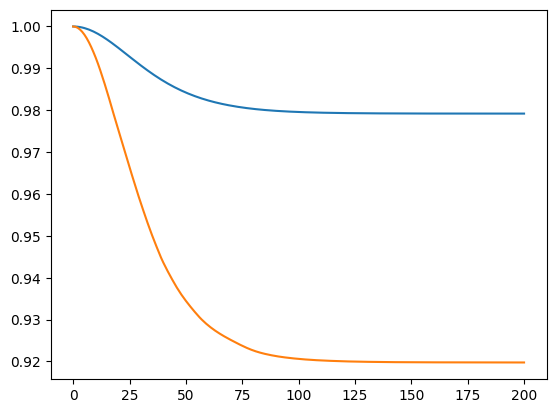

In [24]:
plt.plot((res_dict_init['sCr']/res_dict_init['sCr'][:,0:1]).T)

In [346]:
rvb = res_dict_init['rb']
rvp = res_dict_init['rp']
sr = res_dict_init['sr']
Crvb = res_dict_init['Crb']
Crvp = res_dict_init['Crp']
sCr = res_dict_init['sCr'][:,-1]

rob = res_dict_pert['rb']
rop = res_dict_pert['rp']
Crob = res_dict_pert['Crb']
Crop = res_dict_pert['Crp']

In [347]:
reload(dmft)

Twrm = 1.2
Tsav = 0.4
dt = 0.01/5

# res_dict_decoup = dmft.run_decoupled_three_site_dmft(prms,bX,aXs[-1]/bX,eX,'./../results',ri,Twrm,Tsav,dt,
#                                                      struct_dict=res_dict_init,which='opto',return_full=True)
# with open('./decoup_resp_2feat.pkl','wb') as handle:
#     pickle.dump(res_dict_decoup,handle)
    
with open('./decoup_resp_2feat.pkl','rb') as handle:
    res_dict_decoup = pickle.load(handle)

In [348]:
rLb = res_dict_decoup['rb']
rLp = res_dict_decoup['rp']
CrLb = res_dict_decoup['Crb']
CrLp = res_dict_decoup['Crp']

δrb0 = rLb - rvb
δrp0 = rLp - rvp
δCrb0 = CrLb - Crvb
δCrp0 = CrLp - Crvp

In [349]:
print(δrb0)
print(res_dict_pert['rb'] - rvb)
print()
print(δrp0)
print(res_dict_pert['rp'] - rvp)
print()
print(δCrb0[:,-1])
print(res_dict_pert['Crb'][:,-1] - Crvb[:,-1])
print()
print(δCrp0[:,-1])
print(res_dict_pert['Crp'][:,-1] - Crvp[:,-1])

[3.7790365 5.7976475]
[3.5951252 5.862484 ]

[5.752594 2.942791]
[1.4002647 3.9428062]

[ 808.04944 1320.0098 ]
[ 792.6789 1351.5718]

[1498.7378  988.1948]
[1043.249  1577.1655]


In [350]:
FL,MFL,CFFL = dmft.opto_itp_moments('./../results',prms['L'],CVL)

SoriE = prms['SoriE']
SoriI = prms['SoriI']
dori = 45

xpeaks = np.array([0,-dori])
sW = np.array([[SoriE,SoriI],[SoriE,SoriI]],dtype=np.float32)
sW2 = sW**2
sWr = np.sqrt(sW2+sr**2)
sWCr = np.sqrt(sW2+sCr**2)
rOinv = dmft.inv_overlap(xpeaks,sr[:,None])[:,:,0]
CrOinv = dmft.inv_overlap(xpeaks,sCr[:,None])[:,:,0]

muWbb = (1 - 2*dmft.struct_fact(180/2,sWr,sr,180)*np.sum(rOinv,-1)[None,:]) * muW 
muWbp = dmft.struct_fact(180/2,sWr,sr,180)*np.sum(rOinv,-1)[None,:] * muW
muWpb = (1 - (dmft.struct_fact(0,sWr,sr,180) + dmft.struct_fact(dori,sWr,sr,180))*np.sum(rOinv,-1)[None,:]) * muW
muWps = (dmft.struct_fact(0,sWr,sr,180)*rOinv[None,:,0] + dmft.struct_fact(dori,sWr,sr,180)*rOinv[None,:,1]) * muW
muWpc = (dmft.struct_fact(dori,sWr,sr,180)*rOinv[None,:,0] + dmft.struct_fact(0,sWr,sr,180)*rOinv[None,:,1]) * muW

SigWbb = (1 - 2*dmft.struct_fact(180/2,sWCr,sCr,180)*np.sum(CrOinv,-1)[None,:]) * SigW
SigWbp = dmft.struct_fact(180/2,sWCr,sCr,180)*np.sum(CrOinv,-1)[None,:] * SigW
SigWpb = (1 - (dmft.struct_fact(0,sWCr,sCr,180) + dmft.struct_fact(dori,sWCr,sCr,180))*np.sum(CrOinv,-1)[None,:]) * SigW
SigWps = (dmft.struct_fact(0,sWCr,sCr,180)*CrOinv[None,:,0] +\
    dmft.struct_fact(dori,sWCr,sCr,180)*CrOinv[None,:,1]) * SigW
SigWpc = (dmft.struct_fact(dori,sWCr,sCr,180)*CrOinv[None,:,0] +\
    dmft.struct_fact(0,sWCr,sCr,180)*CrOinv[None,:,1]) * SigW

block_muW = np.block([
    [muWbb,muWbp,muWbp],
    [muWpb,muWps,muWpc],
    [muWpb,muWpc,muWps]
])
block_SigW = np.block([
    [SigWbb,SigWbp,SigWbp],
    [SigWpb,SigWps,SigWpc],
    [SigWpb,SigWpc,SigWps]
])

block_mu = np.concatenate([res_dict_decoup['mub'],res_dict_decoup['mup'],res_dict_decoup['mup']])
block_Sig = np.concatenate([res_dict_decoup['Sigb'],res_dict_decoup['Sigp'],res_dict_decoup['Sigp']],0)

def block_opto_M(mui,Sigii,out):
    out[0] = ML(mui[0],Sigii[0])[0]
    out[1] = MI(mui[1],Sigii[1])[0]
    out[2] = ML(mui[2],Sigii[2])[0]
    out[3] = MI(mui[3],Sigii[3])[0]
    out[4] = ML(mui[4],Sigii[4])[0]
    out[5] = MI(mui[5],Sigii[5])[0]
    
def block_opto_C(mui,Sigii,Sigij,out):
    out[0] = CL(mui[0],Sigii[0],Sigij[0])[0]
    out[1] = CI(mui[1],Sigii[1],Sigij[1])[0]
    out[2] = CL(mui[2],Sigii[2],Sigij[2])[0]
    out[3] = CI(mui[3],Sigii[3],Sigij[3])[0]
    out[4] = CL(mui[4],Sigii[4],Sigij[4])[0]
    out[5] = CI(mui[5],Sigii[5],Sigij[5])[0]

In [302]:
res_dict_lin_resp = dmft.lin_resp_mats(np.concatenate([tau,tau,tau]),block_muW,block_SigW,
                                       np.zeros(6),np.zeros(6),block_opto_M,block_opto_C,Tsav,dt,
                                       block_mu,block_Sig)

A = res_dict_lin_resp['A']
B = res_dict_lin_resp['B']
C = res_dict_lin_resp['C']
D = res_dict_lin_resp['D']
D0dis = res_dict_lin_resp['D0dis'][0:2,:,0:2,:]

Abb,Abp,Apb,Aps,Apc = A[0:2,  0:2],  A[0:2,  2:4],  A[2:4,  0:2],  A[2:4,  2:4],  A[2:4,  4:6]
Bbb,Bbp,Bpb,Bps,Bpc = B[0:2,  0:2,:],B[0:2,  2:4,:],B[2:4,  0:2,:],B[2:4,  2:4,:],B[2:4,  4:6,:]
Cbb,Cbp,Cpb,Cps,Cpc = C[0:2,:,0:2],  C[0:2,:,2:4],  C[2:4,:,0:2],  C[2:4,:,2:4],  C[2:4,:,4:6]
Dbb,Dbp,Dpb,Dps,Dpc = D[0:2,:,0:2,:],D[0:2,:,2:4,:],D[2:4,:,0:2,:],D[2:4,:,2:4,:],D[2:4,:,4:6,:]

In [303]:
NP = res_dict_init['Sigb'].shape[0]
NT = res_dict_init['Sigb'].shape[1]

Mbb = np.block([[Abb,Bbb.reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
Mbp = np.block([[Abp,Bbp.reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
Mpb = np.block([[Apb,Bpb.reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
Mps = np.block([[Aps,Bps.reshape(NP,NP*NT)],[Cps.reshape(NP*NT,NP),Dps.reshape(NP*NT,NP*NT)]])
Mpc = np.block([[Apc,Bpc.reshape(NP,NP*NT)],[Cpc.reshape(NP*NT,NP),Dpc.reshape(NP*NT,NP*NT)]])

# Mbb0dis = np.block([[Abb,np.zeros_like(Bbb).reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),D0dis.reshape(NP*NT,NP*NT)]])
# Mbp0dis = np.block([[Abp,np.zeros_like(Bbp).reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),np.zeros_like(Dbp).reshape(NP*NT,NP*NT)]])
# Mpb0dis = np.block([[Apb,np.zeros_like(Bpb).reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),np.zeros_like(Dpb).reshape(NP*NT,NP*NT)]])
# Mpp0dis = np.block([[App,np.zeros_like(Bpp).reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),D0dis.reshape(NP*NT,NP*NT)]])

# Mbb0dis = np.block([[Abb,Bbb.reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
# Mbp0dis = np.block([[Abp,Bbp.reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
Mbb0dis = np.block([[Abb,np.zeros_like(Bbb).reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
Mbp0dis = np.block([[Abp,np.zeros_like(Bbp).reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
Mpb0dis = np.block([[Apb,np.zeros_like(Bpb).reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
Mps0dis = np.block([[Aps,np.zeros_like(Bps).reshape(NP,NP*NT)],[Cps.reshape(NP*NT,NP),Dps.reshape(NP*NT,NP*NT)]])
Mpc0dis = np.block([[Apc,np.zeros_like(Bpc).reshape(NP,NP*NT)],[Cpc.reshape(NP*NT,NP),Dpc.reshape(NP*NT,NP*NT)]])

δmb0 = np.concatenate([δrb0,δCrb0.flatten()])
δmp0 = np.concatenate([δrp0,δCrp0.flatten()])

fb = Mbb@δmb0
fp = Mpp@δmp0

M = np.block([[Mbb,Mbp,Mbp],[Mpb,Mps,Mpc],[Mpb,Mpc,Mps]])
M0dis = np.block([[Mbb0dis,Mbp0dis,Mbp0dis],[Mpb0dis,Mps0dis,Mpc0dis],[Mpb0dis,Mpc0dis,Mps0dis]])
f = np.concatenate([fb,fp,fp])

# δm = np.linalg.solve(M,f)
δm = np.concatenate([δmb0-2*np.linalg.solve(Mbb,Mbp@δmp0),δmp0-np.linalg.solve(Mps,Mpb@δmb0+Mpc@δmp0)])
# δm0dis = np.linalg.solve(M0dis,f)
# δm0dis = np.concatenate([δmb0,δmp0-np.linalg.solve(Mps0dis,Mpb0dis@δmb0)])
δm0dis = np.concatenate([δmb0-2*np.linalg.solve(Mbb0dis,Mbp0dis@δmp0),δmp0-np.linalg.solve(Mps0dis,Mpb0dis@δmb0+Mpc0dis@δmp0)])

δmb = δm[:NP+NP*NT]
δmp = δm[NP+NP*NT:2*(NP+NP*NT)]

δmb0dis = δm0dis[:NP+NP*NT]
δmp0dis = δm0dis[NP+NP*NT:2*(NP+NP*NT)]

δrb = δmb[:NP]
δCrb = δmb[NP:].reshape(NP,NT)
δrp = δmp[:NP]
δCrp = δmp[NP:].reshape(NP,NT)

δrb0dis = δmb0dis[:NP]
δCrb0dis = δmb0dis[NP:].reshape(NP,NT)
δrp0dis = δmp0dis[:NP]
δCrp0dis = δmp0dis[NP:].reshape(NP,NT)

In [304]:
print(δmb0[:2])
print(δmp0[:2])
print()
print(δmb[:2])
print(δmp[:2])

[3.7790365 5.7976475]
[5.752594 2.942791]

[3.12451611 6.22739063]
[-0.19617172  4.69079905]


In [305]:
np.max(np.abs(np.linalg.eig(np.linalg.inv(np.block([[Mbb,np.zeros_like(Mbp),np.zeros_like(Mbp)],
                                                    [Mpb,Mps,np.zeros_like(Mpc)],
                                                    [Mpb,np.zeros_like(Mpc),Mps]]))@\
    np.block([[np.zeros_like(Mbb),Mbp,Mbp],
              [np.zeros_like(Mpb),np.zeros_like(Mps),Mpc],
              [np.zeros_like(Mpb),Mpc,np.zeros_like(Mps)]]))[0]))

0.5883359021619217

In [306]:
np.max(np.abs(np.linalg.eig(np.linalg.inv(np.block([[Mbb,np.zeros_like(Mbp),np.zeros_like(Mbp)],
                                                    [np.zeros_like(Mpb),Mps,Mpc],
                                                    [np.zeros_like(Mpb),Mpc,Mps]]))@\
    np.block([[np.zeros_like(Mbb),Mbp,Mbp],
              [Mpb,np.zeros_like(Mps),np.zeros_like(Mpc)],
              [Mpb,np.zeros_like(Mpc),np.zeros_like(Mps)]]))[0]))

0.46033222409391095

In [307]:
np.max(np.abs(np.linalg.eig(np.linalg.inv(np.block([[Mbb,np.zeros_like(Mbp),np.zeros_like(Mbp)],
                                                    [Mpb,Mps,Mpc],
                                                    [Mpb,Mpc,Mps]]))@\
    np.block([[np.zeros_like(Mbb),Mbp,Mbp],
              [np.zeros_like(Mpb),np.zeros_like(Mps),np.zeros_like(Mpc)],
              [np.zeros_like(Mpb),np.zeros_like(Mpc),np.zeros_like(Mps)]]))[0]))

0.21190575653925553

In [308]:
np.max(np.abs(np.linalg.eig(np.linalg.inv(np.block([[Mbb,np.zeros_like(Mbp),np.zeros_like(Mbp)],
                                                    [np.zeros_like(Mpb),Mps,np.zeros_like(Mpc)],
                                                    [np.zeros_like(Mpb),np.zeros_like(Mpc),Mps]]))@\
    np.block([[np.zeros_like(Mbb),Mbp,Mbp],
              [Mpb,np.zeros_like(Mps),Mpc],
              [Mpb,Mpc,np.zeros_like(Mps)]]))[0]))

0.6483913966935109

In [309]:
sim_dr = np.array([2.8632733 , 1.73748359, 1.4821209 , 1.42545991, 1.33983839, 1.32400562])
sim_dstdr = np.array([15.64064821, 10.67283096,  9.02450663,  8.21427819,  7.5925895 , 7.46980348])

sim_rvE = np.array([52.80649091, 44.50193477, 34.69752811, 34.78111446, 44.79978106,
       52.05012523, 43.73005585, 24.78101901, 11.38722409,  6.19449524,
        5.13378288,  5.17814941,  5.39130008,  5.44784946,  5.0860158 ,
        4.79533736,  6.10885008, 11.73619682, 24.82769276, 43.35771529])
sim_rvI = np.array([48.49091952, 53.39394871, 51.39161575, 51.70618317, 50.9464022 ,
       50.56128228, 45.57769374, 40.79384803, 36.62545255, 30.60161042,
       26.89866996, 26.02504926, 24.64176253, 23.49788069, 25.83078275,
       28.19878761, 31.6983714 , 35.05839326, 40.95797323, 45.79469806])

sim_roE = np.array([53.55938482, 46.16968491, 37.50623697, 37.81137338, 46.66325268,
       53.3329214 , 45.0332655 , 27.55334238, 14.92391385, 10.21038901,
        8.84979417,  9.11711648,  9.26367384,  9.15310431,  8.65404193,
        8.54317515,  9.53451542, 15.38404462, 27.2604142 , 44.3428708 ])
sim_roI = np.array([52.09937198, 57.91280959, 54.50649558, 55.00159065, 54.83087924,
       54.52567946, 50.74433088, 44.42087721, 40.8209428 , 36.37185759,
       31.74296459, 31.24440011, 30.21176081, 29.50224372, 30.35444239,
       33.93236745, 36.02854111, 40.05123187, 44.64591179, 50.10226688])

sim_std_rvE = np.array([42.5314445 , 40.8689231 , 37.32052443, 37.30340911, 40.96553896,
       42.66783387, 39.04248375, 29.35263556, 18.48213247, 12.39876537,
       10.55042126, 10.09529561, 10.20706384, 10.24013789, 10.13126849,
       10.06678248, 12.24948303, 18.90615931, 29.01673913, 38.66128218])
sim_std_rvI = np.array([73.36331201, 76.94337723, 76.03952935, 77.36400147, 75.50648074,
       75.45257086, 71.12356923, 65.3594428 , 60.51451484, 53.78008472,
       48.89134354, 47.08069738, 44.93334917, 43.63805499, 47.36057127,
       50.58535685, 55.63651019, 59.24455035, 65.25807772, 69.9608003 ])

sim_std_roE = np.array([51.0797467 , 49.12075444, 47.08518282, 47.2448023 , 50.29275244,
       52.13242193, 49.01283116, 41.42003503, 33.00911446, 30.30995423,
       28.02029196, 29.41490296, 28.7136429 , 28.60913514, 27.52476788,
       27.85493503, 27.28829511, 33.41680269, 40.23098442, 48.12625757])
sim_std_roI = np.array([78.97308256, 83.26227004, 81.62994618, 83.27956859, 82.1033617 ,
       81.47926142, 77.78332427, 72.24394594, 67.57928571, 62.58070227,
       57.54239595, 55.9483417 , 55.08905365, 54.01081438, 55.27596938,
       60.35889994, 63.13893138, 66.6350494 , 72.09618336, 76.37173837])

In [310]:
nori = 20

oris = np.arange(nori*3//4+1) * 90/(nori/2)
def gauss(x,b,p,s):
    if np.isscalar(s):
        amp = (p-b)*np.sum(dmft.inv_overlap(xpeaks,s*np.ones((1))[:,None])[:,:,0],-1)
    else:
        amp = (p-b)*np.sum(dmft.inv_overlap(xpeaks,s[:,None])[:,:,0],-1)
    return b + amp*dmft.basesubwrapnorm(x,s) + amp*dmft.basesubwrapnorm(x-dori,s)

rvE = gauss(oris,rvb[0],rvp[0],sr[0])
rvI = gauss(oris,rvb[1],rvp[1],sr[1])
roE = gauss(oris,rob[0],rop[0],sr[0])
roI = gauss(oris,rob[1],rop[1],sr[1])

drE0 = gauss(oris,δrb0[0],δrp0[0],sr[0])
drI0 = gauss(oris,δrb0[1],δrp0[1],sr[1])
drE = gauss(oris,δrb[0],δrp[0],sr[0])
drI = gauss(oris,δrb[1],δrp[1],sr[1])
drE0dis = gauss(oris,δrb0dis[0],δrp0dis[0],sr[0])
drI0dis = gauss(oris,δrb0dis[1],δrp0dis[1],sr[1])

CrvE = gauss(oris,dmft.grid_stat(np.mean,Crvb[0:0+1],1,dt),dmft.grid_stat(np.mean,Crvp[0:0+1],1,dt),sCr[0])
CrvI = gauss(oris,dmft.grid_stat(np.mean,Crvb[1:1+1],1,dt),dmft.grid_stat(np.mean,Crvp[1:1+1],1,dt),sCr[1])
CroE = gauss(oris,dmft.grid_stat(np.mean,Crob[0:0+1],1,dt),dmft.grid_stat(np.mean,Crop[0:0+1],1,dt),sCr[0])
CroI = gauss(oris,dmft.grid_stat(np.mean,Crob[1:1+1],1,dt),dmft.grid_stat(np.mean,Crop[1:1+1],1,dt),sCr[1])

dCrE0 = gauss(oris,dmft.grid_stat(np.mean,δCrb0[0:0+1],1,dt),dmft.grid_stat(np.mean,δCrp0[0:0+1],1,dt),sCr[0])
dCrI0 = gauss(oris,dmft.grid_stat(np.mean,δCrb0[1:1+1],1,dt),dmft.grid_stat(np.mean,δCrp0[1:1+1],1,dt),sCr[1])
dCrE = gauss(oris,dmft.grid_stat(np.mean,δCrb[0:0+1],1,dt),
              dmft.grid_stat(np.mean,δCrp[0:0+1],1,dt),sCr[0])
dCrI = gauss(oris,dmft.grid_stat(np.mean,δCrb[1:1+1],1,dt),
              dmft.grid_stat(np.mean,δCrp[1:1+1],1,dt),sCr[1])
dCrE0dis = gauss(oris,dmft.grid_stat(np.mean,δCrb0dis[0:0+1],1,dt),
              dmft.grid_stat(np.mean,δCrp0dis[0:0+1],1,dt),sCr[0])
dCrI0dis = gauss(oris,dmft.grid_stat(np.mean,δCrb0dis[1:1+1],1,dt),
              dmft.grid_stat(np.mean,δCrp0dis[1:1+1],1,dt),sCr[1])

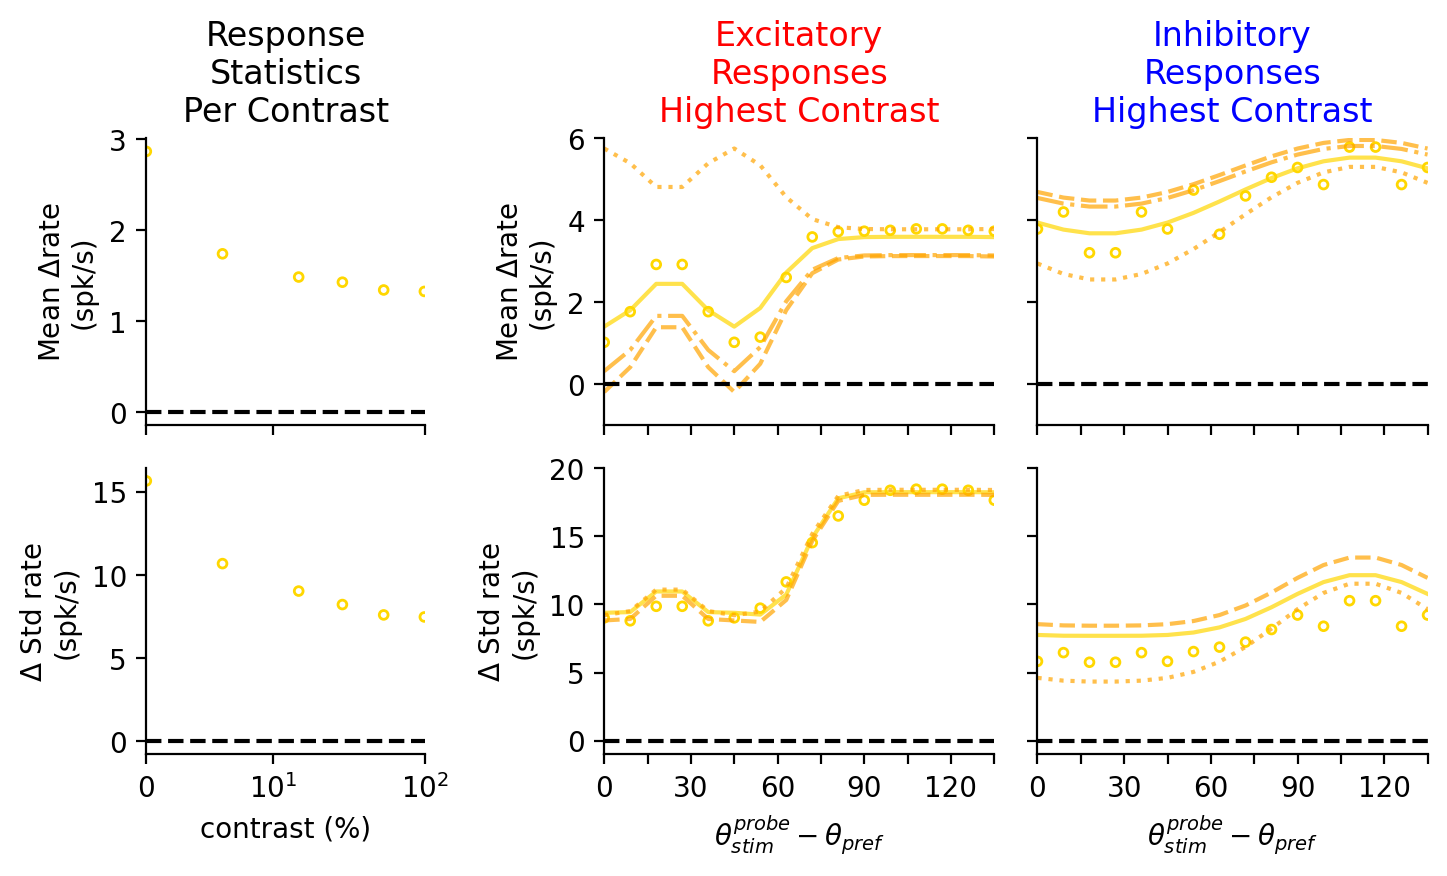

In [311]:
with open('./data_contrasts'+'.pkl', 'rb') as handle:
    cons = pickle.load(handle)[1]

def abs_ori(A):
    return 0.5*(A[:nori*3//4+1]+np.roll(A[-1::-1],6,0)[:nori*3//4+1])

fig,axs = plt.subplots(2,4,figsize=(2*4.133,2*2),dpi=200,sharex='col',width_ratios=(3,1,4.2,4.2))
fig.subplots_adjust(hspace=0.15,wspace=0.15)
for i in range(2):
    axs[i,1].set_axis_off()
    axs[i,2].yaxis.set_tick_params(which='both',labelleft=True)
    axs[i,3].yaxis.set_tick_params(which='both',labelleft=False)
axs = axs[:,[0,2,3]]

axs[0,0].scatter(cons,sim_dr,edgecolors='gold',facecolors='none',marker='o',s=10)
axs[0,1].plot(oris,roE-rvE,c='gold',ls='-',alpha=0.7,label='a')
axs[0,1].plot(oris,drE0,c='orange',ls=':',alpha=0.7,label='a')
axs[0,1].plot(oris,drE,c='orange',ls='--',alpha=0.7,label='a')
axs[0,1].plot(oris,drE0dis,c='orange',ls='-.',alpha=0.7,label='a')
# axs[0,1].legend()
axs[0,1].scatter(oris,abs_ori(sim_roE-sim_rvE),edgecolors='gold',facecolors='none',marker='o',s=10)
axs[0,2].plot(oris,roI-rvI,c='gold',ls='-',alpha=0.7)
axs[0,2].plot(oris,drI0,c='orange',ls=':',alpha=0.7)
axs[0,2].plot(oris,drI,c='orange',ls='--',alpha=0.7)
axs[0,2].plot(oris,drI0dis,c='orange',ls='-.',alpha=0.7)
axs[0,2].scatter(oris,abs_ori(sim_roI-sim_rvI),edgecolors='gold',facecolors='none',marker='o',s=10)
axs[1,0].scatter(cons,sim_dstdr,edgecolors='gold',facecolors='none',marker='o',s=10)
axs[1,1].plot(oris,np.sqrt(CroE-roE**2)-np.sqrt(CrvE-rvE**2),c='gold',ls='-',alpha=0.7)
axs[1,1].plot(oris,np.sqrt(CrvE+dCrE0-(rvE+drE0)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls=':',alpha=0.7)
axs[1,1].plot(oris,np.sqrt(CrvE+dCrE-(rvE+drE)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls='--',alpha=0.7)
# axs[1,1].plot(oris,np.sqrt(CrvE+dCrE0dis-(rvE+drE0dis)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls='-.',alpha=0.7)
axs[1,1].scatter(oris,abs_ori(sim_std_roE-sim_std_rvE),edgecolors='gold',facecolors='none',marker='o',s=10)
axs[1,2].plot(oris,np.sqrt(CroI-roI**2)-np.sqrt(CrvI-rvI**2),c='gold',ls='-',alpha=0.7)
axs[1,2].plot(oris,np.sqrt(CrvI+dCrI0-(rvI+drI0)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls=':',alpha=0.7)
axs[1,2].plot(oris,np.sqrt(CrvI+dCrI-(rvI+drI)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls='--',alpha=0.7)
# axs[1,2].plot(oris,np.sqrt(CrvI+dCrI0dis-(rvI+drI0dis)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls='-.',alpha=0.7)
axs[1,2].scatter(oris,abs_ori(sim_std_roI-sim_std_rvI),edgecolors='gold',facecolors='none',marker='o',s=10)

for i in range(2):
    for j in range(3):
        axs[i,j].axhline(0,c='k',ls='--')
    
# axs[0,1].legend()
# axs[1,1].legend()
# axs[2,1].legend()

for ax in axs.flat:
    ax.spines[['right', 'top']].set_visible(False)

axs[0,0].set_xscale('symlog', linthresh=12)
nticks = 10
ticks = np.array(['{:.0f}'.format(ori) for ori in np.linspace(0,135,nticks)])
ticks[1::2] = ''
for i in range(1,3):
    axs[1,i].set_xticks(np.linspace(0,135,nticks),ticks)

axs[0,0].set_xlim(0,100)
axs[0,1].set_xlim(0,135)
axs[0,2].set_xlim(0,135)
for i in range(1,3):
    axs[0,i].set_ylim(-1,6)
    axs[1,i].set_ylim(-1,20)

axs[1,0].set_xlabel('contrast (%)')
axs[1,1].set_xlabel(r'$\theta_{stim}^{probe}-\theta_{pref}$')
axs[1,2].set_xlabel(r'$\theta_{stim}^{probe}-\theta_{pref}$')

for i in range(2):
    axs[0,i].set_ylabel(r'Mean $\Delta$rate'+'\n(spk/s)')
    axs[1,i].set_ylabel(r'$\Delta$ Std rate'+'\n(spk/s)')

axs[0,0].set_title('Response\nStatistics\nPer Contrast',color='k')
axs[0,1].set_title('Excitatory\nResponses\nHighest Contrast',color='r')
axs[0,2].set_title('Inhibitory\nResponses\nHighest Contrast',color='b')

# fig.tight_layout()
fig.savefig('./../plots/delta_rate_norm_lin_resp_test.pdf')

# Calculate Two Grating Linear Response for All Contrasts

In [351]:
res_dict_inits = [None]*6
res_dict_perts = [None]*6

for c_idx in range(6):
    with open('./../results/dmft_opto_norm_id_None_c_{:d}'.format(c_idx)+'.pkl','rb') as\
            handle:
        this_res_dict = pickle.load(handle)['dmft_res']
    if c_idx==0:
        res_dict_inits[c_idx] = {key: this_res_dict[key][:2] for key in ['r','Cr','mu','Sig']}
        res_dict_perts[c_idx] = {key: this_res_dict[key][2:] for key in ['r','Cr','mu','Sig']}
    else:
        res_dict_inits[c_idx] = {key: this_res_dict[key][:2] for key in ['rb','rp','sr','Crb','Crp','sCr',
                                                                         'mub','mup','Sigb','Sigp']}
        res_dict_perts[c_idx] = {key: this_res_dict[key][2:] for key in ['rb','rp','sr','Crb','Crp','sCr',
                                                                         'mub','mup','Sigb','Sigp']}

In [444]:
reload(dmft)

Twrm = 1.2
Tsav = 0.4
dt = 0.01/5

res_dict_decoups = [None]*6

for c_idx in range(1,6):
    # res_dict_decoups[c_idx] = dmft.run_decoupled_three_site_dmft(prms,bX,aXs[c_idx]/bX,eX,'./../results',ri,
    #                                                              Twrm,Tsav,dt,
    #                                                            struct_dict=res_dict_inits[c_idx],
    #                                                            which='opto',return_full=True)
    # with open('./decoup_resp_2feat_c_{:d}.pkl'.format(c_idx),'wb') as handle:
    #     pickle.dump(res_dict_decoups[c_idx],handle)
        
    with open('./decoup_resp_2feat_c_{:d}.pkl'.format(c_idx),'rb') as handle:
        res_dict_decoups[c_idx] = pickle.load(handle)

In [367]:
np.max(np.abs(np.linalg.eigvals(np.linalg.solve(Mps,Mpc)@np.linalg.solve(Mps,Mpc))))

0.22803815344608158

In [517]:
def calc_lin_resp(res_dict_init,res_dict_decoup):
    δrb0 = res_dict_decoup['rb'] - res_dict_init['rb']
    δrp0 = res_dict_decoup['rp'] - res_dict_init['rp']
    δCrb0 = res_dict_decoup['Crb'] - res_dict_init['Crb']
    δCrp0 = res_dict_decoup['Crp'] - res_dict_init['Crp']
    
    xpeaks = np.array([0,-dori])
    sW = np.array([[SoriE,SoriI],[SoriE,SoriI]],dtype=np.float32)
    sW2 = sW**2
    sWr = np.sqrt(sW2+sr**2)
    sWCr = np.sqrt(sW2+sCr**2)
    rOinv = dmft.inv_overlap(xpeaks,sr[:,None])[:,:,0]
    CrOinv = dmft.inv_overlap(xpeaks,sCr[:,None])[:,:,0]

    muWbb = (1 - 2*dmft.struct_fact(180/2,sWr,sr,180)*np.sum(rOinv,-1)[None,:]) * muW 
    muWbp = dmft.struct_fact(180/2,sWr,sr,180)*np.sum(rOinv,-1)[None,:] * muW
    muWpb = (1 - (dmft.struct_fact(0,sWr,sr,180) + dmft.struct_fact(dori,sWr,sr,180))*np.sum(rOinv,-1)[None,:]) * muW
    muWps = (dmft.struct_fact(0,sWr,sr,180)*rOinv[None,:,0] + dmft.struct_fact(dori,sWr,sr,180)*rOinv[None,:,1]) * muW
    muWpc = (dmft.struct_fact(dori,sWr,sr,180)*rOinv[None,:,0] + dmft.struct_fact(0,sWr,sr,180)*rOinv[None,:,1]) * muW
    
    SigWbb = (1 - 2*dmft.struct_fact(180/2,sWCr,sCr,180)*np.sum(CrOinv,-1)[None,:]) * SigW
    SigWbp = dmft.struct_fact(180/2,sWCr,sCr,180)*np.sum(CrOinv,-1)[None,:] * SigW
    SigWpb = (1 - (dmft.struct_fact(0,sWCr,sCr,180) + dmft.struct_fact(dori,sWCr,sCr,180))*np.sum(CrOinv,-1)[None,:]) * SigW
    SigWps = (dmft.struct_fact(0,sWCr,sCr,180)*CrOinv[None,:,0] +\
        dmft.struct_fact(dori,sWCr,sCr,180)*CrOinv[None,:,1]) * SigW
    SigWpc = (dmft.struct_fact(dori,sWCr,sCr,180)*CrOinv[None,:,0] +\
        dmft.struct_fact(0,sWCr,sCr,180)*CrOinv[None,:,1]) * SigW

    block_muW = np.block([
        [muWbb,muWbp,muWbp],
        [muWpb,muWps,muWpc],
        [muWpb,muWpc,muWps]
    ])
    block_SigW = np.block([
        [SigWbb,SigWbp,SigWbp],
        [SigWpb,SigWps,SigWpc],
        [SigWpb,SigWpc,SigWps]
    ])

    NP = 2
    NT = int(np.round(Tsav/dt)+1)

    block_mu = np.concatenate([res_dict_decoup['mub'],res_dict_decoup['mup'],res_dict_decoup['mup']])
    block_Sig = np.concatenate([res_dict_decoup['Sigb'],res_dict_decoup['Sigp'],res_dict_decoup['Sigp']],0)
    
    res_dict_lin_resp = dmft.lin_resp_mats(np.concatenate([tau,tau,tau]),block_muW,block_SigW,
                                        np.zeros(6),np.zeros(6),block_opto_M,block_opto_C,Tsav,dt,
                                        block_mu,block_Sig)

    A = res_dict_lin_resp['A']
    B = res_dict_lin_resp['B']
    C = res_dict_lin_resp['C']
    D = res_dict_lin_resp['D']
    D0dis = res_dict_lin_resp['D0dis'][:2,:,:2,:]
    
    Abb,Abp,Apb,Aps,Apc = A[0:2,  0:2],  A[0:2,  2:4],  A[2:4,  0:2],  A[2:4,  2:4],  A[2:4,  4:6]
    Bbb,Bbp,Bpb,Bps,Bpc = B[0:2,  0:2,:],B[0:2,  2:4,:],B[2:4,  0:2,:],B[2:4,  2:4,:],B[2:4,  4:6,:]
    Cbb,Cbp,Cpb,Cps,Cpc = C[0:2,:,0:2],  C[0:2,:,2:4],  C[2:4,:,0:2],  C[2:4,:,2:4],  C[2:4,:,4:6]
    Dbb,Dbp,Dpb,Dps,Dpc = D[0:2,:,0:2,:],D[0:2,:,2:4,:],D[2:4,:,0:2,:],D[2:4,:,2:4,:],D[2:4,:,4:6,:]
    
    Mbb = np.block([[Abb,Bbb.reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
    Mbp = np.block([[Abp,Bbp.reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
    Mpb = np.block([[Apb,Bpb.reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
    Mps = np.block([[Aps,Bps.reshape(NP,NP*NT)],[Cps.reshape(NP*NT,NP),Dps.reshape(NP*NT,NP*NT)]])
    Mpc = np.block([[Apc,Bpc.reshape(NP,NP*NT)],[Cpc.reshape(NP*NT,NP),Dpc.reshape(NP*NT,NP*NT)]])
    
    Xbp = -np.linalg.solve(Mbb,Mbp)
    Xpb = -np.linalg.solve(Mps,Mpb)
    Xpc = -np.linalg.solve(Mps,Mpc)
    # Xps = np.linalg.inv(np.eye(NP*(NT+1)) - Xpc)
    Xps = np.eye(NP*(NT+1)) + Xpc

    Mbb0dis = np.block([[Abb,np.zeros_like(Bbb).reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
    Mbp0dis = np.block([[Abp,np.zeros_like(Bbp).reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
    Mpb0dis = np.block([[Apb,np.zeros_like(Bpb).reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
    Mps0dis = np.block([[Aps,np.zeros_like(Bps).reshape(NP,NP*NT)],[Cps.reshape(NP*NT,NP),Dps.reshape(NP*NT,NP*NT)]])
    Mpc0dis = np.block([[Apc,np.zeros_like(Bpc).reshape(NP,NP*NT)],[Cpc.reshape(NP*NT,NP),Dpc.reshape(NP*NT,NP*NT)]])
    # Mbb0dis = np.block([[Abb,Bbb.reshape(NP,NP*NT)],[np.zeros_like(Cbb).reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
    # Mbp0dis = np.block([[Abp,Bbp.reshape(NP,NP*NT)],[np.zeros_like(Cbp).reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
    # Mpb0dis = np.block([[Apb,Bpb.reshape(NP,NP*NT)],[np.zeros_like(Cpb).reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
    # Mps0dis = np.block([[Aps,Bps.reshape(NP,NP*NT)],[np.zeros_like(Cps).reshape(NP*NT,NP),Dps.reshape(NP*NT,NP*NT)]])
    # Mpc0dis = np.block([[Apc,Bpc.reshape(NP,NP*NT)],[np.zeros_like(Cpc).reshape(NP*NT,NP),Dpc.reshape(NP*NT,NP*NT)]])
    
    Xbp0dis = Xbp.copy()
    Xbp0dis[:2,:2] = -np.linalg.solve(Abb,Abp)
    Xbp0dis[:2,2:] = 0
    Xpb0dis = Xpb.copy()
    Xpb0dis[:2,:2] = -np.linalg.solve(Aps,Apb)
    Xpb0dis[:2,2:] = 0
    Xpc0dis = Xpc.copy()
    Xpc0dis[:2,:2] = -np.linalg.solve(Aps,Apc)
    Xpc0dis[:2,2:] = 0
    Xps0dis = np.eye(NP*(NT+1)) + Xpc0dis

    δmb0 = np.concatenate([δrb0,δCrb0.flatten()])
    δmp0 = np.concatenate([δrp0,δCrp0.flatten()])

    fb = Mbb@δmb0
    fp = Mpp@δmp0

    M = np.block([[Mbb,Mbp,Mbp],[Mpb,Mps,Mpc],[Mpb,Mpc,Mps]])
    M0dis = np.block([[Mbb0dis,Mbp0dis,Mbp0dis],[Mpb0dis,Mps0dis,Mpc0dis],[Mpb0dis,Mpc0dis,Mps0dis]])
    f = np.concatenate([fb,fp,fp])
    
    # δm = np.linalg.solve(M,f)
    # δm = np.concatenate([δmb0+2*Xbp@δmp0,
    #                      δmp0+Xpb@δmb0+Xpc@δmp0])
    δm = np.concatenate([δmb0,
                         δmp0+Xpb@δmb0+Xpc@δmp0])
    # δm = np.concatenate([δmb0,
    #                      δmp0+Xps@(Xpb@δmb0+Xpc@δmp0)])
    
    # δm1 = np.concatenate([δmb0+2*Xbp@(δmp0+Xpb@δmb0+Xpc@δmp0),
    #                       δmp0+Xpb@(δmb0+2*Xbp@δmp0)+Xpc@(δmp0+Xpb@δmb0+Xpc@δmp0)])
    # δm1 = np.concatenate([δmb0+2*Xbp@(δmp0+Xpb@δmb0+Xpc@δmp0),
    #                       δmp0+Xpb@(δmb0+2*Xbp@δmp0)+Xpc@(δmp0+Xpb@δmb0+Xpc@δmp0)])
    # δm1 = np.concatenate([δmb0+2*Xbp@δmp0,
    #                       δmp0+Xpb@(δmb0+2*Xbp@δmp0)+Xpc@δmp0])
    δm1 = np.concatenate([δmb0,
                         δmp0+Xps@(Xpb@δmb0+Xpc@δmp0)])
    # δm0dis = np.linalg.solve(M0dis,f)
    # δm0dis = np.concatenate([δmb0+2*Xbp0dis@δmp0,
    #                          δmp0+Xpb0dis@δmb0+Xpc0dis@δmp0])
    δm0dis = np.concatenate([δmb0,
                             δmp0+Xpb0dis@δmb0+Xpc0dis@δmp0])
    # δm0dis = np.concatenate([δmb0,
    #                          δmp0+Xps0dis@(Xpb0dis@δmb0+Xpc0dis@δmp0)])
    # δm0dis1 = np.concatenate([δmb0+2*Xbp0dis@(δmp0+Xpb0dis@δmb0+Xpc0dis@δmp0),
    #                           δmp0+Xpb0dis@(δmb0+2*Xbp0dis@δmp0)+Xpc0dis@(δmp0+Xpb0dis@δmb0+Xpc0dis@δmp0)])
    # δm0dis1 = np.concatenate([δmb0+2*Xbp0dis@(δmp0+Xpb0dis@δmb0+Xpc0dis@δmp0),
    #                           δmp0+Xpb0dis@(δmb0+2*Xbp0dis@δmp0)+Xpc0dis@(δmp0+Xpb0dis@δmb0)])
    # δm0dis1 = np.concatenate([δmb0+2*Xbp0dis@δmp0,
    #                           δmp0+Xpb0dis@(δmb0+2*Xbp0dis@δmp0)+Xpc0dis@δmp0])
    δm0dis1 = np.concatenate([δmb0,
                             δmp0+Xps0dis@(Xpb0dis@δmb0+Xpc0dis@δmp0)])

    δmb = δm[:NP+NP*NT]
    δmp = δm[NP+NP*NT:]

    δmb1 = δm1[:NP+NP*NT]
    δmp1 = δm1[NP+NP*NT:]

    δmb0dis = δm0dis[:NP+NP*NT]
    δmp0dis = δm0dis[NP+NP*NT:]

    δmb0dis1 = δm0dis1[:NP+NP*NT]
    δmp0dis1 = δm0dis1[NP+NP*NT:]

    δrb = δmb[:NP]
    δCrb = δmb[NP:].reshape(NP,NT)
    δrp = δmp[:NP]
    δCrp = δmp[NP:].reshape(NP,NT)

    δrb1 = δmb1[:NP]
    δCrb1 = δmb1[NP:].reshape(NP,NT)
    δrp1 = δmp1[:NP]
    δCrp1 = δmp1[NP:].reshape(NP,NT)

    δrb0dis = δmb0dis[:NP]
    δCrb0dis = δmb0dis[NP:].reshape(NP,NT)
    δrp0dis = δmp0dis[:NP]
    δCrp0dis = δmp0dis[NP:].reshape(NP,NT)

    δrb0dis1 = δmb0dis1[:NP]
    δCrb0dis1 = δmb0dis1[NP:].reshape(NP,NT)
    δrp0dis1 = δmp0dis1[:NP]
    δCrp0dis1 = δmp0dis1[NP:].reshape(NP,NT)
    
    res_dict = {}
    
    res_dict['drb0'] = δrb0
    res_dict['drp0'] = δrp0
    res_dict['dCrb0'] = δCrb0
    res_dict['dCrp0'] = δCrp0
    res_dict['drb'] = δrb
    res_dict['drp'] = δrp
    res_dict['dCrb'] = δCrb
    res_dict['dCrp'] = δCrp
    res_dict['drb1'] = δrb1
    res_dict['drp1'] = δrp1
    res_dict['dCrb1'] = δCrb1
    res_dict['dCrp1'] = δCrp1
    res_dict['drb0dis'] = δrb0dis
    res_dict['drp0dis'] = δrp0dis
    res_dict['dCrb0dis'] = δCrb0dis
    res_dict['dCrp0dis'] = δCrp0dis
    res_dict['drb0dis1'] = δrb0dis1
    res_dict['drp0dis1'] = δrp0dis1
    res_dict['dCrb0dis1'] = δCrb0dis1
    res_dict['dCrp0dis1'] = δCrp0dis1
    
    return res_dict

In [534]:
np.linalg.inv(np.eye(NP*(NT+1)) - Xpc)[:2,:2]

array([[ 0.75768533, -0.01290326],
       [ 0.10289496,  0.89869899]])

In [537]:
Xbp = -np.linalg.solve(Mbb,Mbp)
Xpb = -np.linalg.solve(Mps,Mpb)
Xpc = -np.linalg.solve(Mps,Mpc)

print((2*Xbp@δmp0)[:2])
print((Xpc@δmp0)[:2])
print((Xpb@δmb0)[:2])
print((2*Xpb@Xbp@δmp0)[:2])
print((Xpc@Xpc@δmp0)[:2])
print((2*Xpc@Xpb@δmb0)[:2])

[-0.65452042  0.42974316]
[-2.06246233  0.57842743]
[-3.88630339  1.16958063]
[ 0.60132526 -0.32168017]
[ 0.64541573 -0.36642362]
[ 2.43443923 -1.39987145]


In [535]:
Xpc[:2,:2]

array([[-0.3177177 , -0.02157818],
       [ 0.14984606, -0.10948074]])

In [519]:
Xbp[:2,:2]

array([[-0.04827152, -0.01018944],
       [ 0.07167268, -0.08486062]])

In [520]:
(Xpb@Xbp)[:2,:2]

array([[ 0.04351393,  0.01203888],
       [-0.02728824,  0.00285088]])

In [521]:
Xpb[:2,:2]

array([[-0.92297032, -0.01792466],
       [ 0.43530298, -0.09094396]])

In [522]:
res_dict_lin_resps = [None]*6

for c_idx in range(1,6):
    res_dict_lin_resps[c_idx] = calc_lin_resp(res_dict_inits[c_idx],res_dict_decoups[c_idx])

In [523]:
dmft_dr = np.zeros(6)
dmft_dr1 = np.zeros(6)
dmft_dr0 = np.zeros(6)
dmft_drfull = np.zeros(6)
dmft_drfull1 = np.zeros(6)
dmft_dr0dis = np.zeros(6)
dmft_dr0dis1 = np.zeros(6)
dmft_dstdr = np.zeros(6)
dmft_dstdr1 = np.zeros(6)
dmft_dstdr0 = np.zeros(6)
dmft_dstdrfull = np.zeros(6)
dmft_dstdrfull1 = np.zeros(6)
dmft_dstdr0dis = np.zeros(6)
dmft_dstdr0dis1 = np.zeros(6)

for c_idx in range(6):
    if c_idx==0:
        dmft_dr[c_idx] = np.sum(np.array([0.8,0.2])*(res_dict_perts[c_idx]['r'] - res_dict_inits[c_idx]['r']))
        dmft_dr0[c_idx] = np.nan
        dmft_drfull[c_idx] = np.nan
        dmft_drfull1[c_idx] = np.nan
        dmft_dr0dis[c_idx] = np.nan
        dmft_dr0dis1[c_idx] = np.nan
        
        dmft_dstdr[c_idx] = np.sqrt(np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_perts[c_idx]['Cr'],1,dt)-res_dict_perts[c_idx]['r']**2))) -\
            np.sqrt(np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_inits[c_idx]['Cr'],1,dt)-res_dict_inits[c_idx]['r']**2)))
        dmft_dstdr0[c_idx] = np.nan
        dmft_dstdrfull[c_idx] = np.nan
        dmft_dstdrfull1[c_idx] = np.nan
        dmft_dstdr0dis[c_idx] = np.nan
        dmft_dstdr0dis1[c_idx] = np.nan
    else:
        dmft_dr[c_idx] = np.sum(np.array([0.8,0.2])*(res_dict_perts[c_idx]['rp'] - res_dict_inits[c_idx]['rp']))
        dmft_dr0[c_idx] = np.sum(np.array([0.8,0.2])*res_dict_lin_resps[c_idx]['drp0'])
        dmft_drfull[c_idx] = np.sum(np.array([0.8,0.2])*res_dict_lin_resps[c_idx]['drp'])
        dmft_drfull1[c_idx] = np.sum(np.array([0.8,0.2])*res_dict_lin_resps[c_idx]['drp1'])
        dmft_dr0dis[c_idx] = np.sum(np.array([0.8,0.2])*res_dict_lin_resps[c_idx]['drp0dis'])
        dmft_dr0dis1[c_idx] = np.sum(np.array([0.8,0.2])*res_dict_lin_resps[c_idx]['drp0dis1'])
        
        init_varr = np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_inits[c_idx]['Crp'],1,dt)-res_dict_inits[c_idx]['rp']**2))
        dmft_dstdr[c_idx] = np.sqrt(np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_perts[c_idx]['Crp'],1,dt)-res_dict_perts[c_idx]['rp']**2))) -\
            np.sqrt(init_varr)
        dmft_dstdr0[c_idx] = np.sqrt(np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_decoups[c_idx]['Crp'],1,dt)-res_dict_decoups[c_idx]['rp']**2))) -\
            np.sqrt(init_varr)
        dmft_dstdrfull[c_idx] = np.sqrt(np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_inits[c_idx]['Crp']+res_dict_lin_resps[c_idx]['dCrp'],1,dt)-\
            (res_dict_inits[c_idx]['rp']+res_dict_lin_resps[c_idx]['drp'])**2))) -\
            np.sqrt(init_varr)
        dmft_dstdrfull1[c_idx] = np.sqrt(np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_inits[c_idx]['Crp']+res_dict_lin_resps[c_idx]['dCrp1'],1,dt)-\
            (res_dict_inits[c_idx]['rp']+res_dict_lin_resps[c_idx]['drp1'])**2))) -\
            np.sqrt(init_varr)
        dmft_dstdr0dis[c_idx] = np.sqrt(np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_inits[c_idx]['Crp']+res_dict_lin_resps[c_idx]['dCrp0dis'],1,dt)-\
            (res_dict_inits[c_idx]['rp']+res_dict_lin_resps[c_idx]['drp0dis'])**2))) -\
            np.sqrt(init_varr)
        dmft_dstdr0dis[c_idx] = np.sqrt(np.sum(np.array([0.8,0.2])*\
            (dmft.grid_stat(np.mean,res_dict_inits[c_idx]['Crp']+res_dict_lin_resps[c_idx]['dCrp0dis1'],1,dt)-\
            (res_dict_inits[c_idx]['rp']+res_dict_lin_resps[c_idx]['drp0dis1'])**2))) -\
            np.sqrt(init_varr)

In [524]:
print(dmft_dr)
print(dmft_dr0)
print(dmft_drfull)
print(dmft_drfull1)
print(dmft_dr0dis)

[3.32553329 2.27099457 2.08476944 1.97527847 1.93139114 1.90877304]
[       nan 5.27065353 5.23782272 5.21063766 5.19768982 5.19063339]
[       nan 1.13602782 0.95266571 0.83768843 0.79786104 0.78122243]
[       nan 2.24581001 2.15032569 2.0880118  2.06764575 2.05805884]
[       nan 1.5635144  1.36438333 1.23651448 1.18493552 1.15859563]


In [525]:
drE = gauss(oris,res_dict_lin_resps[5]['drb'][0],res_dict_lin_resps[5]['drp'][0],sr[0])
drI = gauss(oris,res_dict_lin_resps[5]['drb'][1],res_dict_lin_resps[5]['drp'][1],sr[1])
drE1 = gauss(oris,res_dict_lin_resps[5]['drb1'][0],res_dict_lin_resps[5]['drp1'][0],sr[0])
drI1 = gauss(oris,res_dict_lin_resps[5]['drb1'][1],res_dict_lin_resps[5]['drp1'][1],sr[1])
drE0dis = gauss(oris,res_dict_lin_resps[5]['drb0dis'][0],res_dict_lin_resps[5]['drp0dis'][0],sr[0])
drI0dis = gauss(oris,res_dict_lin_resps[5]['drb0dis'][1],res_dict_lin_resps[5]['drp0dis'][1],sr[1])
drE0dis1 = gauss(oris,res_dict_lin_resps[5]['drb0dis1'][0],res_dict_lin_resps[5]['drp0dis1'][0],sr[0])
drI0dis1 = gauss(oris,res_dict_lin_resps[5]['drb0dis1'][1],res_dict_lin_resps[5]['drp0dis1'][1],sr[1])

dCrE = gauss(oris,dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrb'][0:0+1],1,dt),
              dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrp'][0:0+1],1,dt),sCr[0])
dCrI = gauss(oris,dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrb'][1:1+1],1,dt),
              dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrp'][1:1+1],1,dt),sCr[1])
dCrE1 = gauss(oris,dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrb1'][0:0+1],1,dt),
              dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrp1'][0:0+1],1,dt),sCr[0])
dCrI1 = gauss(oris,dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrb1'][1:1+1],1,dt),
              dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrp1'][1:1+1],1,dt),sCr[1])
dCrE0dis = gauss(oris,dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrb0dis'][0:0+1],1,dt),
              dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrp0dis'][0:0+1],1,dt),sCr[0])
dCrI0dis = gauss(oris,dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrb0dis'][1:1+1],1,dt),
              dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrp0dis'][1:1+1],1,dt),sCr[1])
dCrE0dis1 = gauss(oris,dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrb0dis1'][0:0+1],1,dt),
              dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrp0dis1'][0:0+1],1,dt),sCr[0])
dCrI0dis1 = gauss(oris,dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrb0dis1'][1:1+1],1,dt),
              dmft.grid_stat(np.mean,res_dict_lin_resps[5]['dCrp0dis1'][1:1+1],1,dt),sCr[1])

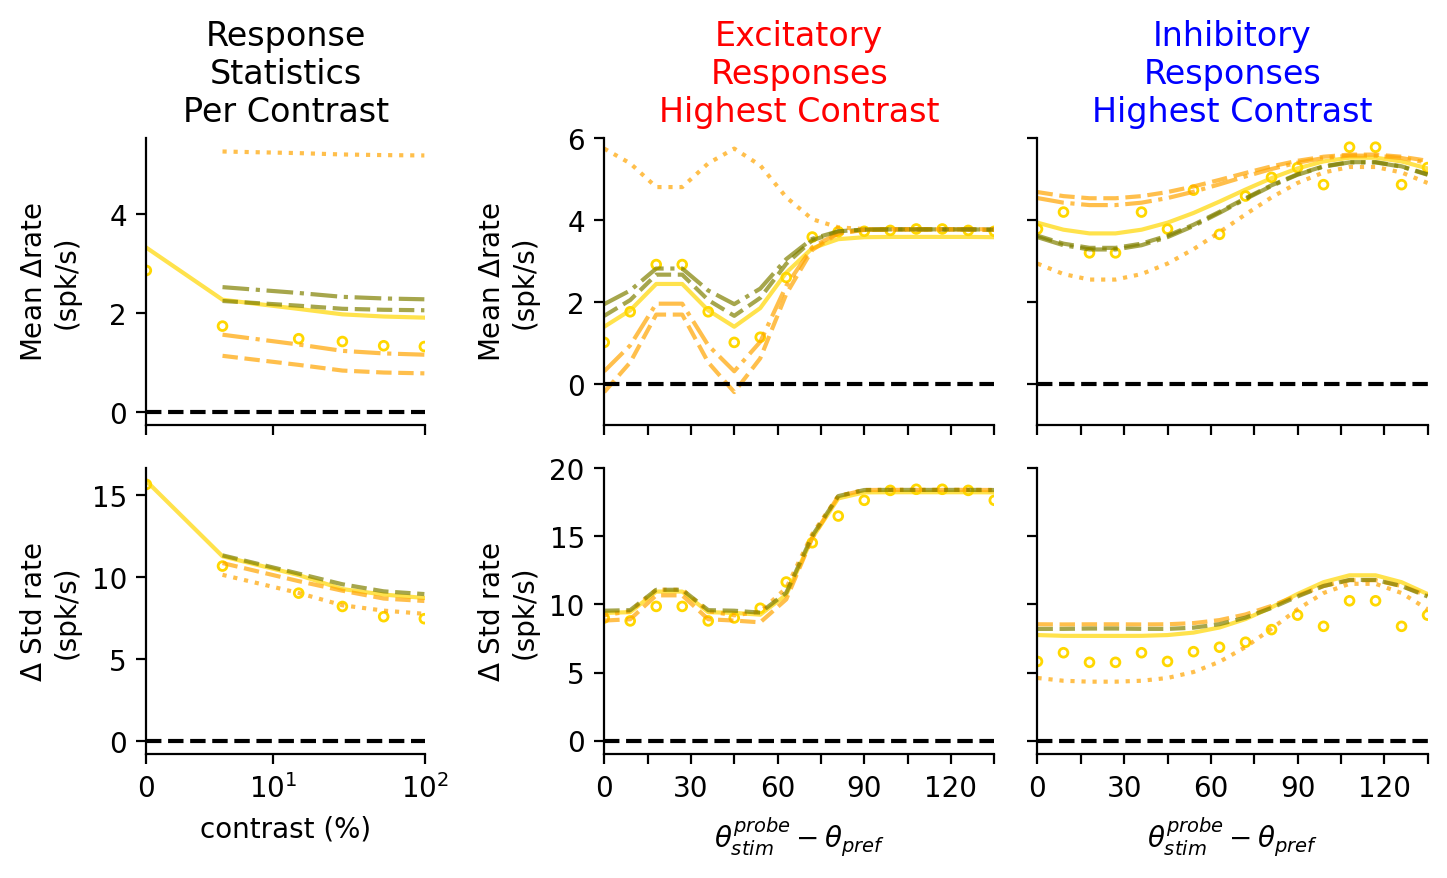

In [526]:
with open('./data_moments'+'.pkl', 'rb') as handle:
    data_preds = np.transpose(pickle.load(handle)[1],(1,0,2))
data_dr = np.concatenate([data_preds[:,1,0:1]-data_preds[:,0,0:1],
                          np.sqrt(data_preds[:,1,1:2]**2+data_preds[:,0,1:2]**2)],-1)
data_dstdr = np.concatenate([data_preds[:,3,0:1]-data_preds[:,2,0:1],
                             np.sqrt(data_preds[:,3,1:2]**2+data_preds[:,2,1:2]**2)],-1)
with open('./data_contrasts'+'.pkl', 'rb') as handle:
    cons = pickle.load(handle)[1]

def abs_ori(A):
    return 0.5*(A[:nori*3//4+1]+np.roll(A[-1::-1],6,0)[:nori*3//4+1])

fig,axs = plt.subplots(2,4,figsize=(2*4.133,2*2),dpi=200,sharex='col',width_ratios=(3,1,4.2,4.2))
fig.subplots_adjust(hspace=0.15,wspace=0.15)
for i in range(2):
    axs[i,1].set_axis_off()
    axs[i,2].yaxis.set_tick_params(which='both',labelleft=True)
    axs[i,3].yaxis.set_tick_params(which='both',labelleft=False)
axs = axs[:,[0,2,3]]

# axs[0,0].plot(cons,data_dr[:,0],color='gold',alpha=0.2)
# axs[0,0].fill_between(cons,data_dr[:,0]-data_dr[:,1],data_dr[:,0]+data_dr[:,1],color='gold',alpha=0.2)
axs[0,0].scatter(cons,sim_dr,edgecolors='gold',facecolors='none',marker='o',s=10)
axs[0,0].plot(cons,dmft_dr,c='gold',ls='-',alpha=0.7,label='a')
axs[0,0].plot(cons,dmft_dr0,c='orange',ls=':',alpha=0.7,label='a')
axs[0,0].plot(cons,dmft_drfull,c='orange',ls='--',alpha=0.7,label='a')
axs[0,0].plot(cons,dmft_drfull1,c='olive',ls='--',alpha=0.7,label='a')
axs[0,0].plot(cons,dmft_dr0dis,c='orange',ls='-.',alpha=0.7,label='a')
axs[0,0].plot(cons,dmft_dr0dis1,c='olive',ls='-.',alpha=0.7,label='a')
axs[0,1].plot(oris,roE-rvE,c='gold',ls='-',alpha=0.7,label='a')
axs[0,1].plot(oris,drE0,c='orange',ls=':',alpha=0.7,label='a')
axs[0,1].plot(oris,drE,c='orange',ls='--',alpha=0.7,label='a')
axs[0,1].plot(oris,drE1,c='olive',ls='--',alpha=0.7,label='a')
axs[0,1].plot(oris,drE0dis,c='orange',ls='-.',alpha=0.7,label='a')
axs[0,1].plot(oris,drE0dis1,c='olive',ls='-.',alpha=0.7,label='a')
# axs[0,1].legend()
axs[0,1].scatter(oris,abs_ori(sim_roE-sim_rvE),edgecolors='gold',facecolors='none',marker='o',s=10)
axs[0,2].plot(oris,roI-rvI,c='gold',ls='-',alpha=0.7)
axs[0,2].plot(oris,drI0,c='orange',ls=':',alpha=0.7)
axs[0,2].plot(oris,drI,c='orange',ls='--',alpha=0.7)
axs[0,2].plot(oris,drI1,c='olive',ls='--',alpha=0.7)
axs[0,2].plot(oris,drI0dis,c='orange',ls='-.',alpha=0.7)
axs[0,2].plot(oris,drI0dis1,c='olive',ls='-.',alpha=0.7)
axs[0,2].scatter(oris,abs_ori(sim_roI-sim_rvI),edgecolors='gold',facecolors='none',marker='o',s=10)
# axs[1,0].plot(cons,data_dstdr[:,0],color='gold',alpha=0.2)
# axs[1,0].fill_between(cons,data_dstdr[:,0]-data_dstdr[:,1],data_dstdr[:,0]+data_dstdr[:,1],color='gold',alpha=0.2)
axs[1,0].scatter(cons,sim_dstdr,edgecolors='gold',facecolors='none',marker='o',s=10)
axs[1,0].plot(cons,dmft_dstdr,c='gold',ls='-',alpha=0.7,label='a')
axs[1,0].plot(cons,dmft_dstdr0,c='orange',ls=':',alpha=0.7,label='a')
axs[1,0].plot(cons,dmft_dstdrfull,c='orange',ls='--',alpha=0.7,label='a')
axs[1,0].plot(cons,dmft_dstdrfull1,c='olive',ls='--',alpha=0.7,label='a')
# axs[1,0].plot(cons,dmft_dstdr0dis,c='orange',ls='-.',alpha=0.7,label='a')
axs[1,1].plot(oris,np.sqrt(CroE-roE**2)-np.sqrt(CrvE-rvE**2),c='gold',ls='-',alpha=0.7)
axs[1,1].plot(oris,np.sqrt(CrvE+dCrE0-(rvE+drE0)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls=':',alpha=0.7)
axs[1,1].plot(oris,np.sqrt(CrvE+dCrE-(rvE+drE)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls='--',alpha=0.7)
axs[1,1].plot(oris,np.sqrt(CrvE+dCrE1-(rvE+drE1)**2)-np.sqrt(CrvE-rvE**2),c='olive',ls='--',alpha=0.7)
# axs[1,1].plot(oris,np.sqrt(CrvE+dCrE0dis-(rvE+drE0dis)**2)-np.sqrt(CrvE-rvE**2),c='orange',ls='-.',alpha=0.7)
axs[1,1].scatter(oris,abs_ori(sim_std_roE-sim_std_rvE),edgecolors='gold',facecolors='none',marker='o',s=10)
axs[1,2].plot(oris,np.sqrt(CroI-roI**2)-np.sqrt(CrvI-rvI**2),c='gold',ls='-',alpha=0.7)
axs[1,2].plot(oris,np.sqrt(CrvI+dCrI0-(rvI+drI0)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls=':',alpha=0.7)
axs[1,2].plot(oris,np.sqrt(CrvI+dCrI-(rvI+drI)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls='--',alpha=0.7)
axs[1,2].plot(oris,np.sqrt(CrvI+dCrI1-(rvI+drI1)**2)-np.sqrt(CrvI-rvI**2),c='olive',ls='--',alpha=0.7)
# axs[1,2].plot(oris,np.sqrt(CrvI+dCrI0dis-(rvI+drI0dis)**2)-np.sqrt(CrvI-rvI**2),c='orange',ls='-.',alpha=0.7)
axs[1,2].scatter(oris,abs_ori(sim_std_roI-sim_std_rvI),edgecolors='gold',facecolors='none',marker='o',s=10)

for i in range(2):
    for j in range(3):
        axs[i,j].axhline(0,c='k',ls='--')
    
# axs[0,1].legend()
# axs[1,1].legend()
# axs[2,1].legend()

for ax in axs.flat:
    ax.spines[['right', 'top']].set_visible(False)

axs[0,0].set_xscale('symlog', linthresh=12)
nticks = 10
ticks = np.array(['{:.0f}'.format(ori) for ori in np.linspace(0,135,nticks)])
ticks[1::2] = ''
for i in range(1,3):
    axs[1,i].set_xticks(np.linspace(0,135,nticks),ticks)

axs[0,0].set_xlim(0,100)
axs[0,1].set_xlim(0,135)
axs[0,2].set_xlim(0,135)
for i in range(1,3):
    axs[0,i].set_ylim(-1,6)
    axs[1,i].set_ylim(-1,20)

axs[1,0].set_xlabel('contrast (%)')
axs[1,1].set_xlabel(r'$\theta_{stim}^{probe}-\theta_{pref}$')
axs[1,2].set_xlabel(r'$\theta_{stim}^{probe}-\theta_{pref}$')

for i in range(2):
    axs[0,i].set_ylabel(r'Mean $\Delta$rate'+'\n(spk/s)')
    axs[1,i].set_ylabel(r'$\Delta$ Std rate'+'\n(spk/s)')

axs[0,0].set_title('Response\nStatistics\nPer Contrast',color='k')
axs[0,1].set_title('Excitatory\nResponses\nHighest Contrast',color='r')
axs[0,2].set_title('Inhibitory\nResponses\nHighest Contrast',color='b')

fig.align_labels()

# fig.tight_layout()
fig.savefig('./../plots/delta_rate_norm_lin_resp_paper.pdf')

# Calculate Derivative of Peak Responses wrt Contrast

In [245]:
res_dict_norm_inits = [None]*6
res_dict_norm_perts = [None]*6

for c_idx in range(6):
    with open('./../results/dmft_opto_norm_id_None_c_{:d}'.format(c_idx)+'.pkl','rb') as\
            handle:
        this_res_dict = pickle.load(handle)['dmft_res']
    if c_idx==0:
        res_dict_norm_inits[c_idx] = {key: this_res_dict[key][:2] for key in ['r','Cr','mu','Sig']}
        res_dict_norm_perts[c_idx] = {key: this_res_dict[key][2:] for key in ['r','Cr','mu','Sig']}
    else:
        res_dict_norm_inits[c_idx] = {key: this_res_dict[key][:2] for key in ['rb','rp','sr','Crb','Crp','sCr',
                                                                              'mub','mup','Sigb','Sigp']}
        res_dict_norm_perts[c_idx] = {key: this_res_dict[key][2:] for key in ['rb','rp','sr','Crb','Crp','sCr',
                                                                              'mub','mup','Sigb','Sigp']}

In [296]:
rvEs = np.array([res_dict_inits[cidx]['rp'][0] for cidx in range(1,6)])
rvIs = np.array([res_dict_inits[cidx]['rp'][1] for cidx in range(1,6)])
roEs = np.array([res_dict_perts[cidx]['rp'][0] for cidx in range(1,6)])
roIs = np.array([res_dict_perts[cidx]['rp'][1] for cidx in range(1,6)])
r2vEs = np.array([res_dict_norm_inits[cidx]['rp'][0] for cidx in range(1,6)])
r2vIs = np.array([res_dict_norm_inits[cidx]['rp'][1] for cidx in range(1,6)])
r2oEs = np.array([res_dict_norm_perts[cidx]['rp'][0] for cidx in range(1,6)])
r2oIs = np.array([res_dict_norm_perts[cidx]['rp'][1] for cidx in range(1,6)])

Text(0, 0.5, '$\\frac{\\mathrm{d}}{\\mathrm{d}\\,c}$ Two Feature Peak I Mean Rate')

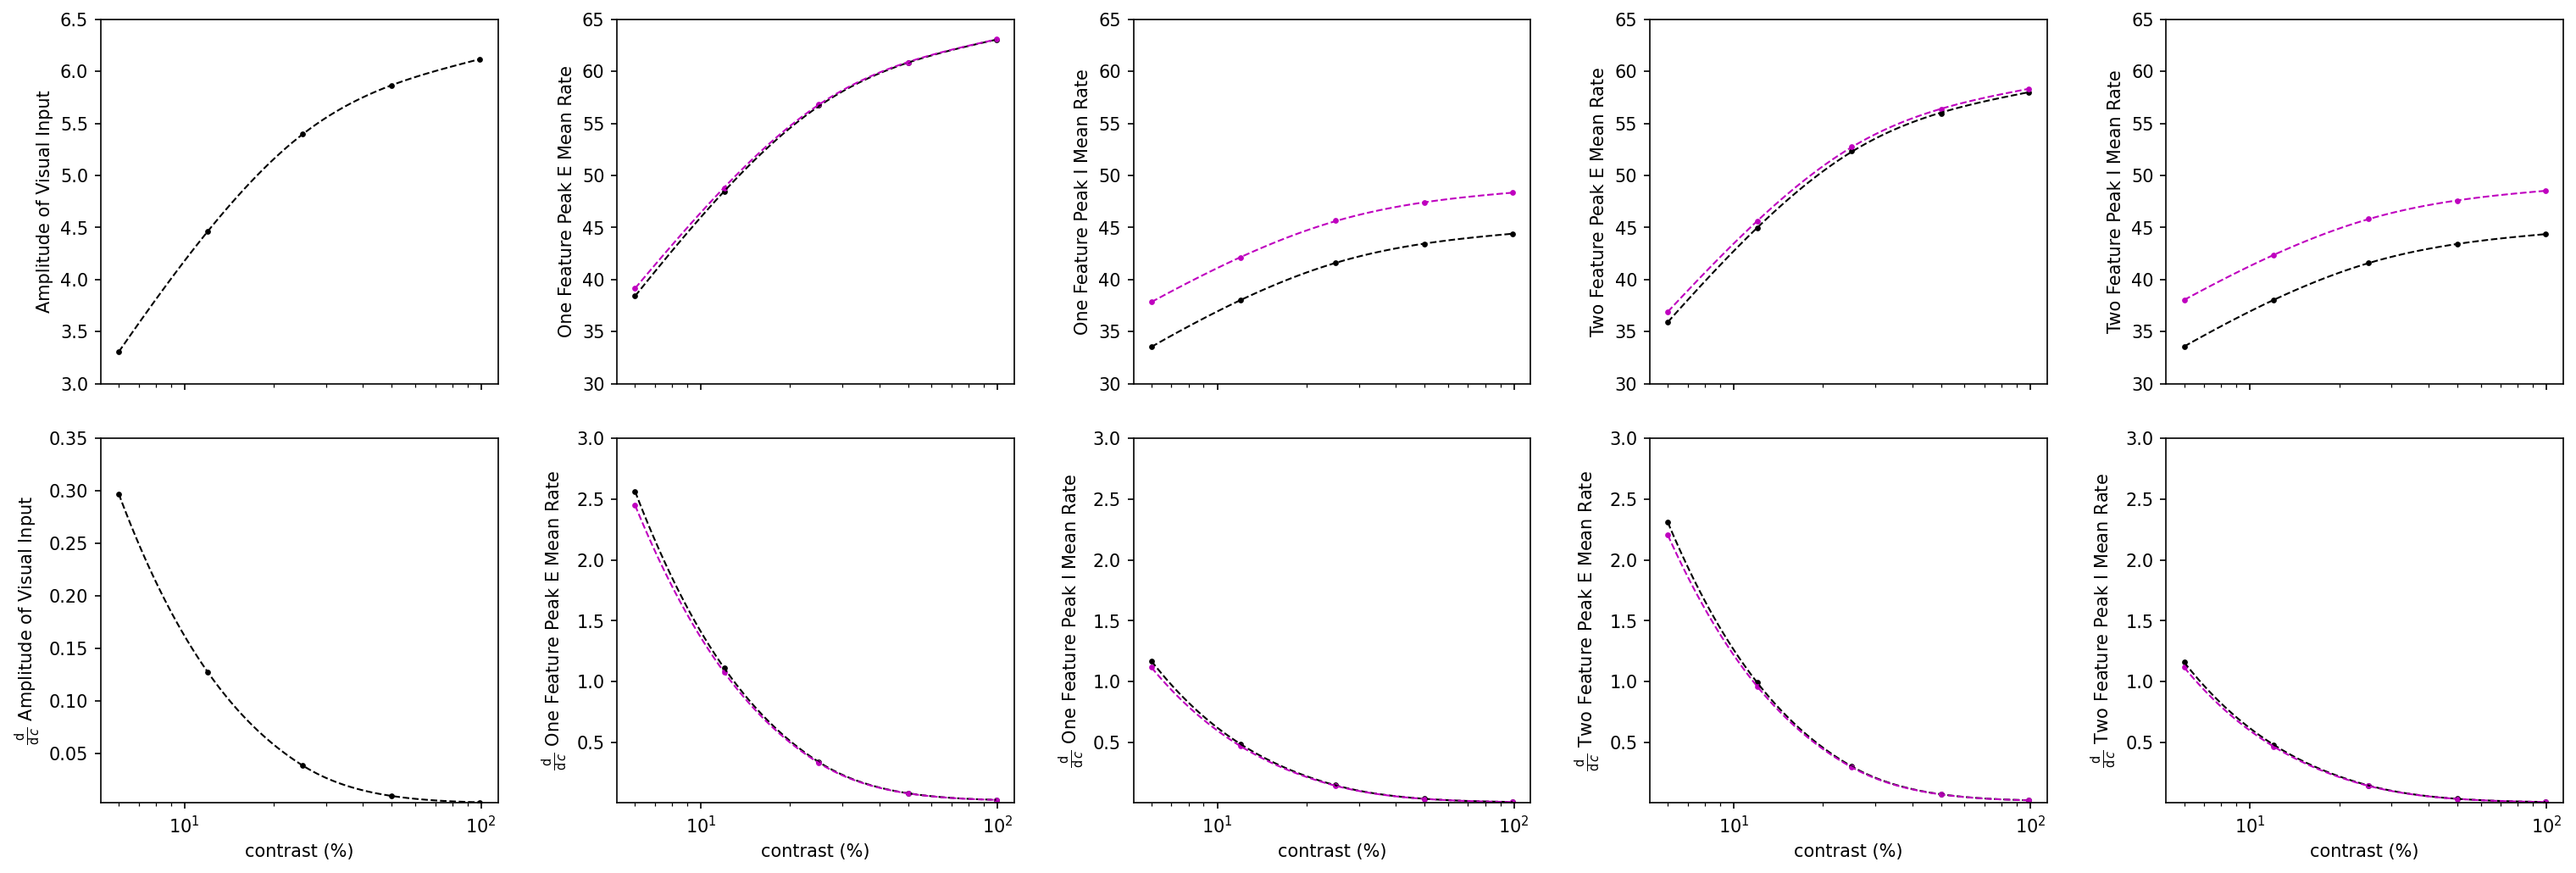

In [284]:
from scipy.interpolate import UnivariateSpline

fig,axs = plt.subplots(2,5,figsize=(25,8),dpi=150,sharex=True)
fig.subplots_adjust(hspace=0.15,wspace=0.3)

fine_log10cons = np.linspace(np.log10(cons[1]),np.log10(cons[-1]),101)

axs[0,0].scatter(cons[1:],aXs[1:],color='k',s=5)
itph = UnivariateSpline(np.log10(cons[1:]),aXs[1:],s=0.0001)
axs[0,0].plot(10**fine_log10cons,itph(fine_log10cons),'k--',lw=1)

axs[0,1].scatter(cons[1:],rvEs,color='k',s=5)
axs[0,2].scatter(cons[1:],rvIs,color='k',s=5)
itpvE = UnivariateSpline(np.log10(cons[1:]),[res_dict_inits[cidx]['rp'][0] for cidx in range(1,6)],s=0.01)
itpvI = UnivariateSpline(np.log10(cons[1:]),[res_dict_inits[cidx]['rp'][1] for cidx in range(1,6)],s=0.005)
axs[0,1].plot(10**fine_log10cons,itpvE(fine_log10cons),'k--',lw=1)
axs[0,2].plot(10**fine_log10cons,itpvI(fine_log10cons),'k--',lw=1)
axs[0,1].scatter(cons[1:],roEs,color='m',s=5)
axs[0,2].scatter(cons[1:],roIs,color='m',s=5)
itpoE = UnivariateSpline(np.log10(cons[1:]),[res_dict_perts[cidx]['rp'][0] for cidx in range(1,6)],s=0.01)
itpoI = UnivariateSpline(np.log10(cons[1:]),[res_dict_perts[cidx]['rp'][1] for cidx in range(1,6)],s=0.005)
axs[0,1].plot(10**fine_log10cons,itpoE(fine_log10cons),'m--',lw=1)
axs[0,2].plot(10**fine_log10cons,itpoI(fine_log10cons),'m--',lw=1)

axs[0,3].scatter(cons[1:],[res_dict_norm_inits[cidx]['rp'][0] for cidx in range(1,6)],color='k',s=5)
axs[0,4].scatter(cons[1:],[res_dict_norm_inits[cidx]['rp'][1] for cidx in range(1,6)],color='k',s=5)
itp2vE = UnivariateSpline(np.log10(cons[1:]),[res_dict_norm_inits[cidx]['rp'][0] for cidx in range(1,6)],s=0.01)
itp2vI = UnivariateSpline(np.log10(cons[1:]),[res_dict_norm_inits[cidx]['rp'][1] for cidx in range(1,6)],s=0.005)
axs[0,3].plot(10**fine_log10cons,itp2vE(fine_log10cons),'k--',lw=1)
axs[0,4].plot(10**fine_log10cons,itp2vI(fine_log10cons),'k--',lw=1)
axs[0,3].scatter(cons[1:],[res_dict_norm_perts[cidx]['rp'][0] for cidx in range(1,6)],color='m',s=5)
axs[0,4].scatter(cons[1:],[res_dict_norm_perts[cidx]['rp'][1] for cidx in range(1,6)],color='m',s=5)
itp2oE = UnivariateSpline(np.log10(cons[1:]),[res_dict_norm_perts[cidx]['rp'][0] for cidx in range(1,6)],s=0.01)
itp2oI = UnivariateSpline(np.log10(cons[1:]),[res_dict_norm_perts[cidx]['rp'][1] for cidx in range(1,6)],s=0.005)
axs[0,3].plot(10**fine_log10cons,itp2oE(fine_log10cons),'m--',lw=1)
axs[0,4].plot(10**fine_log10cons,itp2oI(fine_log10cons),'m--',lw=1)

ditph = itph.derivative()
ditpvE = itpvE.derivative()
ditpvI = itpvI.derivative()
ditpoE = itpoE.derivative()
ditpoI = itpoI.derivative()
ditp2vE = itp2vE.derivative()
ditp2vI = itp2vI.derivative()
ditp2oE = itp2oE.derivative()
ditp2oI = itp2oI.derivative()

axs[1,0].scatter(cons[1:],ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[1,0].plot(10**fine_log10cons,ditph(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)

axs[1,1].scatter(cons[1:],ditpvE(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[1,1].plot(10**fine_log10cons,ditpvE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[1,2].scatter(cons[1:],ditpvI(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[1,2].plot(10**fine_log10cons,ditpvI(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[1,1].scatter(cons[1:],ditpoE(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[1,1].plot(10**fine_log10cons,ditpoE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)
axs[1,2].scatter(cons[1:],ditpoI(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[1,2].plot(10**fine_log10cons,ditpoI(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)

axs[1,3].scatter(cons[1:],ditp2vE(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[1,3].plot(10**fine_log10cons,ditp2vE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[1,4].scatter(cons[1:],ditp2vI(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[1,4].plot(10**fine_log10cons,ditp2vI(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[1,3].scatter(cons[1:],ditp2oE(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[1,3].plot(10**fine_log10cons,ditp2oE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)
axs[1,4].scatter(cons[1:],ditp2oI(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[1,4].plot(10**fine_log10cons,ditp2oI(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)

axs[0,0].set_ylim(3,6.5)
axs[1,0].set_ylim(0.003,0.35)
for i in range(1,5):
    axs[0,i].set_ylim(30,65)
    axs[1,i].set_ylim(0.006,3)

for i in range(5):
    axs[1,i].set_xlabel('contrast (%)')
    axs[1,i].set_xscale('log')
    # axs[0,i].set_yscale('log')
    # axs[1,i].set_yscale('log')
    
axs[0,0].set_ylabel('Amplitude of Visual Input')
axs[0,1].set_ylabel('One Feature Peak E Mean Rate')
axs[0,2].set_ylabel('One Feature Peak I Mean Rate')
axs[0,3].set_ylabel('Two Feature Peak E Mean Rate')
axs[0,4].set_ylabel('Two Feature Peak I Mean Rate')
axs[1,0].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ Amplitude of Visual Input')
axs[1,1].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ One Feature Peak E Mean Rate')
axs[1,2].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ One Feature Peak I Mean Rate')
axs[1,3].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ Two Feature Peak E Mean Rate')
axs[1,4].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ Two Feature Peak I Mean Rate')

Text(0, 0.5, '$\\frac{\\mathrm{d}}{\\mathrm{d}\\,c}$ Two Feature Peak E Mean Rate')

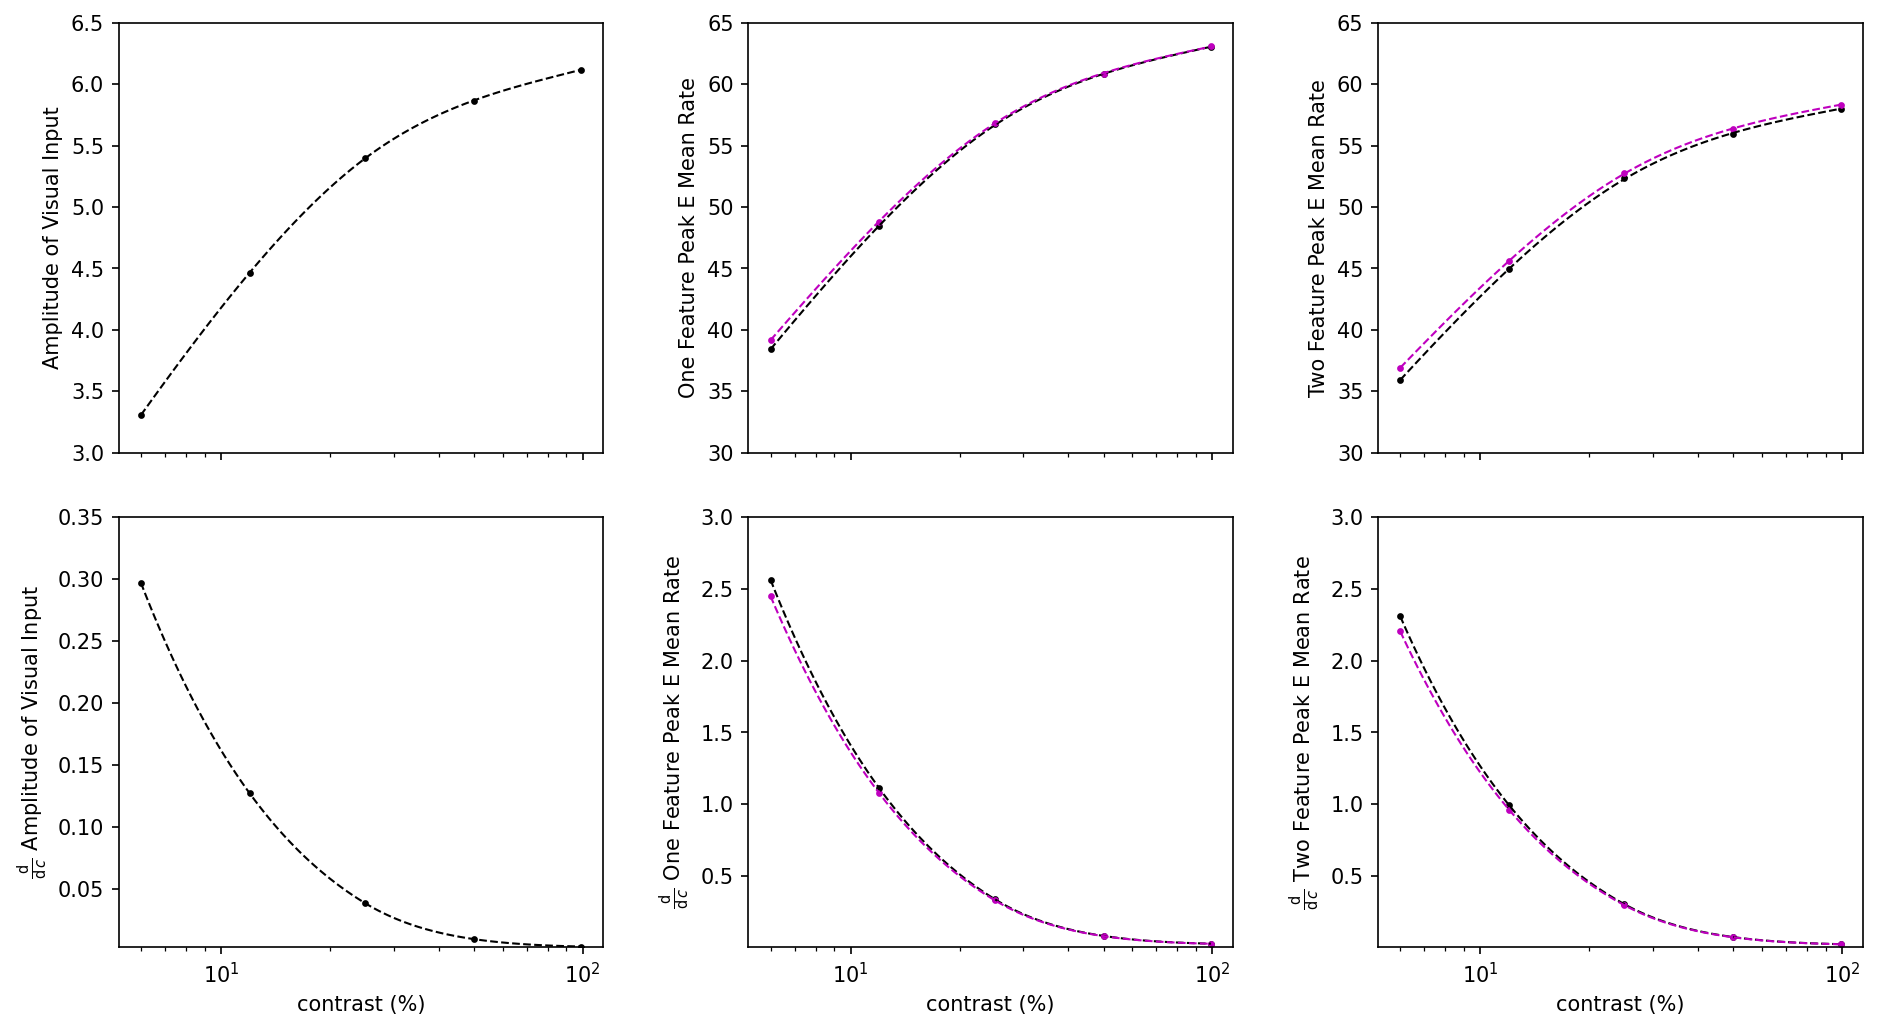

In [297]:
from scipy.interpolate import UnivariateSpline

fig,axs = plt.subplots(2,3,figsize=(15,8),dpi=150,sharex=True)
fig.subplots_adjust(hspace=0.15,wspace=0.3)

fine_log10cons = np.linspace(np.log10(cons[1]),np.log10(cons[-1]),101)

axs[0,0].scatter(cons[1:],aXs[1:],color='k',s=5)
axs[0,0].plot(10**fine_log10cons,itph(fine_log10cons),'k--',lw=1)

axs[0,1].scatter(cons[1:],rvEs,color='k',s=5)
axs[0,1].plot(10**fine_log10cons,itpvE(fine_log10cons),'k--',lw=1)
axs[0,1].scatter(cons[1:],roEs,color='m',s=5)
axs[0,1].plot(10**fine_log10cons,itpoE(fine_log10cons),'m--',lw=1)

axs[0,2].scatter(cons[1:],[res_dict_norm_inits[cidx]['rp'][0] for cidx in range(1,6)],color='k',s=5)
axs[0,2].plot(10**fine_log10cons,itp2vE(fine_log10cons),'k--',lw=1)
axs[0,2].scatter(cons[1:],[res_dict_norm_perts[cidx]['rp'][0] for cidx in range(1,6)],color='m',s=5)
axs[0,2].plot(10**fine_log10cons,itp2oE(fine_log10cons),'m--',lw=1)

axs[1,0].scatter(cons[1:],ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[1,0].plot(10**fine_log10cons,ditph(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)

axs[1,1].scatter(cons[1:],ditpvE(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[1,1].plot(10**fine_log10cons,ditpvE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[1,1].scatter(cons[1:],ditpoE(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[1,1].plot(10**fine_log10cons,ditpoE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)

axs[1,2].scatter(cons[1:],ditp2vE(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[1,2].plot(10**fine_log10cons,ditp2vE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[1,2].scatter(cons[1:],ditp2oE(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[1,2].plot(10**fine_log10cons,ditp2oE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)

axs[0,0].set_ylim(3,6.5)
axs[1,0].set_ylim(0.003,0.35)
for i in range(1,3):
    axs[0,i].set_ylim(30,65)
    axs[1,i].set_ylim(0.006,3)

for i in range(3):
    axs[1,i].set_xlabel('contrast (%)')
    axs[1,i].set_xscale('log')
    # axs[0,i].set_yscale('log')
    # axs[1,i].set_yscale('log')
    
axs[0,0].set_ylabel('Amplitude of Visual Input')
axs[0,1].set_ylabel('One Feature Peak E Mean Rate')
axs[0,2].set_ylabel('Two Feature Peak E Mean Rate')
axs[1,0].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ Amplitude of Visual Input')
axs[1,1].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ One Feature Peak E Mean Rate')
axs[1,2].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ Two Feature Peak E Mean Rate')

Text(0, 0.5, '$\\frac{\\mathrm{d}}{\\mathrm{d}\\,c}$ I Norm Weight')

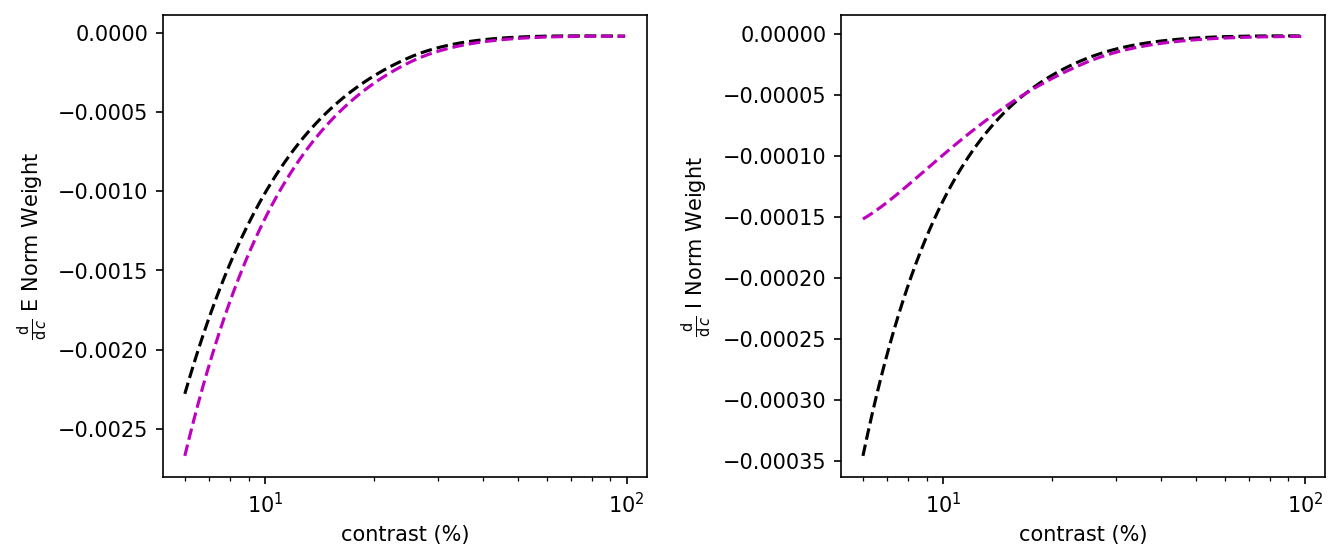

In [295]:
fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=150,sharex=True)
fig.subplots_adjust(hspace=0.15,wspace=0.4)

fine_rvEs = itpvE(fine_log10cons)
fine_rvIs = itpvI(fine_log10cons)
fine_roEs = itpoE(fine_log10cons)
fine_roIs = itpoI(fine_log10cons)
fine_r2vEs = itp2vE(fine_log10cons)
fine_r2vIs = itp2vI(fine_log10cons)
fine_r2oEs = itp2oE(fine_log10cons)
fine_r2oIs = itp2oI(fine_log10cons)

fine_drvEs = ditpvE(fine_log10cons)/(10**fine_log10cons*np.log(10))
fine_drvIs = ditpvI(fine_log10cons)/(10**fine_log10cons*np.log(10))
fine_droEs = ditpoE(fine_log10cons)/(10**fine_log10cons*np.log(10))
fine_droIs = ditpoI(fine_log10cons)/(10**fine_log10cons*np.log(10))
fine_dr2vEs = ditp2vE(fine_log10cons)/(10**fine_log10cons*np.log(10))
fine_dr2vIs = ditp2vI(fine_log10cons)/(10**fine_log10cons*np.log(10))
fine_dr2oEs = ditp2oE(fine_log10cons)/(10**fine_log10cons*np.log(10))
fine_dr2oIs = ditp2oI(fine_log10cons)/(10**fine_log10cons*np.log(10))

axs[0].plot(10**fine_log10cons,(fine_dr2vEs*fine_rvEs - fine_r2vEs*fine_drvEs)/fine_rvEs**2,'k--')
axs[0].plot(10**fine_log10cons,(fine_dr2oEs*fine_roEs - fine_r2oEs*fine_droEs)/fine_roEs**2,'m--')

axs[1].plot(10**fine_log10cons,(fine_dr2vIs*fine_rvIs - fine_r2vIs*fine_drvIs)/fine_rvIs**2,'k--')
axs[1].plot(10**fine_log10cons,(fine_dr2oIs*fine_roIs - fine_r2oIs*fine_droIs)/fine_roIs**2,'m--')

for i in range(2):
    axs[i].set_xlabel('contrast (%)')
    axs[i].set_xscale('log')
    
axs[0].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ E Norm Weight')
axs[1].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ I Norm Weight')

In [298]:
def calc_daX(res_dict,aX,npeaks=1):
    sr = res_dict['sr']
    sCr = res_dict['sCr'][:,-1]
    
    sW = np.array([[SoriE,SoriI],[SoriE,SoriI]],dtype=np.float32)
    sW2 = sW**2
    sWr = np.sqrt(sW2+sr**2)
    sWCr = np.sqrt(sW2+sCr**2)

    muWbb = (1 - npeaks*dmft.struct_fact(180/2,sWr,sr,180)) * muW
    muWbp = npeaks*dmft.struct_fact(180/2,sWr,sr,180) * muW
    muWpb = (1 - dmft.struct_fact(0,sWr,sr,180) - (npeaks-1)*dmft.struct_fact(180/2,sWr,sr,180)) * muW
    muWpp = (dmft.struct_fact(0,sWr,sr,180) + (npeaks-1)*dmft.struct_fact(180/2,sWr,sr,180)) * muW

    SigWbb = (1 - npeaks*dmft.struct_fact(180/2,sWCr,sCr,180)) * SigW
    SigWbp = npeaks*dmft.struct_fact(180/2,sWCr,sCr,180) * SigW
    SigWpb = (1 - dmft.struct_fact(0,sWCr,sCr,180) - (npeaks-1)*dmft.struct_fact(180/2,sWCr,sCr,180)) * SigW
    SigWpp = (dmft.struct_fact(0,sWCr,sCr,180) + (npeaks-1)*dmft.struct_fact(180/2,sWCr,sCr,180)) * SigW

    bφ = np.array([MFL(res_dict['mub'][0],res_dict['Sigb'][0,0])[0],
                   MFI(res_dict['mub'][1],res_dict['Sigb'][1,0])[0]])
    bφp = np.array([MFPL(res_dict['mub'][0],res_dict['Sigb'][0,0])[0],
                    MFPI(res_dict['mub'][1],res_dict['Sigb'][1,0])[0]])
    bφpp = np.array([MFPPL(res_dict['mub'][0],res_dict['Sigb'][0,0])[0],
                     MFPPI(res_dict['mub'][1],res_dict['Sigb'][1,0])[0]])
    pφ = np.array([MFL(res_dict['mup'][0],res_dict['Sigp'][0,0])[0],
                   MFI(res_dict['mup'][1],res_dict['Sigp'][1,0])[0]])
    pφp = np.array([MFPL(res_dict['mup'][0],res_dict['Sigp'][0,0])[0],
                    MFPI(res_dict['mup'][1],res_dict['Sigp'][1,0])[0]])
    pφpp = np.array([MFPPL(res_dict['mup'][0],res_dict['Sigp'][0,0])[0],
                     MFPPI(res_dict['mup'][1],res_dict['Sigp'][1,0])[0]])

    bRφφ = np.array([[CFFL(res_dict['mub'][0],
                           res_dict['Sigb'][0,0],cov)[0] for cov in res_dict['Sigb'][0]],
                    [CFFI(res_dict['mub'][1],
                          res_dict['Sigb'][1,0],cov)[0] for cov in res_dict['Sigb'][1]]])
    bRφφp = np.array([[CFFPL(res_dict['mub'][0],
                             res_dict['Sigb'][0,0],cov)[0] for cov in res_dict['Sigb'][0]],
                    [CFFPI(res_dict['mub'][1],
                           res_dict['Sigb'][1,0],cov)[0] for cov in res_dict['Sigb'][1]]])
    bRφφpp = np.array([[CFFPPL(res_dict['mub'][0],
                            res_dict['Sigb'][0,0],cov)[0] for cov in res_dict['Sigb'][0]],
                    [CFFPPI(res_dict['mub'][1],
                            res_dict['Sigb'][1,0],cov)[0] for cov in res_dict['Sigb'][1]]])
    bRφpφp = np.array([[CFPFPL(res_dict['mub'][0],
                            res_dict['Sigb'][0,0],cov)[0] for cov in res_dict['Sigb'][0]],
                    [CFPFPI(res_dict['mub'][1],
                            res_dict['Sigb'][1,0],cov)[0] for cov in res_dict['Sigb'][1]]])
    pRφφ = np.array([[CFFL(res_dict['mup'][0],
                        res_dict['Sigp'][0,0],cov)[0] for cov in res_dict['Sigp'][0]],
                    [CFFI(res_dict['mup'][1],
                        res_dict['Sigp'][1,0],cov)[0] for cov in res_dict['Sigp'][1]]])
    pRφφp = np.array([[CFFPL(res_dict['mup'][0],
                            res_dict['Sigp'][0,0],cov)[0] for cov in res_dict['Sigp'][0]],
                    [CFFPI(res_dict['mup'][1],
                            res_dict['Sigp'][1,0],cov)[0] for cov in res_dict['Sigp'][1]]])
    pRφφpp = np.array([[CFFPPL(res_dict['mup'][0],
                            res_dict['Sigp'][0,0],cov)[0] for cov in res_dict['Sigp'][0]],
                    [CFFPPI(res_dict['mup'][1],
                            res_dict['Sigp'][1,0],cov)[0] for cov in res_dict['Sigp'][1]]])
    pRφpφp = np.array([[CFPFPL(res_dict['mup'][0],
                            res_dict['Sigp'][0,0],cov)[0] for cov in res_dict['Sigp'][0]],
                    [CFPFPI(res_dict['mup'][1],
                            res_dict['Sigp'][1,0],cov)[0] for cov in res_dict['Sigp'][1]]])

    bRφφpp = smooth_func(bRφφpp,dt)
    bRφpφp = smooth_func(bRφpφp,dt)
    pRφφpp = smooth_func(pRφφpp,dt)
    pRφpφp = smooth_func(pRφpφp,dt)

    Abb = np.eye(NP) - bφp[:,None] * muWbb
    Bbb = -0.5 * bφpp[:,None,None] * SigWbb[:,:,None] * δ[None,None,:]
    Cbb = -2 * bRφφp[:,:,None] * muWbb[:,None,:]
    Dbb = np.eye(NP)[:,None,:,None]*np.eye(NT)[None,:,None,:] +\
        - np.diag(tau**2)[:,None,:,None] * L[None,:,None,:] + dt*np.diag(tau)[:,None,:,None] * L[None,:,None,:] +\
        - bRφpφp[:,:,None,None] * SigWbb[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
        - bRφφpp[:,:,None,None] * SigWbb[:,None,:,None] * δ[None,None,None,:]

    Abp = - bφp[:,None] * muWbp
    Bbp = -0.5 * bφpp[:,None,None] * SigWbp[:,:,None] * δ[None,None,:]
    Cbp = -2 * bRφφp[:,:,None] * muWbp[:,None,:]
    Dbp = - bRφpφp[:,:,None,None] * SigWbp[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
        - bRφφpp[:,:,None,None] * SigWbp[:,None,:,None] * δ[None,None,None,:]

    Apb = - pφp[:,None] * muWpb
    Bpb = -0.5 * pφpp[:,None,None] * SigWpb[:,:,None] * δ[None,None,:]
    Cpb = -2 * pRφφp[:,:,None] * muWpb[:,None,:]
    Dpb = - pRφpφp[:,:,None,None] * SigWpb[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
        - pRφφpp[:,:,None,None] * SigWpb[:,None,:,None] * δ[None,None,None,:]

    App = np.eye(NP) - pφp[:,None] * muWpp
    Bpp = -0.5 * pφpp[:,None,None] * SigWpp[:,:,None] * δ[None,None,:]
    Cpp = -2 * pRφφp[:,:,None] * muWpp[:,None,:]
    Dpp = np.eye(NP)[:,None,:,None]*np.eye(NT)[None,:,None,:] +\
        - np.diag(tau**2)[:,None,:,None] * L[None,:,None,:] + dt*np.diag(tau)[:,None,:,None] * L[None,:,None,:] +\
        - pRφpφp[:,:,None,None] * SigWpp[:,None,:,None] * np.eye(NT)[None,:,None,:] +\
        - pRφφpp[:,:,None,None] * SigWpp[:,None,:,None] * δ[None,None,None,:]
    
    D0dis = np.eye(NP)[:,None,:,None]*np.eye(NT)[None,:,None,:] +\
        - np.diag(tau**2)[:,None,:,None] * L[None,:,None,:] + dt*np.diag(tau)[:,None,:,None] * L[None,:,None,:]
        
    muHp = (bX+aX)*K*J*np.array([hE,hI/beta],dtype=np.float32)
    
    dmuHpdξ = tau*K*J*np.array([hE,hI/beta],dtype=np.float32)
    dmuHbdξ = np.zeros_like(dmuHpdξ)
    dSigHpdξ = (2*muHp*dmuHpdξ*eH**2)[:,None]
    dSigHbdξ = np.zeros_like(dSigHpdξ)

    Eb = bφp * dmuHbdξ + 0.5 * bφpp * dSigHbdξ[:,0]
    Fb = 2 * bRφφp * dmuHbdξ[:,None] + bRφφpp * dSigHbdξ[:,0:1] + bRφpφp * dSigHbdξ

    Ep = pφp * dmuHpdξ + 0.5 * pφpp * dSigHpdξ[:,0]
    Fp = 2 * pRφφp * dmuHpdξ[:,None] + pRφφpp * dSigHpdξ[:,0:1] + pRφpφp * dSigHpdξ
    
    Mbb = np.block([[Abb,Bbb.reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
    Mbp = np.block([[Abp,Bbp.reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
    Mpb = np.block([[Apb,Bpb.reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
    Mpp = np.block([[App,Bpp.reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),Dpp.reshape(NP*NT,NP*NT)]])

    Mbb0dis = np.block([[Abb,np.zeros_like(Bbb).reshape(NP,NP*NT)],[Cbb.reshape(NP*NT,NP),Dbb.reshape(NP*NT,NP*NT)]])
    Mbp0dis = np.block([[Abp,np.zeros_like(Bbp).reshape(NP,NP*NT)],[Cbp.reshape(NP*NT,NP),Dbp.reshape(NP*NT,NP*NT)]])
    Mpb0dis = np.block([[Apb,np.zeros_like(Bpb).reshape(NP,NP*NT)],[Cpb.reshape(NP*NT,NP),Dpb.reshape(NP*NT,NP*NT)]])
    Mpp0dis = np.block([[App,np.zeros_like(Bpp).reshape(NP,NP*NT)],[Cpp.reshape(NP*NT,NP),Dpp.reshape(NP*NT,NP*NT)]])

    fb = np.concatenate([Eb,Fb.flatten()])
    fp = np.concatenate([Ep,Fp.flatten()])

    M = np.block([[Mbb,Mbp],[Mpb,Mpp]])
    M0dis = np.block([[Mbb0dis,Mbp0dis],[Mpb0dis,Mpp0dis]])
    f = np.concatenate([fb,fp])

    δm = np.linalg.solve(M,f)
    δm0dis = np.linalg.solve(M0dis,f)

    δmb = δm[:NP+NP*NT]
    δmp = δm[NP+NP*NT:]

    δmb0dis = δm0dis[:NP+NP*NT]
    δmp0dis = δm0dis[NP+NP*NT:]

    δrb = δmb[:NP]
    δCrb = δmb[NP:].reshape(NP,NT)
    δrp = δmp[:NP]
    δCrp = δmp[NP:].reshape(NP,NT)

    δrb0dis = δmb0dis[:NP]
    δCrb0dis = δmb0dis[NP:].reshape(NP,NT)
    δrp0dis = δmp0dis[:NP]
    δCrp0dis = δmp0dis[NP:].reshape(NP,NT)
    
    res_dict = {}
    
    res_dict['drb'] = δrb
    res_dict['drp'] = δrp
    res_dict['dCrb'] = δCrb
    res_dict['dCrp'] = δCrp
    res_dict['drb0dis'] = δrb0dis
    res_dict['drp0dis'] = δrp0dis
    res_dict['dCrb0dis'] = δCrb0dis
    res_dict['dCrp0dis'] = δCrp0dis
    
    return res_dict

In [299]:
res_dict_daX_inits = [None]*6
res_dict_daX_perts = [None]*6
res_dict_daX_norm_inits = [None]*6
res_dict_daX_norm_perts = [None]*6

for c_idx in range(1,6):
    res_dict_daX_inits[c_idx] = calc_daX(res_dict_inits[c_idx],aXs[c_idx],1)
    res_dict_daX_perts[c_idx] = calc_daX(res_dict_perts[c_idx],aXs[c_idx],1)
    res_dict_daX_norm_inits[c_idx] = calc_daX(res_dict_norm_inits[c_idx],aXs[c_idx],2)
    res_dict_daX_norm_perts[c_idx] = calc_daX(res_dict_norm_perts[c_idx],aXs[c_idx],2)

Text(0, 0.5, '$\\frac{\\mathrm{d}}{\\mathrm{d}\\,c}$ Two Feature Peak I Mean Rate')

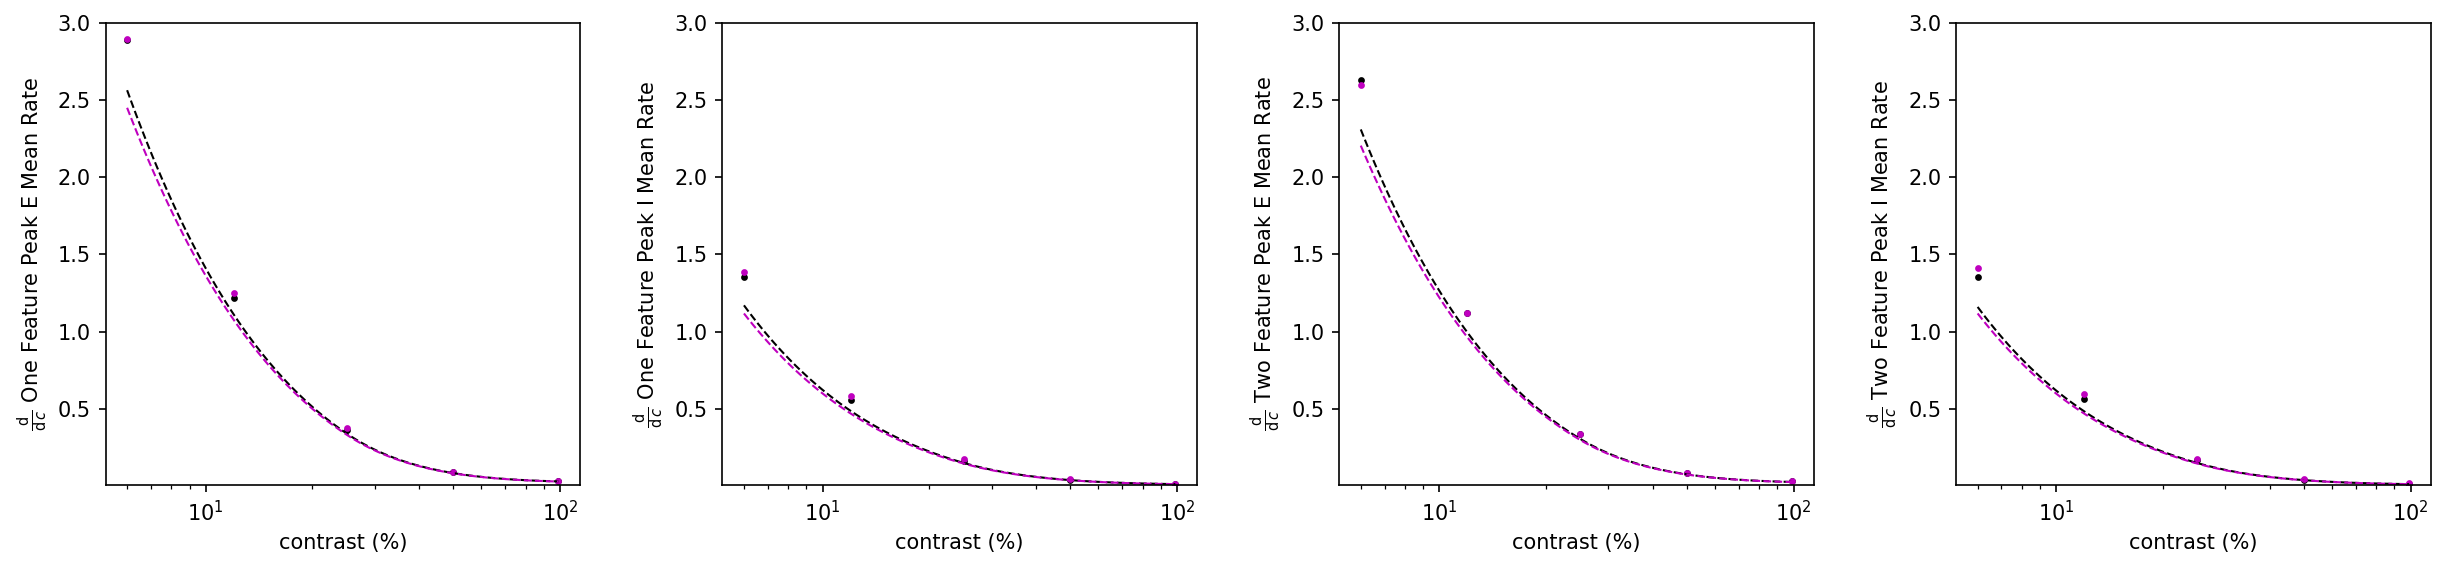

In [300]:
from scipy.interpolate import UnivariateSpline

fig,axs = plt.subplots(1,4,figsize=(20,4),dpi=150,sharex=True)
fig.subplots_adjust(hspace=0.15,wspace=0.3)

fine_log10cons = np.linspace(np.log10(cons[1]),np.log10(cons[-1]),101)

axs[0].scatter(cons[1:],[res_dict_daX_inits[cidx]['drp'][0] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[0].plot(10**fine_log10cons,ditpvE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[1].scatter(cons[1:],[res_dict_daX_inits[cidx]['drp'][1] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[1].plot(10**fine_log10cons,ditpvI(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[0].scatter(cons[1:],[res_dict_daX_perts[cidx]['drp'][0] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[0].plot(10**fine_log10cons,ditpoE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)
axs[1].scatter(cons[1:],[res_dict_daX_perts[cidx]['drp'][1] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[1].plot(10**fine_log10cons,ditpoI(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)

axs[2].scatter(cons[1:],[res_dict_daX_norm_inits[cidx]['drp'][0] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[2].plot(10**fine_log10cons,ditp2vE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[3].scatter(cons[1:],[res_dict_daX_norm_inits[cidx]['drp'][1] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[3].plot(10**fine_log10cons,ditp2vI(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[2].scatter(cons[1:],[res_dict_daX_norm_perts[cidx]['drp'][0] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[2].plot(10**fine_log10cons,ditp2oE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)
axs[3].scatter(cons[1:],[res_dict_daX_norm_perts[cidx]['drp'][1] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[3].plot(10**fine_log10cons,ditp2oI(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)

for i in range(4):
    axs[i].set_ylim(0.006,3)

for i in range(4):
    axs[i].set_xlabel('contrast (%)')
    axs[i].set_xscale('log')
    # axs[i].set_yscale('log')
    
axs[0].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ One Feature Peak E Mean Rate')
axs[1].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ One Feature Peak I Mean Rate')
axs[2].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ Two Feature Peak E Mean Rate')
axs[3].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ Two Feature Peak I Mean Rate')

Text(0, 0.5, '$\\frac{\\mathrm{d}}{\\mathrm{d}\\,c}$ Two Feature Peak E Mean Rate')

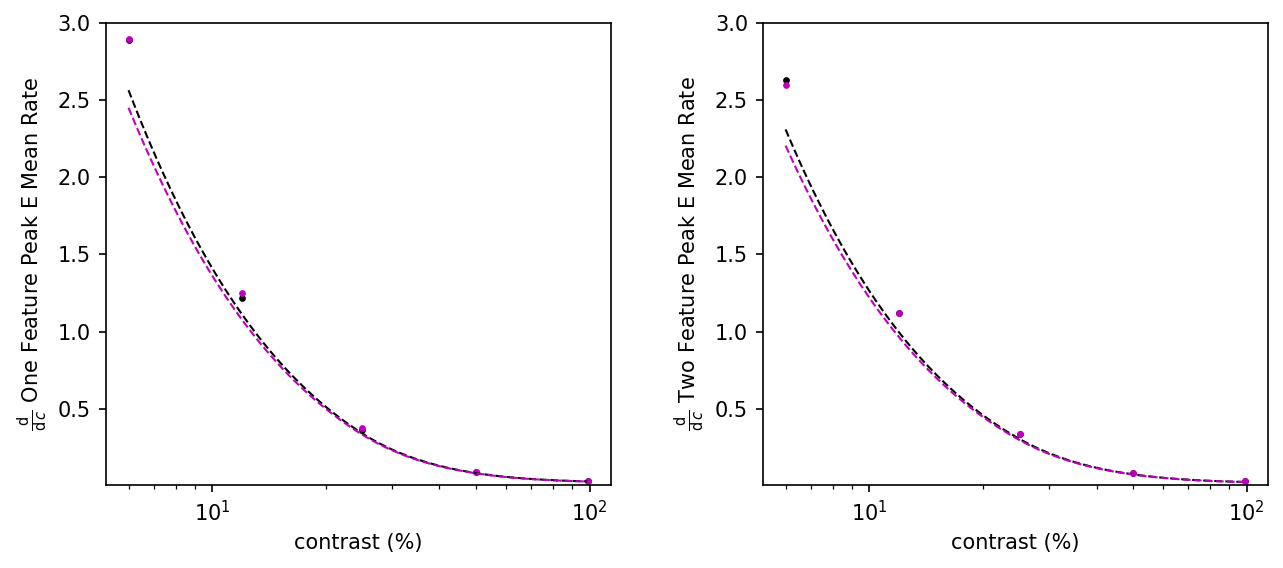

In [301]:
from scipy.interpolate import UnivariateSpline

fig,axs = plt.subplots(1,2,figsize=(10,4),dpi=150,sharex=True)
fig.subplots_adjust(hspace=0.15,wspace=0.3)

fine_log10cons = np.linspace(np.log10(cons[1]),np.log10(cons[-1]),101)

axs[0].scatter(cons[1:],[res_dict_daX_inits[cidx]['drp'][0] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[0].plot(10**fine_log10cons,ditpvE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[0].scatter(cons[1:],[res_dict_daX_perts[cidx]['drp'][0] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[0].plot(10**fine_log10cons,ditpoE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)

axs[1].scatter(cons[1:],[res_dict_daX_norm_inits[cidx]['drp'][0] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='k',s=5)
axs[1].plot(10**fine_log10cons,ditp2vE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'k--',lw=1)
axs[1].scatter(cons[1:],[res_dict_daX_norm_perts[cidx]['drp'][0] for cidx in range(1,6)]*\
    ditph(np.log10(cons[1:]))/(cons[1:]*np.log(10)),color='m',s=5)
axs[1].plot(10**fine_log10cons,ditp2oE(fine_log10cons)/(10**fine_log10cons*np.log(10)),'m--',lw=1)

for i in range(2):
    axs[i].set_ylim(0.006,3)

for i in range(2):
    axs[i].set_xlabel('contrast (%)')
    axs[i].set_xscale('log')
    # axs[i].set_yscale('log')
    
axs[0].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ One Feature Peak E Mean Rate')
axs[1].set_ylabel(r'$\frac{\mathrm{d}}{\mathrm{d}\,c}$ Two Feature Peak E Mean Rate')

In [287]:
print([res_dict_daX_inits[cidx]['drp'][0] for cidx in range(1,6)])
print([res_dict_daX_perts[cidx]['drp'][0] for cidx in range(1,6)])
print()
print([res_dict_daX_inits[cidx]['drp0dis'][0] for cidx in range(1,6)])
print([res_dict_daX_perts[cidx]['drp0dis'][0] for cidx in range(1,6)])

[9.716188376337183, 9.595765642886352, 9.450252483537822, 9.361476043782794, 9.310884632876922]
[9.734781763677965, 9.834311789949867, 9.769216463995066, 9.707823557006135, 9.675188243004653]

[10.996916755133434, 10.89911889225987, 10.748346382580669, 10.648209393970129, 10.587859385455193]
[10.402630549919259, 10.638202549550808, 10.651004881954188, 10.620418974076332, 10.596011318270746]


In [283]:
print([res_dict_daX_norm_inits[cidx]['drp'][0] for cidx in range(1,6)])
print([res_dict_daX_norm_perts[cidx]['drp'][0] for cidx in range(1,6)])

[9.767682523161165, 9.720678633029049, 9.597491762186237, 9.548035915568775, 9.491960565316445]
[9.663186647968342, 9.818063381336831, 9.808715558374336, 9.78670640504124, 9.765681489259135]


# Miscellaneous

In [319]:
with open('./../results/'+'itp_ranges'+'.pkl', 'rb') as handle:
    ranges_dict = pickle.load(handle)

In [414]:
from scipy.special import erf, erfi, erfcx, dawsn
from mpmath import fp

def int_dawsni_scal(x):
    return -0.5*x**2*fp.hyp2f2(1.0,1.0,1.5,2.0,x**2)
int_dawsni = np.vectorize(int_dawsni_scal)

sr2 = np.sqrt(2)
sr2pi = np.sqrt(2*np.pi)
srpi = np.sqrt(np.pi)

u = np.linspace(-0.1,0.2,401)
min_u = (ri.Vr-u)/ri.st
max_u = (ri.tht-u)/ri.st

r = np.zeros_like(u);

for idx in range(len(u)):
    if(min_u[idx]>3):
        r[idx]=max_u[idx]/ri.tE/ric.srpi*np.exp(-max_u[idx]**2)
    elif(min_u[idx]>-5):
        r[idx]=1.0/(ri.trp+ri.tE*(0.5*np.pi*\
                            (erfi(max_u[idx]) - erfi(min_u[idx])) +
                            -2*(int_dawsni(max_u[idx]) - int_dawsni(min_u[idx]))))
    else:
        r[idx]=1.0/(ri.trp+ri.tE*(np.log(abs(min_u[idx])) -
                                np.log(abs(max_u[idx])) +
                            (0.25*min_u[idx]**-2 - 0.1875*min_u[idx]**-4 +
                            0.3125*min_u[idx]**-6 - 0.8203125*min_u[idx]**-8 +
                            2.953125*min_u[idx]**-10) -
                            (0.25*max_u[idx]**-2 - 0.1875*max_u[idx]**-4 +
                            0.3125*max_u[idx]**-6 - 0.8203125*max_u[idx]**-8 +
                            2.953125*max_u[idx]**-10)))

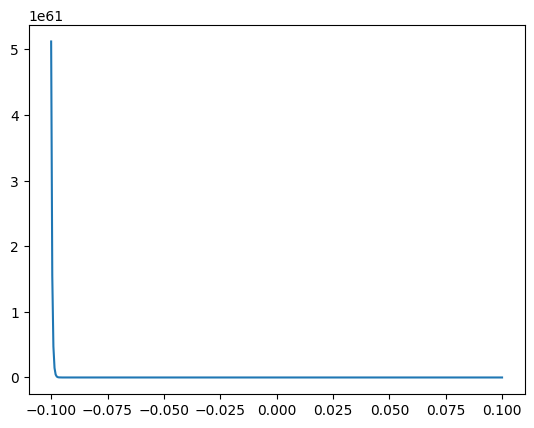

In [396]:
plt.plot(u,0.5*np.pi*erfi(max_u) - 2*int_dawsni(max_u))

In [378]:
erfi(-1)

-1.6504257587975428

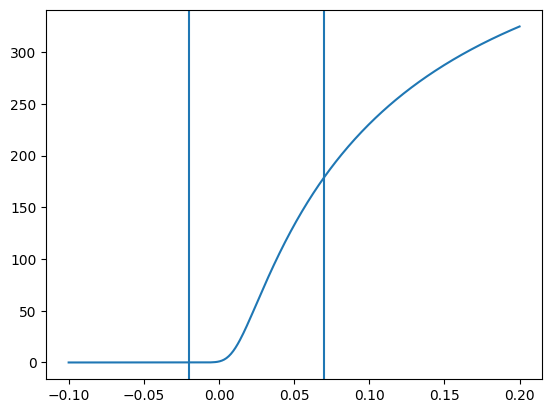

In [415]:
plt.plot(u,r)
plt.axvline(ri.Vr-3*ri.st)
plt.axvline(ri.Vr+6*ri.st)

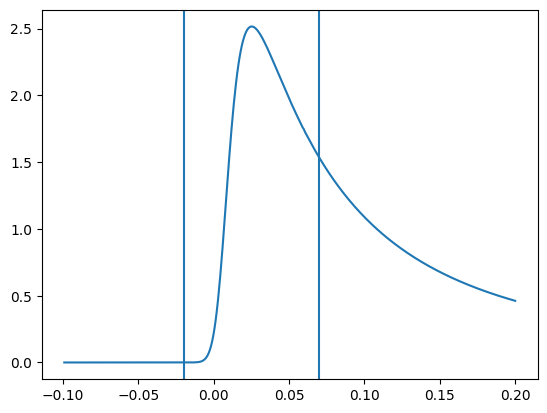

In [416]:
plt.plot(u[1:],r[1:]-r[:-1])
plt.axvline(ri.Vr-3*ri.st)
plt.axvline(ri.Vr+6*ri.st)

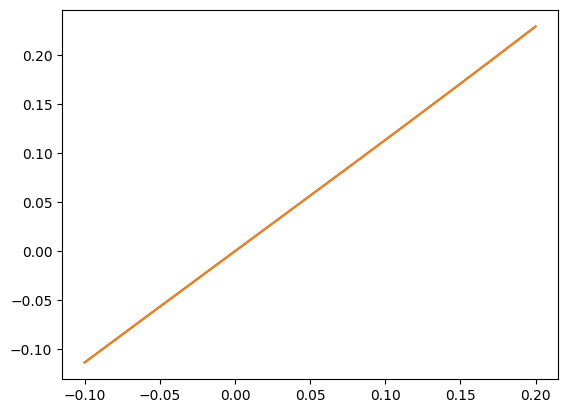

In [407]:
plt.plot(u,erfi(u))
plt.plot(u,2/srpi*(dawsn(u)*np.exp(u**2)))

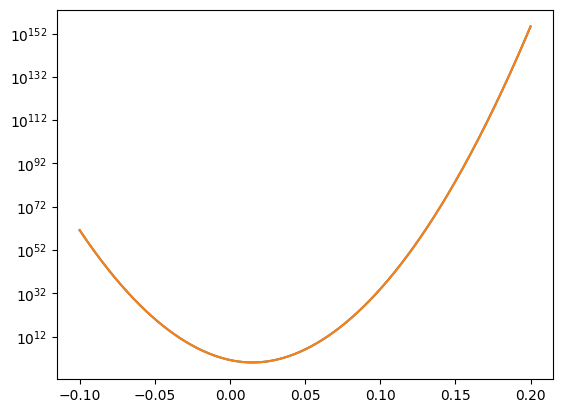

In [409]:
plt.plot(u,erfi((ri.tht-u)/ri.st) - erfi((ri.Vr-u)/ri.st))
plt.plot(u,2/srpi*(dawsn((ri.tht-u)/ri.st)*np.exp(((ri.tht-u)/ri.st)**2)-\
    dawsn((ri.Vr-u)/ri.st)*np.exp(((ri.Vr-u)/ri.st)**2)))
plt.yscale('log')

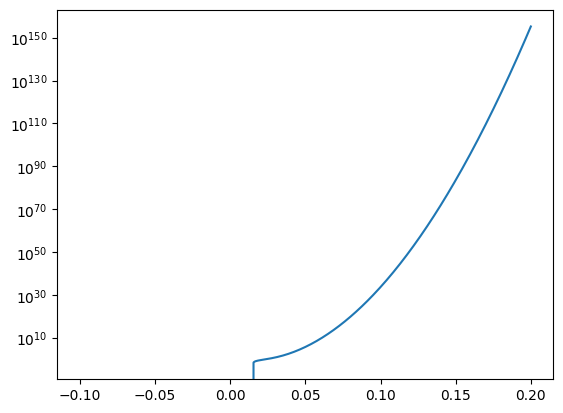

In [410]:
plt.plot(u,int_dawsni(max_u) - int_dawsni(min_u))
plt.yscale('log')

In [385]:
int_dawsni(u)

array([-5.01671121e-03, -4.96650404e-03, -4.91655187e-03, -4.86685462e-03,
       -4.81741225e-03, -4.76822472e-03, -4.71929198e-03, -4.67061396e-03,
       -4.62219063e-03, -4.57402194e-03, -4.52610784e-03, -4.47844827e-03,
       -4.43104320e-03, -4.38389257e-03, -4.33699634e-03, -4.29035446e-03,
       -4.24396688e-03, -4.19783356e-03, -4.15195444e-03, -4.10632949e-03,
       -4.06095866e-03, -4.01584190e-03, -3.97097917e-03, -3.92637041e-03,
       -3.88201560e-03, -3.83791467e-03, -3.79406760e-03, -3.75047432e-03,
       -3.70713481e-03, -3.66404902e-03, -3.62121689e-03, -3.57863840e-03,
       -3.53631349e-03, -3.49424213e-03, -3.45242427e-03, -3.41085987e-03,
       -3.36954889e-03, -3.32849129e-03, -3.28768702e-03, -3.24713605e-03,
       -3.20683833e-03, -3.16679383e-03, -3.12700250e-03, -3.08746430e-03,
       -3.04817920e-03, -3.00914715e-03, -2.97036812e-03, -2.93184206e-03,
       -2.89356894e-03, -2.85554872e-03, -2.81778136e-03, -2.78026682e-03,
       -2.74300507e-03, -

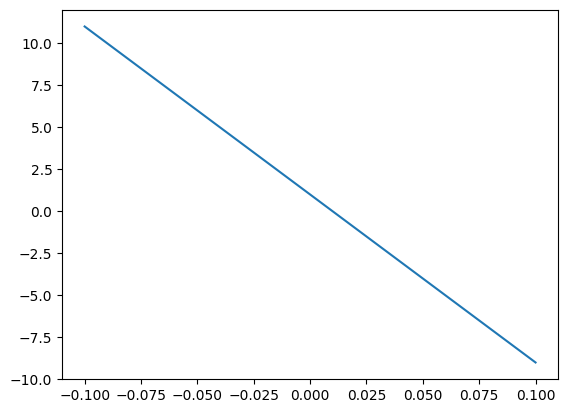

In [386]:
plt.plot(u,min_u)

In [417]:
oris = np.arange(20)/20 * 180
doris = oris[:,None] - oris[None,:]

In [431]:
kerns = dmft.wrapnormdens(doris[:,:,None,None],sW[None,None,:,:])
# kerns /= np.sum(kerns,1,keepdims=True)

In [443]:
np.sum(kerns[:,:,0,1],-1)[0]*2*np.pi/20

0.9999999999999998

In [447]:
np.sum(muW[None,None,:,:]*2*np.pi*kerns,1)[:,0,0]

array([0.03126955, 0.03126955, 0.03126955, 0.03126955, 0.03126955,
       0.03126955, 0.03126955, 0.03126955, 0.03126955, 0.03126955,
       0.03126955, 0.03126955, 0.03126955, 0.03126955, 0.03126955,
       0.03126955, 0.03126955, 0.03126955, 0.03126955, 0.03126955])

In [534]:
reload(dmft)

Twrm = 1.2
Tsav = 0.4
dt = 0.01/5

res_dict_decoup_ring = dmft.run_decoupled_ring_dmft(prms,bX,aXs[-1]/bX,eX,'./../results',ri,Twrm,Tsav,dt,struct_dict=res_dict_init,which='opto',return_full=True)

0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
0.20% completed
0.40% completed


KeyboardInterrupt: 

In [562]:
Nori = 20

tau = np.array([ri.tE,ri.tI],dtype=np.float32)
W = J*np.array([[1,-gE],[1./beta,-gI/beta]],dtype=np.float32)
Ks = np.array([K,K/4],dtype=np.float32)
Hb = bX*K*J*np.array([hE,hI/beta],dtype=np.float32)
Hp = (bX+aXs[-1])*K*J*np.array([hE,hI/beta],dtype=np.float32)
eH = eX
sW = np.array([[SoriE,SoriI],[SoriE,SoriI]],dtype=np.float32)
sH = np.array([SoriF,SoriF],dtype=np.float32)

oris = np.arange(Nori)/Nori * 180
doris = oris[:,None] - oris[None,:]
kerns = dmft.wrapnormdens(doris[:,:,None,None],sW[None,None,:,:])

muWs = (muW[None,None,:,:]*2*np.pi*kerns) / Nori
SigWs = (SigW[None,None,:,:]*2*np.pi*kerns) / Nori

rs = res_dict_init['rb'][None,:] + (res_dict_init['rp']-res_dict_init['rb'])[None,:]*\
    dmft.basesubwrapnorm(oris[:,None],sr[None,:])
Crs = res_dict_init['Crb'][None,:,:] + (res_dict_init['Crp']-res_dict_init['Crb'])[None,:,:]*\
    dmft.basesubwrapnorm(oris[:,None,None],sCr[None,:,None])

muHs = tau[None,:]*(Hb[None,:] + (Hp-Hb)[None,:]*dmft.basesubwrapnorm(oris[:,None],sH[None,:]))
SigHs = ((tau[None,:]*(Hb[None,:] + (Hp-Hb)[None,:]*dmft.basesubwrapnorm(oris[:,None],sH[None,:]))*eH)**2)[:,:,None]

mus = muHs + np.einsum('ijkl,jl->ik',muWs,rs)
Sigs = SigHs + np.einsum('ijkl,jlm->ikm',SigWs,Crs)

dmuHdξs = (tau*K*J*np.array([hE,hI/beta],dtype=np.float32))[None,:]*np.ones(Nori)[:,None]
dSigHdξs = (2*muHs*dmuHdξs*eH**2)[:,:,None]

In [569]:
φs = np.zeros_like(rs)
φps = np.zeros_like(rs)
φpps = np.zeros_like(rs)
Rφφs = np.zeros_like(Crs)
Rφφps = np.zeros_like(Crs)
Rφφpps = np.zeros_like(Crs)
Rφpφps = np.zeros_like(Crs)

for i in range(Nori):
    φs[i] = np.array([MFE(mus[i,0],Sigs[i,0,0])[0],MFI(mus[i,1],Sigs[i,1,0])[0]])
    φps[i] = np.array([MFPE(mus[i,0],Sigs[i,0,0])[0],MFPI(mus[i,1],Sigs[i,1,0])[0]])
    φpps[i] = np.array([MFPPE(mus[i,0],Sigs[i,0,0])[0],MFPPI(mus[i,1],Sigs[i,1,0])[0]])

    Rφφs[i] = np.array([[CFFE(mus[i,0],Sigs[i,0,0],cov)[0] for cov in Sigs[i,0]],
                        [CFFI(mus[i,1],Sigs[i,1,0],cov)[0] for cov in Sigs[i,1]]])
    Rφφps[i] = np.array([[CFFPE(mus[i,0],Sigs[i,0,0],cov)[0] for cov in Sigs[i,0]],
                         [CFFPI(mus[i,1],Sigs[i,1,0],cov)[0] for cov in Sigs[i,1]]])
    Rφφpps[i] = np.array([[CFFPPE(mus[i,0],Sigs[i,0,0],cov)[0] for cov in Sigs[i,0]],
                          [CFFPPI(mus[i,1],Sigs[i,1,0],cov)[0] for cov in Sigs[i,1]]])
    Rφpφps[i] = np.array([[CFPFPE(mus[i,0],Sigs[i,0,0],cov)[0] for cov in Sigs[i,0]],
                          [CFPFPI(mus[i,1],Sigs[i,1,0],cov)[0] for cov in Sigs[i,1]]])

    Rφφpps[i] = smooth_func(Rφφpps[i],dt)
    Rφpφps[i] = smooth_func(Rφpφps[i],dt)

(0.0, 65.93273651060026)

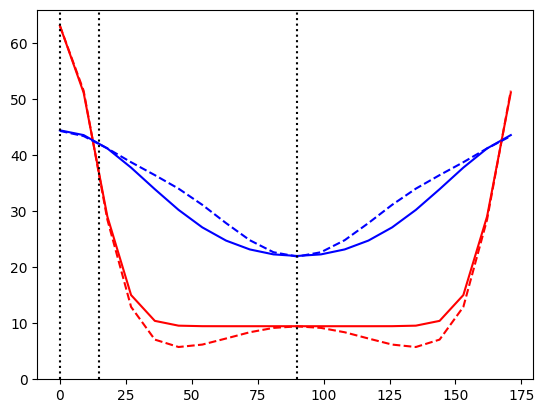

In [607]:
plt.plot(oris,rs[:,0],'r')
plt.plot(oris,rs[:,1],'b')
plt.plot(oris,φs[:,0],'r--')
plt.plot(oris,φs[:,1],'b--')
plt.axvline(0,c='k',ls=':')
plt.axvline(15,c='k',ls=':')
plt.axvline(90,c='k',ls=':')

plt.ylim(0,None)

In [589]:
As = np.eye(Nori)[:,:,None,None]*np.eye(NP)[None,None,:,:] - φps[:,None,:,None] * muWs
Bs = -0.5 * φpps[:,None,:,None,None] * SigWs[:,:,:,:,None] * δ[None,None,None,None,:]
Cs = -2 * Rφφps[:,None,:,:,None] * muWs[:,:,:,None,:]
Ds = np.eye(Nori)[:,:,None,None,None,None]*(np.eye(NP)[None,None,:,None,:,None]*np.eye(NT)[None,None,None,:,None,:] +\
    - np.diag(tau**2)[None,None,:,None,:,None] * L[None,None,None,:,None,:] +\
        dt*np.diag(tau)[None,None,:,None,:,None] * L[None,None,None,:,None,:]) +\
    - Rφpφps[:,None,:,:,None,None] * SigWs[:,:,:,None,:,None] * np.eye(NT)[None,None,None,:,None,:] +\
    - Rφφpps[:,None,:,:,None,None] * SigWs[:,:,:,None,:,None] * δ[None,None,None,None,None,:]
    
Es = φps * dmuHdξs + 0.5 * φpps * dSigHdξs[:,:,0]
Fs = 2 * Rφφps * dmuHdξs[:,:,None] + Rφφpps * dSigHdξs[:,:,0:1] + Rφpφps * dSigHdξs

In [602]:
Ms = np.zeros((Nori,Nori,NP*(NT+1),NP*(NT+1)))
fs = np.zeros((Nori,NP*(NT+1)))

for i in range(Nori):
    fs[i] = np.concatenate([Es[i],Fs[i].flatten()])
    for j in range(Nori):
        Ms[i,j] = np.block([[As[i,j],np.zeros_like(Bs[i,j]).reshape(NP,NP*NT)],[Cs[i,j].reshape(NP*NT,NP),Ds[i,j].reshape(NP*NT,NP*NT)]])

In [603]:
dmdξs = np.linalg.solve(Ms.transpose(0,2,1,3).reshape(Nori*NP*(NT+1),Nori*NP*(NT+1)),fs.flatten()).reshape(Nori,NP*(NT+1))

In [604]:
drdξs = np.zeros_like(rs)
for i in range(Nori):
    drdξs[i] = dmdξs[i,:2]

(0.0, 5.589520807400232)

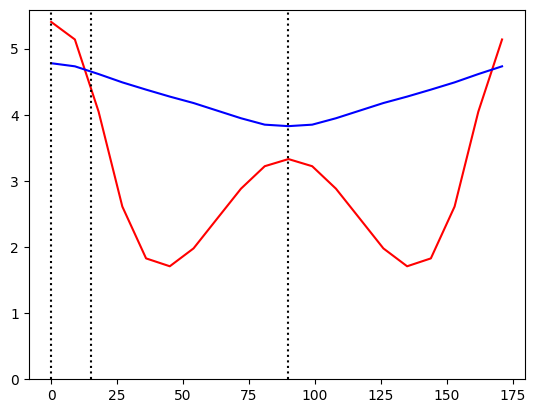

In [606]:
plt.plot(oris,drdξs[:,0],'r')
plt.plot(oris,drdξs[:,1],'b')
plt.axvline(0,c='k',ls=':')
plt.axvline(15,c='k',ls=':')
plt.axvline(90,c='k',ls=':')

plt.ylim(0,None)

(0.0, 71.59365366040498)

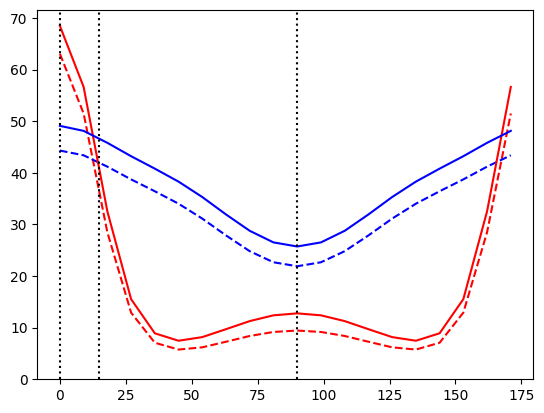

In [610]:
plt.plot(oris,φs[:,0],'r')
plt.plot(oris,φs[:,0],'r:')
# plt.plot(oris,φs[:,1],'b--')
plt.plot(oris,φs[:,0]+0.5*drdξs[:,0],'r--')
# plt.plot(oris,φs[:,1]+1*drdξs[:,1],'b')
plt.axvline(0,c='k',ls=':')
plt.axvline(15,c='k',ls=':')
plt.axvline(90,c='k',ls=':')

plt.ylim(0,None)

In [583]:
(-0.5 * φpps[:,None,:,None,None] * SigWs[:,:,:,:,None] * δ[None,None,None,None,:]).shape

(20, 20, 2, 2, 201)

In [612]:
δrX = 0.5

res_dict_pert = dmft.run_first_stage_ring_dmft(prms,bX+δrX,aXs[-1]/(bX+δrX),eX,'./../results',ri,Twrm,Tsav,dt,which='base',return_full=True)

0.20% completed


/Users/tuannguyen/ToroidalNetworks/sparse_weights/notebooks/./../scripts/dmft.py:701: RuntimeWarning: invalid value encountered in divide
  sCrij = solve_width((Craij-Crbij)/(Crpij-Crbij))


0.40% completed
0.60% completed
0.80% completed
1.00% completed
integrating first stage took 631.884438 s


In [613]:
pert_rs = res_dict_init['rb'][None,:] + (res_dict_init['rp']-res_dict_init['rb'])[None,:]*\
    dmft.basesubwrapnorm(oris[:,None],sr[None,:])
pert_Crs = res_dict_init['Crb'][None,:,:] + (res_dict_init['Crp']-res_dict_init['Crb'])[None,:,:]*\
    dmft.basesubwrapnorm(oris[:,None,None],sCr[None,:,None])

In [ ]:
pert_φs = np.zeros_like(rs)

for i in range(Nori):
    pert_φs[i] = np.array([MFE(mus[i,0],Sigs[i,0,0])[0],MFI(mus[i,1],Sigs[i,1,0])[0]])

In [183]:
reload(dmft)

full_ring_res_dict = dmft.run_first_stage_full_ring_dmft(prms,bX,aXs[-1]/bX,eX,'./../results',ri,0.8,0.2,0.01/3,Nori=4,which='both',return_full=True)

0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
integrating first stage took 75.27745500000003 s


In [192]:
reload(dmft)

diff_full_ring_res_dict = dmft.run_second_stage_full_ring_dmft(full_ring_res_dict,prms,bX,aXs[-1]/bX,eX,'./../results',ri,0.8,0.2,0.01/3,Nori=4,return_full=True)

0.05% completed
0.10% completed
0.15% completed
0.20% completed
0.25% completed
0.30% completed
0.35% completed
0.40% completed
0.45% completed
0.50% completed
0.55% completed
0.60% completed
0.65% completed
0.70% completed
0.75% completed
0.80% completed
0.85% completed
0.90% completed
0.95% completed
1.00% completed
integrating second stage took 1015.936074 s


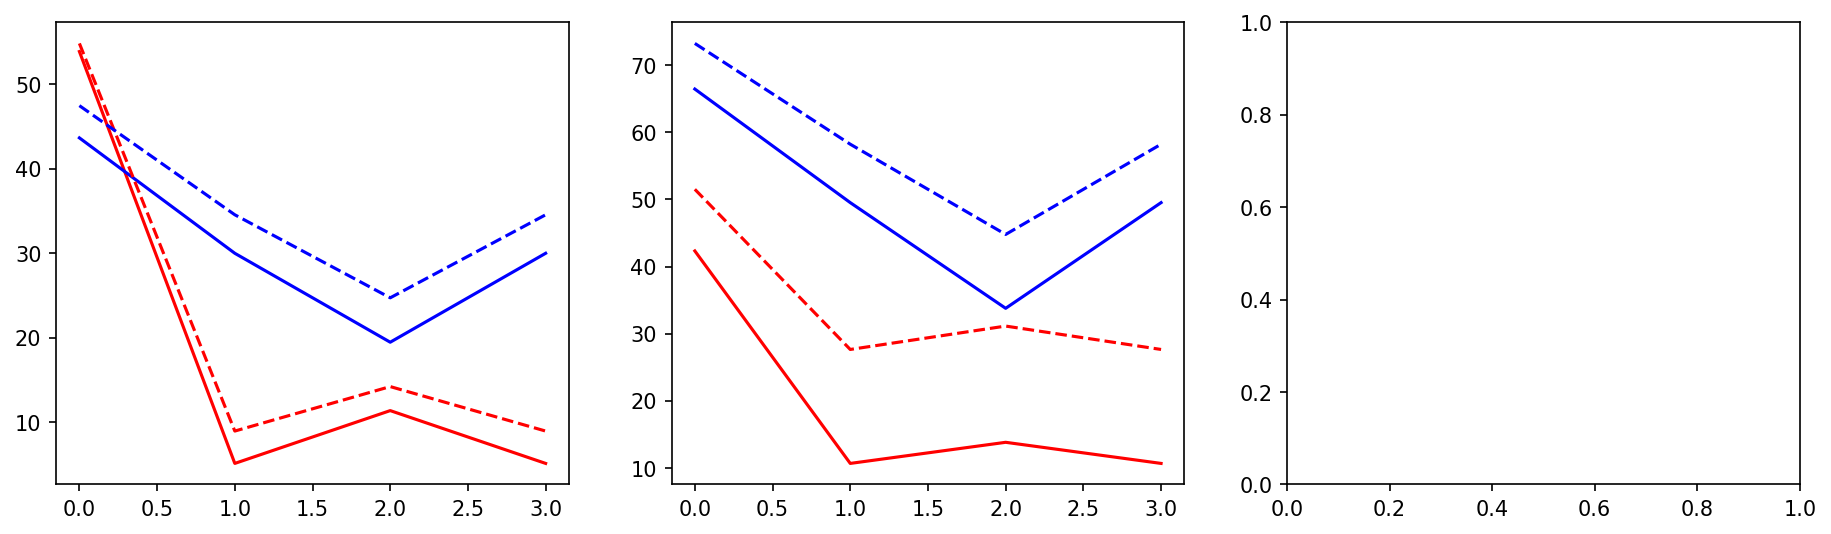

In [185]:
fig,axs = plt.subplots(1,3,figsize=(15,4),dpi=150)

axs[0].plot(full_ring_res_dict['rs'][:,0],'r')
axs[0].plot(full_ring_res_dict['rs'][:,1],'b')
axs[0].plot(full_ring_res_dict['rs'][:,2],'r--')
axs[0].plot(full_ring_res_dict['rs'][:,3],'b--')

axs[1].plot(np.sqrt(full_ring_res_dict['Crs'][:,0,-1]-full_ring_res_dict['rs'][:,0]**2),'r')
axs[1].plot(np.sqrt(full_ring_res_dict['Crs'][:,1,-1]-full_ring_res_dict['rs'][:,1]**2),'b')
axs[1].plot(np.sqrt(full_ring_res_dict['Crs'][:,2,-1]-full_ring_res_dict['rs'][:,2]**2),'r--')
axs[1].plot(np.sqrt(full_ring_res_dict['Crs'][:,3,-1]-full_ring_res_dict['rs'][:,3]**2),'b--')

axs[2].plot(np.sqrt(diff_full_ring_res_dict['Cdrs'][:,0,-1]-diff_full_ring_res_dict['drs'][:,0]**2),'r--')
axs[2].plot(np.sqrt(diff_full_ring_res_dict['Cdrs'][:,1,-1]-diff_full_ring_res_dict['drs'][:,1]**2),'b--')

In [7]:
prms

{'K': 500,
 'SoriE': 43.64874397050553,
 'SoriI': 19.762766061548188,
 'SoriF': 18.319783509742784,
 'J': 0.0001563477555477658,
 'beta': 0.11430243102629813,
 'gE': 5.950020178827337,
 'gI': 2.6064265565889126,
 'hE': 4.944829366729805,
 'hI': 0.14751926973057156,
 'L': 5.482675876659675,
 'CVL': 3.2538001583918414,
 'Nori': 20,
 'NE': 400,
 'NI': 100}

In [9]:
aXs

array([0.        , 3.30629524, 4.46169544, 5.40280958, 5.86330927,
       6.11965919])

In [40]:
np.sum(dmft.wrapnormdens(np.arange(20)*180/20,19.76)*2*np.pi/20 * 125/100 * sim_μrIs[-1,0,:]**2)

2018.995476531258

In [42]:
np.sum(dmft.wrapnormdens(np.arange(20)*180/20,43.64)*2*np.pi/20 * 125/100 * sim_μrEs[-1,0,:]**2)

1343.2281537410124

In [41]:
np.sum(sim_ΣrIs[-1,0,:] + sim_μrIs[-1,0,:]**2)

74535.52704135247

In [43]:
np.sum(sim_ΣrEs[-1,0,:] + sim_μrEs[-1,0,:]**2)

23451.997806106054

In [14]:
sim_all_base_means = np.zeros((6))
sim_all_base_stds = np.zeros((6))
sim_all_opto_means = np.zeros((6))
sim_all_opto_stds = np.zeros((6))
sim_all_diff_means = np.zeros((6))
sim_all_diff_stds = np.zeros((6))
sim_all_norm_covs = np.zeros((6))
sim_vsm_base_means = np.zeros((6))
sim_vsm_base_stds = np.zeros((6))
sim_vsm_opto_means = np.zeros((6))
sim_vsm_opto_stds = np.zeros((6))
sim_vsm_diff_means = np.zeros((6))
sim_vsm_diff_stds = np.zeros((6))
sim_vsm_norm_covs = np.zeros((6))
sim_osm_diff_means = np.zeros((6))
sim_vsm_bals = np.zeros((6))
sim_vsm_oves = np.zeros((6))
sim_μrEs = np.zeros((6,3,20))
sim_μrIs = np.zeros((6,3,20))
sim_ΣrEs = np.zeros((6,4,20))
sim_ΣrIs = np.zeros((6,4,20))
sim_balEs = np.zeros((6,2,20))
sim_balIs = np.zeros((6,2,20))
sim_preds = np.zeros((6,6,20))
sim_Lexps = np.zeros((6,2))
sim_timeouts = np.zeros((6,2))

for c_idx in range(6):
    try:
        with open('./../results/best_fit_1s_id_None_c_{:d}'.format(c_idx)+'.pkl','rb') as\
                handle:
            res_dict = pickle.load(handle)

        sim_all_base_means[c_idx] = res_dict['all_base_means']
        sim_all_base_stds[c_idx] = res_dict['all_base_stds']
        sim_all_opto_means[c_idx] = res_dict['all_opto_means']
        sim_all_opto_stds[c_idx] = res_dict['all_opto_stds']
        sim_all_diff_means[c_idx] = res_dict['all_diff_means']
        sim_all_diff_stds[c_idx] = res_dict['all_diff_stds']
        sim_all_norm_covs[c_idx] = res_dict['all_norm_covs']
        sim_vsm_base_means[c_idx] = res_dict['vsm_base_means']
        sim_vsm_base_stds[c_idx] = res_dict['vsm_base_stds']
        sim_vsm_opto_means[c_idx] = res_dict['vsm_opto_means']
        sim_vsm_opto_stds[c_idx] = res_dict['vsm_opto_stds']
        sim_vsm_diff_means[c_idx] = res_dict['vsm_diff_means']
        sim_vsm_diff_stds[c_idx] = res_dict['vsm_diff_stds']
        sim_vsm_norm_covs[c_idx] = res_dict['vsm_norm_covs']
        sim_osm_diff_means[c_idx] = res_dict['osm_diff_means']
        sim_vsm_bals[c_idx] = res_dict['vsm_bals']
        sim_vsm_oves[c_idx] = res_dict['vsm_oves']
        sim_μrEs[c_idx] = np.mean(res_dict['μrEs'],0)
        sim_μrIs[c_idx] = np.mean(res_dict['μrIs'],0)
        sim_ΣrEs[c_idx] = np.mean(res_dict['ΣrEs'],0)
        sim_ΣrIs[c_idx] = np.mean(res_dict['ΣrIs'],0)
        sim_balEs[c_idx] = np.mean(res_dict['balEs'],0)
        sim_balIs[c_idx] = np.mean(res_dict['balIs'],0)
        sim_Lexps[c_idx] = np.median(res_dict['Lexps'],-2)
        sim_timeouts[c_idx] = np.sum(res_dict['timeouts'],-2)

    except:
        sim_all_base_means[c_idx] = np.nan
        sim_all_base_stds[c_idx] = np.nan
        sim_all_opto_means[c_idx] = np.nan
        sim_all_opto_stds[c_idx] = np.nan
        sim_all_diff_means[c_idx] = np.nan
        sim_all_diff_stds[c_idx] = np.nan
        sim_all_norm_covs[c_idx] = np.nan
        sim_vsm_base_means[c_idx] = np.nan
        sim_vsm_base_stds[c_idx] = np.nan
        sim_vsm_opto_means[c_idx] = np.nan
        sim_vsm_opto_stds[c_idx] = np.nan
        sim_vsm_diff_means[c_idx] = np.nan
        sim_vsm_diff_stds[c_idx] = np.nan
        sim_vsm_norm_covs[c_idx] = np.nan
        sim_osm_diff_means[c_idx] = np.nan
        sim_vsm_bals[c_idx] = np.nan
        sim_vsm_oves[c_idx] = np.nan
        sim_μrEs[c_idx] = np.nan
        sim_μrIs[c_idx] = np.nan
        sim_ΣrEs[c_idx] = np.nan
        sim_ΣrIs[c_idx] = np.nan
        sim_balEs[c_idx] = np.nan
        sim_balIs[c_idx] = np.nan
        sim_Lexps[c_idx] = np.nan
        sim_timeouts[c_idx] = 0
        
sim_preds = np.concatenate((
    sim_vsm_base_means[:,None],
    sim_vsm_opto_means[:,None],
    sim_vsm_base_stds[:,None],
    sim_vsm_opto_stds[:,None],
    sim_vsm_diff_stds[:,None],
    sim_vsm_norm_covs[:,None],
    sim_vsm_diff_means[:,None],
    sim_osm_diff_means[:,None],
),1)
        
sim_Epreds = np.concatenate((
    sim_μrEs[:,0:1,:],
    sim_μrEs[:,1:2,:],
    np.sqrt(sim_ΣrEs[:,0:1,:]),
    np.sqrt(sim_ΣrEs[:,1:2,:]),
    np.sqrt(sim_ΣrEs[:,2:3,:]),
    sim_ΣrEs[:,3:4,:]/sim_ΣrEs[:,2:3,:],
    sim_μrEs[:,2:3,:]
),1)

sim_Ipreds = np.concatenate((
    sim_μrIs[:,0:1,:],
    sim_μrIs[:,1:2,:],
    np.sqrt(sim_ΣrIs[:,0:1,:]),
    np.sqrt(sim_ΣrIs[:,1:2,:]),
    np.sqrt(sim_ΣrIs[:,2:3,:]),
    sim_ΣrIs[:,3:4,:]/sim_ΣrIs[:,2:3,:],
    sim_μrIs[:,2:3,:]
),1)

nEsamp = 400*50
nIsamp = 100*50

sim_Epred_errs = np.concatenate((
    np.sqrt(sim_ΣrEs[:,0:1,:]/nEsamp),
    np.sqrt(sim_ΣrEs[:,1:2,:]/nEsamp),
    np.sqrt(sim_ΣrEs[:,0:1,:]/(2*nEsamp)),
    np.sqrt(sim_ΣrEs[:,1:2,:]/(2*nEsamp)),
    np.sqrt(sim_ΣrEs[:,2:3,:]/(2*nEsamp)),
    np.abs(sim_ΣrEs[:,3:4,:]/sim_ΣrEs[:,2:3,:])/np.sqrt(nEsamp)
),1)

sim_Ipred_errs = np.concatenate((
    np.sqrt(sim_ΣrIs[:,0:1,:]/nIsamp),
    np.sqrt(sim_ΣrIs[:,1:2,:]/nIsamp),
    np.sqrt(sim_ΣrIs[:,0:1,:]/(2*nIsamp)),
    np.sqrt(sim_ΣrIs[:,1:2,:]/(2*nIsamp)),
    np.sqrt(sim_ΣrIs[:,2:3,:]/(2*nIsamp)),
    np.abs(sim_ΣrIs[:,3:4,:]/sim_ΣrIs[:,2:3,:])/np.sqrt(nIsamp)
),1)

In [53]:
sim_norm_μrEs = np.zeros((6,3,20))
sim_norm_μrIs = np.zeros((6,3,20))
sim_norm_ΣrEs = np.zeros((6,4,20))
sim_norm_ΣrIs = np.zeros((6,4,20))

for c_idx in range(6):
    try:
        with open('./../results/opto_norm_45_id_None_base_1.0_c1_{:d}_c2_{:d}'.format(c_idx,c_idx)+'.pkl','rb') as\
                handle:
            res_dict = pickle.load(handle)

        sim_norm_μrEs[c_idx] = np.mean(res_dict['μrEs'],0)
        sim_norm_μrIs[c_idx] = np.mean(res_dict['μrIs'],0)
        sim_norm_ΣrEs[c_idx] = np.mean(res_dict['ΣrEs'],0)
        sim_norm_ΣrIs[c_idx] = np.mean(res_dict['ΣrIs'],0)

    except:
        sim_norm_μrEs[c_idx] = np.nan
        sim_norm_μrIs[c_idx] = np.nan
        sim_norm_ΣrEs[c_idx] = np.nan
        sim_norm_ΣrIs[c_idx] = np.nan

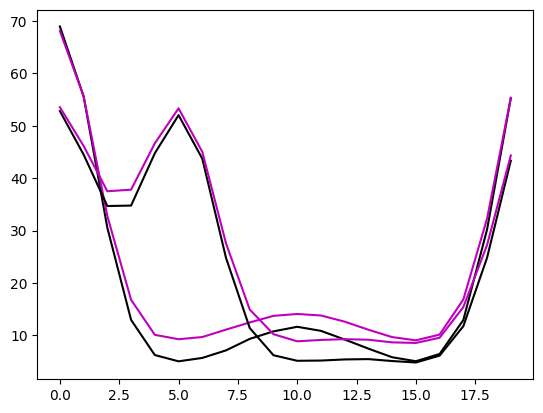

In [57]:
plt.plot(sim_μrEs[-1,0],'k')
plt.plot(sim_μrEs[-1,1],'m')
plt.plot(sim_norm_μrEs[-1,0],'k')
plt.plot(sim_norm_μrEs[-1,1],'m')

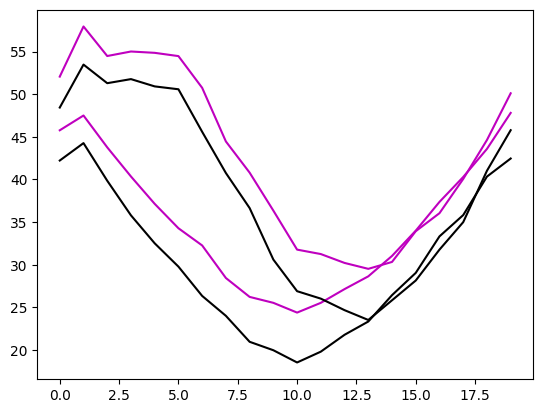

In [58]:
plt.plot(sim_μrIs[-1,0],'k')
plt.plot(sim_μrIs[-1,1],'m')
plt.plot(sim_norm_μrIs[-1,0],'k')
plt.plot(sim_norm_μrIs[-1,1],'m')

In [54]:
peak1 = 0.8*sim_μrEs[:,:2,0]+0.2*sim_μrIs[:,:2,0]
peak2 = 0.8*sim_norm_μrEs[:,:2,0]+0.2*sim_norm_μrIs[:,:2,0]

In [55]:
peak2/peak1

array([[0.99991161, 0.99999999],
       [0.85116969, 0.88464689],
       [0.83598306, 0.86037655],
       [0.82284364, 0.84552371],
       [0.81844775, 0.83945295],
       [0.81644582, 0.83667449]])

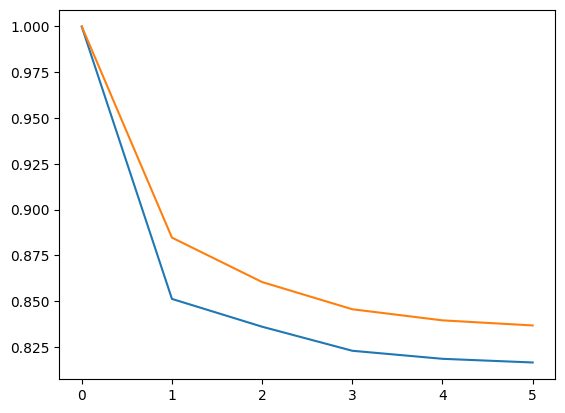

In [56]:
plt.plot(peak2/peak1)